# Аналитика ДТП по данным проекта "Карта ДТП"

Заказчиком (Оунером задачи) выступает проект «Карта ДТП» https://dtp-stat.ru/ — некоммерческий проект, посвященный проблеме дорожно-транспортных происшествий в России. Это платформа сбора данных о ДТП, бесплатный и открытый сервис аналитики ДТП.

**Цель проекта** - провести глубокий анализ данных, сформулировать и проверить гипотезы, опираясь на доступные признаки.

**Задачи**
* Провести исследовательский анализ данных о ДТП за 2025 год.
* Сформулировать и проверить не менее трех гипотез, основываясь на имеющихся признаках.
* Провести анализ ДТП по всем датасетам, представленным на сайте.
* Построить дашборд используя любой удобный инструмент, с учетом того, что дашборд может быть опубликован

**Декомпозиция работы:**
* Загрузка датасета и знакомство с данными
* Предобработка данных
* Исследовательский анализ данных
* Проверка гипотез
* Общие выводы
* Подготовка дашборда

## 1. Загрузка датасета и знакомство с данными

In [200]:
# Работа с файловой системой
import os

# Работа с данными
import pandas as pd
import numpy as np
import re

# Парсинг
import requests
from bs4 import BeautifulSoup
import zipfile

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

# Статистика
from scipy import stats
from scipy.stats import mannwhitneyu

# Настройка отображения Jupiter
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)  # Отображать все столбцы
pd.set_option('display.width', None)  # Автоматическая ширина
pd.set_option('display.max_colwidth', None)  # Отображать полную ширину столбцов
pd.set_option('display.float_format', '{:.2f}'.format)

### 1.1. Загрузка и распаковка датасетов с сайта проекта "Карта ДТП"

**Если требуется скачивание датасетов - установить флаг в положение `1`:**

In [201]:
load_needed = 0

Скачаем архивы датасетов с сайта проекта "Карта ДТП":

In [202]:
if load_needed:
    url = 'https://dtp-stat.ru/opendata'
    
    os.makedirs('geojson_files_zip', exist_ok=True)
    
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    
    for link in soup.find_all('a', href=True):
        href = link['href']
        if href.endswith('.zip'):
            # Полный URL файла
            file_url = href if href.startswith('http') else f'https://dtp-stat.ru{href}'
            
            # Скачиваем файл
            print(f'Скачиваем {file_url}')
            file_response = requests.get(file_url)
            
            # Сохраняем файл
            file_name = os.path.join('geojson_files_zip', os.path.basename(href))
            with open(file_name, 'wb') as f:
                f.write(file_response.content)
    
    print('Скачивание завершено.')

Распакуем архивы:

In [203]:
if load_needed:

    zip_folder = 'geojson_files_zip'
    
    output_folder = 'geojson_files'
    
    os.makedirs(output_folder, exist_ok=True)
    
    for filename in os.listdir(zip_folder):
        if filename.endswith('.zip'):
            zip_path = os.path.join(zip_folder, filename)
            print(f'Распаковываем {zip_path}...')
            
            # Открываем ZIP-файл и распаковываем его содержимое
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(output_folder)
    
    print('Распаковка завершена.')

Удаляем папку с архивами:

In [204]:
if load_needed:

    if os.path.exists(zip_folder) and os.path.isdir(zip_folder):
        # Проходим по всем файлам и подкаталогам в папке
        for root, dirs, files in os.walk(zip_folder, topdown=False):
            # Удаляем все файлы
            for file in files:
                file_path = os.path.join(root, file)
                os.remove(file_path)
                print(f'Удален файл: {file_path}')
            
            # Удаляем все подкаталоги
            for dir in dirs:
                dir_path = os.path.join(root, dir)
                os.rmdir(dir_path)
                print(f'Удален каталог: {dir_path}')
        
        # Удаляем саму папку
        os.rmdir(zip_folder)
        print(f'Папка "{zip_folder}" была успешно удалена.')
    else:
        print(f'Папка "{zip_folder}" не существует.')

### 1.2. Открытие датасетов и объединение в один

Загрузим данные:

In [205]:
all_records = []

download_dir = 'geojson_files'

# перебираем все .geojson в папке
for filename in os.listdir(download_dir):
    if filename.endswith(".geojson"):
        path = os.path.join(download_dir, filename)
        try:
            with open(path, encoding="utf-8") as f:
                data = json.load(f)
            accidents = data["features"]

            records = []
            for feature in accidents:
                props = feature["properties"].copy()
                props["geometry"] = feature["geometry"]
                records.append(props)

            all_records.extend(records)
            print(f"Загружено {len(records)} строк из {filename}")

        except Exception as e:
            print(f"Ошибка при обработке {filename}: {e}")

# объединяем в один датафрейм
data = pd.DataFrame(all_records)

print(f"Итого строк во всех файлах: {len(data)}")

# Удалим переменную all_records:
del all_records

Загружено 10307 строк из novgorodskaia-oblast.geojson
Загружено 27892 строк из tiumenskaia-oblast.geojson
Загружено 5855 строк из sevastopol.geojson
Загружено 41694 строк из cheliabinskaia-oblast.geojson
Загружено 7015 строк из respublika-kareliia.geojson
Загружено 25812 строк из novosibirskaia-oblast.geojson
Загружено 25787 строк из volgogradskaia-oblast.geojson
Загружено 20977 строк из vladimirskaia-oblast.geojson
Загружено 2323 строк из magadanskaia-oblast.geojson
Загружено 10181 строк из kurganskaia-oblast.geojson
Загружено 29859 строк из sverdlovskaia-oblast.geojson
Загружено 16533 строк из respublika-dagestan.geojson
Загружено 5274 строк из respublika-tyva.geojson
Загружено 2589 строк из chechenskaia-respublika.geojson
Загружено 12534 строк из arkhangelskaia-oblast.geojson
Загружено 5254 строк из respublika-kalmykiia.geojson
Загружено 13438 строк из tambovskaia-oblast.geojson
Загружено 28453 строк из omskaia-oblast.geojson
Загружено 6748 строк из kabardino-balkarskaia-respublika.

Откроем датасет и посмотрим на данные:

In [206]:
data.head()

,id,tags,light,point,nearby,region,scheme,address,weather,category,datetime,severity,vehicles,dead_count,participants,injured_count,parent_region,road_conditions,participants_count,participant_categories,geometry
0,1504730,[Дорожно-транспортные происшествия],Светлое время суток,"{'lat': 58.332904, 'long': 30.415138}",[],Шимский район,200,"Медведь-Батецкий, 7 км",[Ясно],Столкновение,2025-05-01 12:55:00,С погибшими,"[{'year': 2012, 'brand': 'KIA', 'color': 'Серый', 'model': 'Venga', 'category': 'В-класс (малый) до 3,9 м', 'participants': [{'role': 'Водитель', 'gender': 'Женский', 'violations': ['Выезд на полосу встречного движения'], 'health_status': 'Не пострадал', 'years_of_driving_experience': 4}, {'role': 'Пассажир', 'gender': 'Женский', 'violations': [], 'health_status': 'Не пострадал', 'years_of_driving_experience': None}]}, {'year': 2013, 'brand': 'Прочие марки мотоциклов', 'color': 'Красный', 'model': 'Прочие марки мотоциклов', 'category': 'Мопеды с двигателем внутреннего сгорания менее 50 см. куб.', 'participants': [{'role': 'Водитель', 'gender': 'Мужской', 'violations': ['Управление ТС лицом, не имеющим права на управление ТС'], 'health_status': 'Скончался на месте ДТП до приезда скорой медицинской помощи', 'years_of_driving_experience': None}]}]",1,[],0,Новгородская область,[Сухое],3,"[Все участники, Мотоциклисты]","{'type': 'Point', 'coordinates': [30.415138, 58.332904]}"
1,156565,[Дорожно-транспортные происшествия],Светлое время суток,"{'lat': None, 'long': None}",[],Шимский район,600,"Батецкий-Медведь, 10 км",[Ясно],Опрокидывание,2015-06-11 16:10:00,Легкий,"[{'year': 2011, 'brand': 'KIA', 'color': 'Синий', 'model': 'Rio', 'category': 'D-класс (средний) до 4,6 м', 'participants': [{'role': 'Водитель', 'gender': 'Женский', 'violations': ['Другие нарушения ПДД водителем'], 'health_status': 'Раненый, находящийся (находившийся) на амбулаторном лечении, либо которому по характеру полученных травм обозначена необходимость амбулаторного лечения (вне зависимости от его фактического прохождения)', 'years_of_driving_experience': 10}]}]",0,[],1,Новгородская область,[Сухое],1,[Все участники],"{'type': 'Point', 'coordinates': [None, None]}"
2,156274,[Дорожно-транспортные происшествия],"В темное время суток, освещение включено","{'lat': 58.295429, 'long': 30.494614}","[Жилые дома индивидуальной застройки, Нерегулируемый пешеходный переход, Остановка общественного транспорта, Нерегулируемый перекрёсток]",Шимский район,840,"д Старый Медведь, Медведь-Батецкий, 1 км",[Ясно],Наезд на пешехода,2022-10-07 20:30:00,Тяжёлый,"[{'year': 2009, 'brand': 'ВАЗ', 'color': 'Черный', 'model': 'Priora', 'category': 'В-класс (малый) до 3,9 м', 'participants': [{'role': 'Водитель', 'gender': 'Мужской', 'violations': ['Оставление места ДТП', 'Несоответствие скорости конкретным условиям движения'], 'health_status': 'Не пострадал', 'years_of_driving_experience': 13}]}]",0,"[{'role': 'Пешеход', 'gender': 'Мужской', 'violations': [], 'health_status': 'Раненый, находящийся (находившийся) на стационарном лечении'}]",1,Новгородская область,[Сухое],2,"[Все участники, Пешеходы]","{'type': 'Point', 'coordinates': [30.494614, 58.295429]}"
3,156238,[Дорожно-транспортные происшествия],"В темное время суток, освещение включено","{'lat': 58.210136, 'long': 30.721529}","[Административные здания, Многоквартирные жилые дома, Нерегулируемый пешеходный переход]",Шимский район,740,"рп Шимск, ул Новгородская, 6",[Пасмурно],Наезд на пешехода,2022-12-06 17:05:00,Легкий,"[{'year': 2009, 'brand': 'CHEVROLET', 'color': 'Синий', 'model': 'Cruze', 'category': 'D-класс (средний) до 4,6 м', 'participants': [{'role': 'Водитель', 'gender': 'Мужской', 'violations': ['Непредоставление преимущества в движении пешеходу', 'Другие нарушения ПДД водителем'], 'health_status': 'Не пострадал', 'years_of_driving_experience': 25}]}]",0,"[{'role': 'Пешеход', 'gender': 'Женский', 'violations': [], 'health_status': 'Раненый, находящийся (находившийся) на амбулаторном лечении, либо в условиях дневно

Посмотрим общую информацию о датасете:

In [207]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1465882 entries, 0 to 1465881
Data columns (total 21 columns):
 #   Column                  Non-Null Count    Dtype 
---  ------                  --------------    ----- 
 0   id                      1465882 non-null  int64 
 1   tags                    1465882 non-null  object
 2   light                   1465882 non-null  object
 3   point                   1465882 non-null  object
 4   nearby                  1465882 non-null  object
 5   region                  1465882 non-null  object
 6   scheme                  1386812 non-null  object
 7   address                 1389322 non-null  object
 8   weather                 1465882 non-null  object
 9   category                1465882 non-null  object
 10  datetime                1465882 non-null  object
 11  severity                1465882 non-null  object
 12  vehicles                1465882 non-null  object
 13  dead_count              1465882 non-null  int64 
 14  participants      

In [208]:
print(f'Исходный датасет содержит {data.shape[0]} записей и {data.shape[1]} признак(а/ов):')

Исходный датасет содержит 1465882 записей и 21 признак(а/ов):


* `id`: идентификатор
* `light`: время суток
* `point`: координаты (гео)
* `nearby`: комментарий по месту происшествия (где произошло)
* `region`: город/район
* `address`: адрес
* `weather`: погода
* `category`: тип ДТП
* `datetime`: дата и время происшествия
* `severity`: тяжесть ДТП/вред здоровью
* `vehicles`: участники – транспортные средства:
    * `year`: год производства транспортного средства
    * `brand`: марка транспортного средства
    * `color`: цвет транспортного средства
    * `model`: модель транспортного средства
    * `category`: категория транспортного средства
    * `role`: роль участника
    * `gender`: пол участника
    * `violations`: нарушения правил участником
    * `health_status`: состояние здоровья участника
    * `years_of_driving_experience`: стаж вождения участника (только у водителей)
* `dead_count`: кол-во погибших в ДТП
* `participants`: участники без транспортных средств (описание, как у участников внутри транспортных средств)
* `injured_count`: кол-во раненых в ДТП
* `parent_region`: родительский регион
* `road_conditions`: состояние дорожного покрытия
* `participants_count`: кол-во участников ДТП
* `participant_categories`: категории участников

Так как датасет имеет сложную структуру данных, где внутри одной записи (как в столбцах `vehicles` и `participants`) содержится информация о разных объектах (транспортное средство и участники ДТП) со своими отдельными свойствами, разобъем исходный датасет на две части - в первой части будет общая информация о ДТП, а во второй информация о транспортных средствах и участниках ДТП:

In [209]:
general_df = data.drop(columns=['vehicles','participants'])

detailed_df = data[['id', 'vehicles', 'participants']]

## 2. Предобработка данных

Задачи данного раздела:

* Привести типы данных в соответствие
* Проверить пропуски в датасете и обработать их
* Проверить наличие явных и неявных дубликатов и обработать их
* По возможности дообогатить данные на основе имеющихся

### 2.1. Предобработка датасета с общей информацией о ДТП

Посмотрим первые пять записей общего датасета:

In [210]:
general_df.head()

,id,tags,light,point,nearby,region,scheme,address,weather,category,datetime,severity,dead_count,injured_count,parent_region,road_conditions,participants_count,participant_categories,geometry
0,1504730,[Дорожно-транспортные происшествия],Светлое время суток,"{'lat': 58.332904, 'long': 30.415138}",[],Шимский район,200,"Медведь-Батецкий, 7 км",[Ясно],Столкновение,2025-05-01 12:55:00,С погибшими,1,0,Новгородская область,[Сухое],3,"[Все участники, Мотоциклисты]","{'type': 'Point', 'coordinates': [30.415138, 58.332904]}"
1,156565,[Дорожно-транспортные происшествия],Светлое время суток,"{'lat': None, 'long': None}",[],Шимский район,600,"Батецкий-Медведь, 10 км",[Ясно],Опрокидывание,2015-06-11 16:10:00,Легкий,0,1,Новгородская область,[Сухое],1,[Все участники],"{'type': 'Point', 'coordinates': [None, None]}"
2,156274,[Дорожно-транспортные происшествия],"В темное время суток, освещение включено","{'lat': 58.295429, 'long': 30.494614}","[Жилые дома индивидуальной застройки, Нерегулируемый пешеходный переход, Остановка общественного транспорта, Нерегулируемый перекрёсток]",Шимский район,840,"д Старый Медведь, Медведь-Батецкий, 1 км",[Ясно],Наезд на пешехода,2022-10-07 20:30:00,Тяжёлый,0,1,Новгородская область,[Сухое],2,"[Все участники, Пешеходы]","{'type': 'Point', 'coordinates': [30.494614, 58.295429]}"
3,156238,[Дорожно-транспортные происшествия],"В темное время суток, освещение включено","{'lat': 58.210136, 'long': 30.721529}","[Административные здания, Многоквартирные жилые дома, Нерегулируемый пешеходный переход]",Шимский район,740,"рп Шимск, ул Новгородская, 6",[Пасмурно],Наезд на пешехода,2022-12-06 17:05:00,Легкий,0,1,Новгородская область,[Сухое],2,"[Все участники, Пешеходы]","{'type': 'Point', 'coordinates': [30.721529, 58.210136]}"
4,156240,[Дорожно-транспортные происшествия],Светлое время суток,"{'lat': 58.067255, 'long': 30.765452}",[],Шимский район,610,"Шимск-Волот, 14 км",[Снегопад],Съезд с дороги,2021-11-27 15:00:00,Легкий,0,1,Новгородская область,"[Недостатки зимнего содержания, Заснеженное]",3,[Все участники],"{'type': 'Point', 'coordinates': [30.765452, 58.067255]}"


#### 2.1.1 Подготовка полей к дальнейшему анализу

В полях `tags`, `nearby`, `weather`, `road_conditions`, `participant_categories` содержатся списки, преобразуем данные поля к строковому типу.

Определим перечень полей для преобразования:

In [211]:
list_features = ['tags', 'nearby', 'weather', 'road_conditions', 'participant_categories']

Приведем поля к строковому типу:

In [212]:
for column in list_features:
    general_df[column] = general_df[column].apply(lambda x: x[0] if len(x) == 1 else ', '.join(x) if isinstance(x, list) else np.nan)

Удалим переменную `list_features`:

In [214]:
del list_features

Проверим уникальные значения по полю `tags`:

In [215]:
general_df['tags'].unique()

array(['Дорожно-транспортные происшествия'], dtype=object)

Данное поле не несет смысловой нагрузки, удалим его:

In [216]:
general_df = general_df.drop(columns='tags')

Распарсим поле `point`:

In [217]:
# Преобразование словарей в отдельные столбцы
location_df = general_df['point'].apply(pd.Series)

# Объединяем с оригинальным DataFrame
general_df = pd.concat([general_df.drop(columns=['point']), location_df], axis=1)

# Удалим переменную location_df
del location_df

Удалим дублирующий столбец с координатами:

In [218]:
general_df = general_df.drop(columns='geometry')

Фактический точный адрес ДТП для целей анализа малоприменим, в датасете есть данные о координатах происшествия, поэтому удалим колонку с адресом:

In [219]:
general_df = general_df.drop(columns='address')

#### 2.1.2. Обработка пропусков данных

Проверим наличие пропусков в датасете:

In [220]:
data_size = general_df.shape[0]

print(20*'==')
print('Пропуски, кол-во')
print(general_df.isnull().sum())
print(20*'==')
print('Пропуски, %')
print(general_df.isna().sum() / data_size * 100)
print(20*'==')

Пропуски, кол-во
id                            0
light                         0
nearby                        0
region                        0
scheme                    79070
weather                       0
category                      0
datetime                      0
severity                      0
dead_count                    0
injured_count                 0
parent_region                 0
road_conditions               0
participants_count            0
participant_categories        0
lat                        9811
long                       9811
dtype: int64
Пропуски, %
id                       0.00
light                    0.00
nearby                   0.00
region                   0.00
scheme                   5.39
weather                  0.00
category                 0.00
datetime                 0.00
severity                 0.00
dead_count               0.00
injured_count            0.00
parent_region            0.00
road_conditions          0.00
participants_count      

Проверим какие данные содержатся в поле `scheme`:

In [221]:
general_df['scheme'].unique()

array(['200', '600', '840', '740', '610', '900', None, '070', '910',
       '500', '210', '950', '940', '440', '140', '830', '430', '820',
       '850', '010', '120', '130', '930', '420', '810', '220', '300',
       '030', '880', '060', '410', '050', '090', '920', '710', '860',
       '400', '800', '700', '020', '870', '230', '770', '760', '960',
       '720', '730', '320', '980', '750', '330', '110', '040', '620',
       '970', '630', '780', '100', '190', '340', '310'], dtype=object)

Здесь в основном представлены трехзначные числа в формате строки. На сайте ГИБДД отсутствует информация о кодировании схем ДТП. Заполним пропуски заглушкой "unknown":

In [222]:
general_df['scheme'] = general_df['scheme'].fillna('unknown')

Пропуски по полям координат `lat` и `long`. Так как в процентном соотношении таких пропусков менее 1% - удалим такие записи:

In [223]:
general_df = general_df.dropna(subset=['lat', 'long'])

#### 2.1.3. Обработка типов данных полей

Категориальный тип данных требует меньше памяти по сравнению со строковым типом. Поэтому приведем категориальные столбцы к соответствующему типу данных. Определим список категориальных полей:

In [224]:
general_cat_features = ['region', 'scheme', 'weather', 'category', 'severity', 'parent_region']

Преобразуем поля к категориальному типу данных pandas:

In [225]:
for column in general_cat_features:
    general_df[column] =  general_df[column].astype('category')

# Удалим переменную из памяти
del general_cat_features

Проверим максимальные и минимальные значения числовых полей:

In [226]:
# Отберем числовые поля
general_num_features = general_df.select_dtypes(include=['number']).columns.tolist()

# Посчитаем минимальное и максимальное значение
for feature in general_num_features:
    print(f'Признак: {feature} MIN:{general_df[feature].min()} MAX:{general_df[feature].max()}')

# Удалим переменную из памяти
del general_num_features

Признак: id MIN:1 MAX:1523161
Признак: dead_count MIN:0 MAX:20
Признак: injured_count MIN:0 MAX:106
Признак: participants_count MIN:1 MAX:168
Признак: lat MIN:0.0003 MAX:90.0
Признак: long MIN:-179.474244 MAX:179.640841


Для оптимизации используемой памяти приведем поля `dead_count`, `injured_count` к типу int8:

In [227]:
general_df['dead_count'] = general_df['dead_count'].astype('int8')

general_df['injured_count'] = general_df['injured_count'].astype('int8')

Приведем поле `datetime` к типу даты:

In [228]:
general_df['datetime'] = pd.to_datetime(general_df['datetime'])

Проверим полученный результат:

In [229]:
general_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1456071 entries, 0 to 1465881
Data columns (total 17 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   id                      1456071 non-null  int64         
 1   light                   1456071 non-null  object        
 2   nearby                  1456071 non-null  object        
 3   region                  1456071 non-null  category      
 4   scheme                  1456071 non-null  category      
 5   weather                 1456071 non-null  category      
 6   category                1456071 non-null  category      
 7   datetime                1456071 non-null  datetime64[ns]
 8   severity                1456071 non-null  category      
 9   dead_count              1456071 non-null  int8          
 10  injured_count           1456071 non-null  int8          
 11  parent_region           1456071 non-null  category      
 12  road_conditions    

#### 2.1.4. Обработка дубликатов

Проверим наличие дубликатов:

In [230]:
general_df.duplicated().sum()

np.int64(0)

Явных дубликатов (полных совпадений строк не обнаружено).

Проверим дубликаты идентификаторов:

In [231]:
general_df['id'].duplicated().sum()

np.int64(0)

Дубликатов идентифиакторов не обнаружено, все записи имеют уникаьный идентификатор.

#### 2.1.5. Дообогащение данных

Добавим отдельные поля с днем, годом, месяцем и часом возникновения ДТП:

In [232]:
general_df['year'] = general_df['datetime'].dt.year
general_df['month'] = general_df['datetime'].dt.month
general_df['day'] = general_df['datetime'].dt.day
general_df['hour'] = general_df['datetime'].dt.hour

Проверим уникальные значения по полю `light`:

In [233]:
general_df['light'].unique()

array(['Светлое время суток', 'В темное время суток, освещение включено',
       'В темное время суток, освещение отсутствует', 'Сумерки',
       'Не установлено', 'В темное время суток, освещение не включено'],
      dtype=object)

Создадим следующие бинарные поля признаков освещения:
* Светлое время - `light_day`
* Темное время суток, освещение включено - `dark_light_on`
* В темное время суток, освещение отсутствует - `dark_no_light`
* В темное время суток, освещение не включено - `dark_light_off`
* Сумерки - `twilight`

In [234]:
general_df['light_day'] = general_df['light'].isin(["Светлое время суток"]).astype(int)

general_df['dark_light_on'] = general_df['light'].isin(["В темное время суток, освещение включено"]).astype(int)

general_df['dark_light_off'] = general_df['light'].isin(["В темное время суток, освещение не включено"]).astype(int)

general_df['dark_no_light'] = general_df['light'].isin(["В темное время суток, освещение отсутствует"]).astype(int)

Проверим уникальные значения по полю `nearby`:

In [235]:
unique_nearby = general_df['nearby'].str.split(', ').explode().unique()

unique_nearby_count = len(unique_nearby)

unique_nearby_count

unique_nearby

array(['', 'Жилые дома индивидуальной застройки',
       'Нерегулируемый пешеходный переход',
       'Остановка общественного транспорта', 'Нерегулируемый перекрёсток',
       'Административные здания', 'Многоквартирные жилые дома', 'Мост',
       'эстакада', 'путепровод',
       'Нерегулируемый перекрёсток неравнозначных улиц (дорог)',
       'Объект (здание', 'сооружение) религиозного культа',
       'Объект торговли', 'общественного питания на автодороге вне НП',
       'Выезд с прилегающей территории',
       'Крупный торговый объект (являющийся объектом массового тяготения пешеходов и (или) транспорта)',
       'Регулируемый перекресток', 'Регулируемый перекрёсток',
       'Регулируемый пешеходный переход',
       'Нерегулируемый перекрёсток равнозначных улиц (дорог)', 'Тротуар',
       'пешеходная дорожка', 'Иной объект', 'Подход к мосту', 'эстакаде',
       'путепроводу', 'Внутридворовая территория', 'АЗС',
       'Пункт весового контроля', 'Одиночный торговый объект',
       'я

Унифиуируем написание категорий:

In [236]:
general_df['nearby'] = general_df['nearby'].str.replace("перекресток", "перекрёсток")

Выделим следующие основные категории локаций ДТП:

* Пешеходный переходы:
    * Нерегулируемый пешеходный переход
    * Регулируемый пешеходный переход

* Перекрестки:
    * Нерегулируемый перекрёсток
    * Нерегулируемый перекрёсток неравнозначных улиц (дорог)
    * Регулируемый перекрёсток

* ЖД переезды:
    * Нерегулируемый ж/д переезд
    * Регулируемый ж/д переезд без дежурного
    * Регулируемый ж/д переезд с дежурным

* Круговое движение:
    * Нерегулируемое пересечение с круговым движением

А также добавим признак регулируемости.

In [237]:
# Признак перекрестка
general_df['crossroads'] = general_df.apply(lambda x: 1 if 'перекрёсток' in x['nearby'].lower() else 0, axis=1)

# Признак пешеходного перехода
general_df['pedestrian_crossing'] = general_df.apply(lambda x: 1 if 'пешеходный переход' in x['nearby'].lower() else 0, axis=1)

# Признак ЖД переезда
general_df['railway_crossing'] = general_df.apply(lambda x: 1 if 'ж/д переезд' in x['nearby'].lower() else 0, axis=1)

# Признак кругового движения
general_df['circular_motion'] = general_df.apply(lambda x: 1 if 'круг' in x['nearby'].lower() else 0, axis=1)

# Признак регулируемости
general_df['regulated'] = general_df.apply(lambda x: 1 if 'регулируемый' in x['nearby'].lower() and 'нерегулируемый' not in x['nearby'].lower() else 0, axis=1)

Проверим уникальные значения по полю `weather`:

In [238]:
general_df['weather'].unique().tolist()

['Ясно',
 'Пасмурно',
 'Снегопад',
 'Метель',
 'Дождь',
 'Туман',
 'Пасмурно, Дождь',
 'Ясно, Температура выше +30С',
 'Пасмурно, Снегопад',
 'Дождь, Снегопад',
 'Ясно, Температура ниже -30С',
 'Пасмурно, Туман',
 'Ясно, Туман',
 'Дождь, Туман',
 'Ясно, Ураганный ветер',
 'Пасмурно, Метель',
 'Пасмурно, Температура ниже -30С',
 'Снегопад, Метель',
 'Метель, Температура ниже -30С',
 'Ясно, Метель',
 'Пасмурно, Ураганный ветер',
 'Ясно, Дождь',
 'Снегопад, Температура ниже -30С',
 'Метель, Ураганный ветер',
 'Дождь, Температура выше +30С',
 'Туман, Снегопад',
 'Дождь, Ураганный ветер',
 'Туман, Температура ниже -30С',
 'Пасмурно, Температура выше +30С',
 'Дождь, Метель',
 'Снегопад, Ураганный ветер',
 'Туман, Метель',
 'Дождь, Температура ниже -30С']

На основе данного поля создадим несколько категориальных бинарных признаков, выделяющих факты неблагоприятных погодных явлений:
* Ясная погода
* Пасмурная погода
* Снегопад
* Метель
* Дождь
* Туман
* Ураганный ветер

In [239]:
# Признак ясной погоды
general_df['is_clear'] = general_df.apply(lambda x: 1 if 'ясно' in x['weather'].lower() else 0, axis=1)

# Признак пасмурной погоды
general_df['is_cloudy'] = general_df.apply(lambda x: 1 if 'пасмурно' in x['weather'].lower() else 0, axis=1)

# Признак снегопада
general_df['is_snowfall'] = general_df.apply(lambda x: 1 if 'снегопад' in x['weather'].lower() else 0, axis=1)

# Признак метели
general_df['is_snowstorm'] = general_df.apply(lambda x: 1 if 'метель' in x['weather'].lower() else 0, axis=1)

# Признак дождя
general_df['is_rain'] = general_df.apply(lambda x: 1 if 'дождь' in x['weather'].lower() else 0, axis=1)

# Признак тумана
general_df['is_fog'] = general_df.apply(lambda x: 1 if 'туман' in x['weather'].lower() else 0, axis=1)

# Признак ураганного ветра
general_df['is_hurricane'] = general_df.apply(lambda x: 1 if 'ураган' in x['weather'].lower() else 0, axis=1)

Проверим уникальные значения по полю `category`:

In [240]:
general_df['category'].unique().tolist()

['Столкновение',
 'Наезд на пешехода',
 'Съезд с дороги',
 'Опрокидывание',
 'Наезд на животное',
 'Наезд на стоящее ТС',
 'Наезд на препятствие',
 'Наезд на велосипедиста',
 'Падение пассажира',
 'Иной вид ДТП',
 'Отбрасывание предмета',
 'Наезд на внезапно возникшее препятствие',
 'Наезд на лицо, не являющееся участником дорожного движения, осуществляющее несение службы',
 'Падение груза',
 'Наезд на лицо, не являющееся участником дорожного движения, осуществляющее какую-либо другую деятельность',
 'Наезд на лицо, не являющееся участником дорожного движения, осуществляющее производство работ',
 'Возгорание вследствие технической неисправности движущегося или остановившегося ТС, участвующего в дорожном движении.',
 'Наезд на гужевой транспорт']

Из данного признака выделим дополнительные бинарные признаки:
* Наезд / столкновение с человеком
* Наезд / столкновение с велосипедистом
* Наезд / столкновение с животным
* Возгорание

In [241]:
# Признак наезда / столкновения с человеком
general_df['is_collision_with_human'] = general_df.apply(lambda x: 1 if 'пешеход' in x['category'].lower() or 
                                                         'наезд на лицо' in x['category'].lower()
                                                         else 0, axis=1)

# Признак наезда / столкновения с велосипедистом
general_df['is_collision_with_cyclist'] = general_df.apply(lambda x: 1 if 'велосипедист' in x['category'].lower() else 0, axis=1)

# Признак наезда / столкновения с животным
general_df['is_collision_with_animal'] = general_df.apply(lambda x: 1 if 'животн' in x['category'].lower() else 0, axis=1)

# Признак возгорания
general_df['is_fire'] = general_df.apply(lambda x: 1 if 'возгорание' in x['category'].lower() else 0, axis=1)

Проверим уникальные значения по полю `severity`:

In [242]:
general_df['severity'].unique().tolist()

['С погибшими', 'Тяжёлый', 'Легкий']

Проверим уникальные значения по полю `road_conditions`:

In [243]:
general_df['road_conditions'].unique().tolist()

['Сухое',
 'Недостатки зимнего содержания, Заснеженное',
 'Мокрое',
 'Заснеженное',
 'Отсутствие, плохая различимость горизонтальной разметки проезжей части, Мокрое',
 'Недостатки зимнего содержания, Гололедица',
 'Обработанное противогололедными материалами',
 'Отсутствие, плохая различимость горизонтальной разметки проезжей части, Сухое, Дефекты покрытия',
 'Сухое, Неудовлетворительное состояние обочин',
 'Отсутствие, плохая различимость горизонтальной разметки проезжей части, Сухое, Отсутствие дорожных знаков в необходимых местах, Неудовлетворительное состояние обочин, Отсутствие тротуаров (пешеходных дорожек)',
 'Отсутствие, плохая различимость горизонтальной разметки проезжей части, Сухое, Неправильное применение, плохая видимость дорожных знаков, Неудовлетворительное состояние обочин, Отсутствие тротуаров (пешеходных дорожек)',
 'Отсутствие, плохая различимость горизонтальной разметки проезжей части, Сухое',
 'Сухое, Неправильное применение, плохая видимость дорожных знаков',
 'О

Поле содержит большое количество комбинаций описания состояния дорожного покрытия. Посчитаем сколько уникальных характеристик содержится - разобъем описание на части между запятыми и посчитаем количество уникальных характеристик:

In [244]:
unique_combinations = general_df['road_conditions'].str.split(', ').explode().unique()
unique_count = len(unique_combinations)
print(f'Получилось {unique_count} уникальных характеристик состояния дорожного покрытия')

Получилось 49 уникальных характеристик состояния дорожного покрытия


Посмотрим какие характерисстики получились:

In [245]:
unique_combinations

array(['Сухое', 'Недостатки зимнего содержания', 'Заснеженное', 'Мокрое',
       'Отсутствие',
       'плохая различимость горизонтальной разметки проезжей части',
       'Гололедица', 'Обработанное противогололедными материалами',
       'Дефекты покрытия', 'Неудовлетворительное состояние обочин',
       'Отсутствие дорожных знаков в необходимых местах',
       'Отсутствие тротуаров (пешеходных дорожек)',
       'Неправильное применение', 'плохая видимость дорожных знаков',
       'Иные недостатки', 'Отсутствие освещения',
       'Отсутствие элементов обустройства остановочного пункта общественного пассажирского транспорта',
       'Со снежным накатом', 'Неисправное освещение',
       'Сужение проезжей части', 'наличие препятствий',
       'затрудняющих движение транспортных средств',
       'плохая различимость вертикальной разметки', 'Загрязненное',
       'Неровное покрытие', 'Плохая видимость световозвращателей',
       'размещенных на дорожных ограждениях',
       'Отсутствие дор

Из данных признаков можно выделить следующие ключевые характеристики для создания отдельных категориальных бинарных прзнаков состояния дорожного покрытия:
* Гололедица, заснеженное, снежный накат
* Отсутствие освещения, неисправное освещение, недостаточное освещение,
* Дефекты покрытия, неровное покрытие
* Неисправность светофора, плохая видимость светофора

In [246]:
# Признак проблем связанных со снегом и обледенением
general_df['ice_troubles'] = general_df.apply(lambda x: 1 if 'гололед' in x['road_conditions'].lower() or 
                                                         'снеж' in x['road_conditions'].lower()
                                                         else 0, 
                                              axis=1)

# Признак проблем связанных с освещением
general_df['light_troubles'] = general_df.apply(lambda x: 1 if 'освещен' in x['road_conditions'].lower()
                                                         else 0, 
                                                axis=1)

# Признак проблем связанных с исправностью дорожного покрытия
general_df['road_coating_troubles'] = general_df.apply(lambda x: 1 if 'покрыт' in x['road_conditions'].lower()
                                                         else 0, 
                                                axis=1)

# Признак проблем связанных со светофорами
general_df['traffic_lights_troubles'] = general_df.apply(lambda x: 1 if 'светофор' in x['road_conditions'].lower()
                                                         else 0, 
                                                axis=1)

Удалим переменные unique_combinations, unique_count:

In [247]:
del unique_combinations
del unique_count

Проверим уникальные значения по полю `participant_categories`:

In [248]:
general_df['participant_categories'].unique()

array(['Все участники, Мотоциклисты', 'Все участники, Пешеходы',
       'Все участники', 'Все участники, Велосипедисты',
       'Все участники, Велосипедисты, Мотоциклисты',
       'Все участники, Пешеходы, Мотоциклисты',
       'Все участники, Общ. транспорт',
       'Все участники, Пешеходы, Общ. транспорт', 'Мотоциклисты', '',
       'Все участники, Пешеходы, Велосипедисты',
       'Все участники, Мотоциклисты, Общ. транспорт',
       'Все участники, Велосипедисты, Общ. транспорт',
       'Все участники, Пешеходы, Велосипедисты, Мотоциклисты', 'Пешеходы',
       'Все участники, Пешеходы, Мотоциклисты, Общ. транспорт',
       'Все участники, Пешеходы, Велосипедисты, Общ. транспорт'],
      dtype=object)

Из данного поля можно выделить следующие категориальные признаки:
* Мотоциклисты
* Пешеходы
* Велосипедисты
* Общ. транспорт

In [249]:
# Признак мотоциклиста
general_df['participant_biker'] = general_df.apply(lambda x: 1 if 'мотоцикл' in x['participant_categories'].lower()
                                                         else 0, 
                                                axis=1)

# Признак пешехода
general_df['participant_pedestrian'] = general_df.apply(lambda x: 1 if 'пешеход' in x['participant_categories'].lower()
                                                         else 0, 
                                                axis=1)

# Признак велосипедиста
general_df['participant_cyclist'] = general_df.apply(lambda x: 1 if 'велосипед' in x['participant_categories'].lower()
                                                         else 0, 
                                                axis=1)

# Признак общественного транспорта
general_df['participant_public_transport'] = general_df.apply(lambda x: 1 if 'общ.' in x['participant_categories'].lower()
                                                         else 0, 
                                                axis=1)

### 2.2. Предобработка датасета с детальной информацией об участниках ДТП

Посмотрим первые строки детального датасета с информацие о ДТП:

In [251]:
detailed_df.head()

,id,vehicles,participants
0,1504730,"[{'year': 2012, 'brand': 'KIA', 'color': 'Серый', 'model': 'Venga', 'category': 'В-класс (малый) до 3,9 м', 'participants': [{'role': 'Водитель', 'gender': 'Женский', 'violations': ['Выезд на полосу встречного движения'], 'health_status': 'Не пострадал', 'years_of_driving_experience': 4}, {'role': 'Пассажир', 'gender': 'Женский', 'violations': [], 'health_status': 'Не пострадал', 'years_of_driving_experience': None}]}, {'year': 2013, 'brand': 'Прочие марки мотоциклов', 'color': 'Красный', 'model': 'Прочие марки мотоциклов', 'category': 'Мопеды с двигателем внутреннего сгорания менее 50 см. куб.', 'participants': [{'role': 'Водитель', 'gender': 'Мужской', 'violations': ['Управление ТС лицом, не имеющим права на управление ТС'], 'health_status': 'Скончался на месте ДТП до приезда скорой медицинской помощи', 'years_of_driving_experience': None}]}]",[]
1,156565,"[{'year': 2011, 'brand': 'KIA', 'color': 'Синий', 'model': 'Rio', 'category': 'D-класс (средний) до 4,6 м', 'participants': [{'role': 'Водитель', 'gender': 'Женский', 'violations': ['Другие нарушения ПДД водителем'], 'health_status': 'Раненый, находящийся (находившийся) на амбулаторном лечении, либо которому по характеру полученных травм обозначена необходимость амбулаторного лечения (вне зависимости от его фактического прохождения)', 'years_of_driving_experience': 10}]}]",[]
2,156274,"[{'year': 2009, 'brand': 'ВАЗ', 'color': 'Черный', 'model': 'Priora', 'category': 'В-класс (малый) до 3,9 м', 'participants': [{'role': 'Водитель', 'gender': 'Мужской', 'violations': ['Оставление места ДТП', 'Несоответствие скорости конкретным условиям движения'], 'health_status': 'Не пострадал', 'years_of_driving_experience': 13}]}]","[{'role': 'Пешеход', 'gender': 'Мужской', 'violations': [], 'health_status': 'Раненый, находящийся (находившийся) на стационарном лечении'}]"
3,156238,"[{'year': 2009, 'brand': 'CHEVROLET', 'color': 'Синий', 'model': 'Cruze', 'category': 'D-класс (средний) до 4,6 м', 'participants': [{'role': 'Водитель', 'gender': 'Мужской', 'violations': ['Непредоставление преимущества в движении пешеходу', 'Другие нарушения ПДД водителем'], 'health_status': 'Не пострадал', 'years_of_driving_experience': 25}]}]","[{'role': 'Пешеход', 'gender': 'Женский', 'violations': [], 'health_status': 'Раненый, находящийся (находившийся) на амбулаторном лечении, либо в условиях дневного стационара'}]"
4,156240,"[{'year': 2010, 'brand': 'ПАЗ', 'color': 'Белый', 'model': '3204', 'category': 'Одноэтажные длиной от 5 до 8 м', 'participants': [{'role': 'Пассажир', 'gender': 'Женский', 'violations': [], 'health_status': 'Раненый, находящийся (находившийся) на амбулаторном лечении, либо в условиях дневного стационара', 'years_of_driving_experience': None}, {'role': 'Водитель', 'gender': 'Мужской', 'violations': ['Несоответствие скорости конкретным условиям движения', 'Эксплуатация ТС с техническими неисправностями, при которых запрещается их эксплуатация'], 'health_status': 'Не пострадал', 'years_of_driving_experience': 24}, {'role': 'Пассажир', 'gender': 'Женский', 'violations': [], 'health_status': 'Получил травмы с оказанием разовой медицинской помощи, к категории раненый не относится', 'years_of_driving_experience': None}]}]",[]


Информация о транспортных средствах и участниках ДТП представлена в виде списков словарей разного размера. Распарсим поля `vehicles` и `participants` чтобы получились два датасета - с информацией о транспортных средствах и с информацией об участниках ДТП.

#### 2.2.1. Парсинг полей со списком словарей

Создадим DataFrame с информацией об автомобилях:

In [252]:
vehicles_data = []
for index, row in detailed_df.iterrows():
    for vehicle in row['vehicles']:
        vehicle_info = {
            'id': row['id'],
            'year': vehicle['year'],
            'brand': vehicle['brand'],
            'color': vehicle['color'],
            'model': vehicle['model'],
            'category': vehicle['category']
        }
        vehicles_data.append(vehicle_info)

vehicles_df = pd.DataFrame(vehicles_data)

Проверим результат:

In [253]:
vehicles_df.head()

,id,year,brand,color,model,category
0,1504730,2012.00,KIA,Серый,Venga,"В-класс (малый) до 3,9 м"
1,1504730,2013.00,Прочие марки мотоциклов,Красный,Прочие марки мотоциклов,Мопеды с двигателем внутреннего сгорания менее 50 см. куб.
2,156565,2011.00,KIA,Синий,Rio,"D-класс (средний) до 4,6 м"
3,156274,2009.00,ВАЗ,Черный,Priora,"В-класс (малый) до 3,9 м"
4,156238,2009.00,CHEVROLET,Синий,Cruze,"D-класс (средний) до 4,6 м"


Проверим размер датасета:

In [254]:
vehicles_df.shape

(2325731, 6)

Создадим второй DataFrame с информацией об участниках ДТП:

In [255]:
participants_data = []
for index, row in detailed_df.iterrows():
    # Добавляем участников из vehicles
    for vehicle in row['vehicles']:
        for participant in vehicle['participants']:
            participant_info = {
                'id': row['id'],
                'role': participant['role'],
                'gender': participant['gender'],
                'violations': participant['violations'],
                'health_status': participant['health_status'],
                'years_of_driving_experience': participant['years_of_driving_experience']
            }
            participants_data.append(participant_info)
    
    # Добавляем участников из participants
    for participant in row['participants']:
        participant_info = {
            'id': row['id'],
            'role': participant['role'],
            'gender': participant['gender'],
            'violations': participant['violations'],
            'health_status': participant['health_status'],
            'years_of_driving_experience': participant.get('years_of_driving_experience', None)
        }
        participants_data.append(participant_info)

participants_df = pd.DataFrame(participants_data)

Проверим результат:

In [256]:
participants_df.head()

,id,role,gender,violations,health_status,years_of_driving_experience
0,1504730,Водитель,Женский,[Выезд на полосу встречного движения],Не пострадал,4.00
1,1504730,Пассажир,Женский,[],Не пострадал,NaN
2,1504730,Водитель,Мужской,"[Управление ТС лицом, не имеющим права на управление ТС]",Скончался на месте ДТП до приезда скорой медицинской помощи,NaN
3,156565,Водитель,Женский,[Другие нарушения ПДД водителем],"Раненый, находящийся (находившийся) на амбулаторном лечении, либо которому по характеру полученных травм обозначена необходимость амбулаторного лечения (вне зависимости от его фактического прохождения)",10.00
4,156274,Водитель,Мужской,"[Оставление места ДТП, Несоответствие скорости конкретным условиям движения]",Не пострадал,13.00


Проверим размер датасета:

In [257]:
participants_df.shape

(3626985, 6)

Данных об участниках значительно больше по сравнению с данными о транспортных средствах.

Избавимся от списков в поле `violations` датасета `participants_df`:

In [258]:
participants_df['violations'] = participants_df['violations'].apply(lambda x: x[0] if len(x) == 1 else ', '.join(x) if isinstance(x, list) else np.nan)

#### 2.2.2. Обработка пропусков данных в датасете `vehicles_df`

Проверим наличие пропусков в датасете:

In [259]:
data_size = vehicles_df.shape[0]

print(20*'==')
print('Пропуски, кол-во')
print(vehicles_df.isnull().sum())
print(20*'==')
print('Пропуски, %')
print(vehicles_df.isna().sum() / data_size * 100)
print(20*'==')

Пропуски, кол-во
id              0
year        89837
brand       80499
color       51672
model       80519
category        0
dtype: int64
Пропуски, %
id         0.00
year       3.86
brand      3.46
color      2.22
model      3.46
category   0.00
dtype: float64


Данные с пропусками по году выпуска удалим (их около 4%):

In [260]:
vehicles_df = vehicles_df.dropna(subset='year')

Пропуски марки автомобиля заполним заглушкой:

In [261]:
vehicles_df['brand'] = vehicles_df['brand'].fillna('unknown')

Пропуски цвета ТС заполним заглушкой:

In [262]:
vehicles_df['color'] = vehicles_df['color'].fillna('unknown')

Пропуски модели ТС заполним заглушкой:

In [263]:
vehicles_df['model'] = vehicles_df['model'].fillna('unknown')

Пропуски категории ТС заполним заглушкой:

In [264]:
vehicles_df['category'] = vehicles_df['category'].fillna('unknown')

#### 2.2.3. Обработка пропусков данных в датасете `participants_df`

In [265]:
data_size = participants_df.shape[0]

print(20*'==')
print('Пропуски, кол-во')
print(participants_df.isnull().sum())
print(20*'==')
print('Пропуски, %')
print(participants_df.isna().sum() / data_size * 100)
print(20*'==')

Пропуски, кол-во
id                                   0
role                                 0
gender                           85782
violations                           0
health_status                     5976
years_of_driving_experience    1611237
dtype: int64
Пропуски, %
id                             0.00
role                           0.00
gender                         2.37
violations                     0.00
health_status                  0.16
years_of_driving_experience   44.42
dtype: float64


Пропуски в поле участника ДТП и статуса здоровья удалим:

In [266]:
participants_df = participants_df.dropna(subset=['gender', 'health_status'])

Пропуски по полю водительского стажа заполнять не будем.

#### 2.2.4. Обработка типов данных полей датасета `vehicles_df`

Посмотрим общую информацию о датасете:

In [267]:
vehicles_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2235894 entries, 0 to 2325730
Data columns (total 6 columns):
 #   Column    Dtype  
---  ------    -----  
 0   id        int64  
 1   year      float64
 2   brand     object 
 3   color     object 
 4   model     object 
 5   category  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 119.4+ MB


Приведем поле `year` к int16:

In [268]:
vehicles_df['year'] = vehicles_df['year'].astype('int16')

Поля `brand`, `color`, `model` , `category` приведем к категориальному типу:

In [269]:
vehicles_cat_features = ['brand', 'color', 'model', 'category']

for column in vehicles_cat_features:
    vehicles_df[column] = vehicles_df[column].astype('category')

Проверим результат:

In [270]:
vehicles_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2235894 entries, 0 to 2325730
Data columns (total 6 columns):
 #   Column    Dtype   
---  ------    -----   
 0   id        int64   
 1   year      int16   
 2   brand     category
 3   color     category
 4   model     category
 5   category  category
dtypes: category(4), int16(1), int64(1)
memory usage: 51.3 MB


В результате оптимизации типов данных использование памяти сократилось более чем в 2 раза.

#### 2.2.5. Обработка типов данных полей датасета `participants_df`

Посмотрим общую информацию о датасете:

In [271]:
participants_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3541089 entries, 0 to 3626984
Data columns (total 6 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   id                           int64  
 1   role                         object 
 2   gender                       object 
 3   violations                   object 
 4   health_status                object 
 5   years_of_driving_experience  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 189.1+ MB


Приведем поле `years_of_driving_experience` к float16:

In [272]:
participants_df['years_of_driving_experience'] = participants_df['years_of_driving_experience'].astype('float16')

Поля `role`, `gender` приведем к категориальному типу:

In [273]:
participant_cat_features = ['role', 'gender']

for column in participant_cat_features:
    participants_df[column] = participants_df[column].astype('category')

Проверим результат:

In [274]:
participants_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3541089 entries, 0 to 3626984
Data columns (total 6 columns):
 #   Column                       Dtype   
---  ------                       -----   
 0   id                           int64   
 1   role                         category
 2   gender                       category
 3   violations                   object  
 4   health_status                object  
 5   years_of_driving_experience  float16 
dtypes: category(2), float16(1), int64(1), object(2)
memory usage: 121.6+ MB


#### 2.2.6. Обработка дубликатов датасета `vehicles_df`

Проверим наличие дубликатов:

In [290]:
print(f'Обнаружено {vehicles_df.duplicated().sum()} дубликатов')

Обнаружено 0 дубликатов


Посмотрим на эти данные:

In [276]:
vehicles_df[vehicles_df.duplicated(keep=False)].sort_values(by='id').head(20)

,id,year,brand,color,model,category
1178572,1323,2005,ВАЗ,Иные цвета,"ВАЗ 2111, 21110 (универсал), 21113, 21114",Прочие легковые автомобили
1178573,1323,2005,ВАЗ,Иные цвета,"ВАЗ 2111, 21110 (универсал), 21113, 21114",Прочие легковые автомобили
1174340,1506,2021,ЛИАЗ,Белый,5292,Прочие одноярусные
1174341,1506,2021,ЛИАЗ,Белый,5292,Прочие одноярусные
1175781,2702,2014,RENAULT,Белый,Logan,"В-класс (малый) до 3,9 м"
1175782,2702,2014,RENAULT,Белый,Logan,"В-класс (малый) до 3,9 м"
1183907,3993,2012,DAEWOO,Иные цвета,Matiz,"А-класс (особо малый) до 3,5 м"
1183908,3993,2012,DAEWOO,Иные цвета,Matiz,"А-класс (особо малый) до 3,5 м"
1180217,4254,2007,ВАЗ,Иные цвета,ВАЗ 2112 и модификации,"В-класс (малый) до 3,9 м"
1180216,4254,2007,ВАЗ,Иные цвета,ВАЗ 2112 и модификации,"В-класс (малый) до 3,9 м"


Видим, что действительно данные дублируются. Удалим дубликаты:

In [277]:
vehicles_df = vehicles_df.drop_duplicates()

Проверим уникальные значения по полю `brand`:

In [278]:
vehicles_df['brand'].unique().tolist()

['KIA',
 'Прочие марки мотоциклов',
 'ВАЗ',
 'CHEVROLET',
 'ПАЗ',
 'RENAULT',
 'SKODA',
 'VOLVO',
 'PEUGEOT',
 'Datsun',
 'CITROEN',
 'НефАЗ',
 'VOLKSWAGEN',
 'BMW',
 'SSANGYONG',
 'TOYOTA',
 'ГАЗ',
 'LAND ROVER',
 'ISUZU',
 'MERCEDES',
 'Прочие марки ТС',
 'HYUNDAI',
 'MITSUBISHI',
 'ИЖ',
 'FIAT',
 'LEXUS',
 'AUDI',
 'DAEWOO',
 'unknown',
 'OPEL',
 'ЗИЛ',
 'FORD',
 'КАМАЗ',
 'DODGE',
 'MAZDA',
 'DAIHATSU',
 'NISSAN',
 'YAMAHA',
 'HONDA',
 'SUZUKI',
 'CHERY',
 'KAWASAKI',
 'FORSAGE',
 'ВОСХОД',
 'JAC',
 'GEELY',
 'УАЗ',
 'ЗАЗ',
 'LIFAN',
 'RELIANT',
 'BAW',
 'HINDUSTAN',
 'DACIA',
 'MAN',
 'DAF',
 'МАЗ-МАН',
 'SCANIA',
 'CHRYSLER',
 'DONG FENG',
 'FAW',
 'SUBARU',
 'FREIGHTLINER',
 'IVECO',
 'CADILLAC',
 'SHACMAN',
 'ZX',
 'ROVER',
 'Прочие марки грузовых ТС',
 'ALFER',
 'ТАГАЗ (TAGAZ)',
 'FSO',
 'ABM',
 'GREAT WALL',
 'PORSCHE',
 'KENWORTH',
 'MOTOLEVO',
 'МАЗ',
 'Прочие марки седельных тягачей',
 'NEOPLAN',
 'Прочие марки легких коммерческих ТС',
 'REGAL RAPTOR',
 'BSA',
 'ALPINA',
 

Проверим уникальные значения по полю `color`:

In [279]:
vehicles_df['color'].unique().tolist()

['Серый',
 'Красный',
 'Синий',
 'Черный',
 'Белый',
 'Зеленый',
 'Коричневый',
 'Желтый',
 'Иные цвета',
 'Оранжевый',
 'Фиолетовый',
 'Многоцветный',
 'Не заполнено',
 'unknown']

Записи содержащие "не заполнено" заменим на "unknown":

In [280]:
vehicles_df['color'] = vehicles_df['color'].apply(lambda x: 'unknown' if 'Не заполнено' in x else x)

Проверим уникальные значения по полю `model`:

In [281]:
vehicles_df['model'].unique().tolist()

['Venga',
 'Прочие марки мотоциклов',
 'Rio',
 'Priora',
 'Cruze',
 '3204',
 ' Жигули  ВАЗ-2107 модификации',
 'Logan',
 'Largus (Ларгус)',
 'Fabia',
 '940',
 'Sandero',
 'ВАЗ 2111, 21110 (универсал), 21113, 21114',
 '308',
 'mi-DO',
 'Jumper',
 'Прочие пригородные',
 'ВАЗ 2112 и модификации',
 'Passat',
 'Прочие модели BMW',
 'Actyon',
 'Camry',
 'FH',
 'Прочие модели ГАЗ',
 ' Ока  ВАЗ-1111 и модификации',
 'Granta (Гранта)',
 'Discovery',
 'Niva',
 ' Жигули  ВАЗ-2108, 09 и модификации                       ',
 'Прочие модели Isuzu',
 ' Нива  ВАЗ-2121 и модификации',
 'Прочие модели Mercedes',
 ' Жигули  ВАЗ-2106 модификации',
 'Kalina',
 'Прочие марки и модели ТС',
 'ix35',
 'L-series',
 'ИЖ 2126',
 'Albea',
 'Прочие модели Lexus',
 '3302, 33027 и модификации',
 '80',
 'Elantra (Lantra, Avante)',
 'Nexia',
 'unknown',
 'Vectra',
 ' Жигули  ВАЗ-2104 модификации',
 'Yaris',
 'Golf',
 'Прочие модели ЗИЛ',
 'Focus',
 '6520',
 'Caravan',
 'Corolla',
 'Sprinter',
 'Movano',
 'RAV 4',
 'А6'

Удалим лишние пробелы в начале или конце строк:

In [282]:
vehicles_df['model'] = vehicles_df['model'].apply(lambda x: x.strip())

Проверим уникальные значения по полю `category`:

In [283]:
vehicles_df['category'].unique().tolist()

['В-класс (малый) до 3,9 м',
 'Мопеды с двигателем внутреннего сгорания менее 50 см. куб.',
 'D-класс (средний) до 4,6 м',
 'Одноэтажные длиной от 5 до 8 м',
 'Прочие легковые автомобили',
 'Фургоны',
 'Одноэтажные длиной от 8 до 12 м',
 'Седельные тягачи',
 'А-класс (особо малый) до 3,5 м',
 'Рефрижераторы',
 'Тракторы',
 'Бортовые грузовые автомобили',
 'С-класс (малый средний, компактный) до 4,3 м',
 'Мопеды с электродвигателем менее 4 кВт',
 'Велосипеды',
 'Квадроциклы',
 'Самосвалы',
 'Легковые автомобили (без типа)',
 'Мотоциклы',
 'Шасси',
 'Бортовые',
 'Прочие одноярусные',
 'Прочие',
 'Минивэны и универсалы повышенной вместимости',
 'Е-класс (высший средний, бизнес-класс) до 4,9 м',
 'Прочие грузовые автомобили',
 'S-класс (высший, представительский класс) более 4,9 м',
 'Экскаваторы',
 'Одноэтажные длиной не более 5 м',
 'Мопеды с двигателем внутреннего сгорания более 50 см. куб.',
 'Специализированная снегоуборочная техника',
 'Автомобили скорой медицинской помощи',
 'Прочие

Проверим уникальные значения по полю `year`:

In [284]:
sorted(vehicles_df['year'].unique().tolist())

[1,
 1900,
 1901,
 1907,
 1909,
 1910,
 1911,
 1918,
 1919,
 1920,
 1923,
 1928,
 1934,
 1936,
 1937,
 1941,
 1942,
 1946,
 1948,
 1949,
 1950,
 1952,
 1953,
 1954,
 1955,
 1956,
 1957,
 1958,
 1959,
 1960,
 1961,
 1962,
 1963,
 1964,
 1965,
 1966,
 1967,
 1968,
 1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2021,
 2022,
 2023,
 2024,
 2025]

Видим ряд аномальных значений 1, 1900-1941 и т.д. Построим боксплот и посмотрим на распределение годов выпуска ТС:

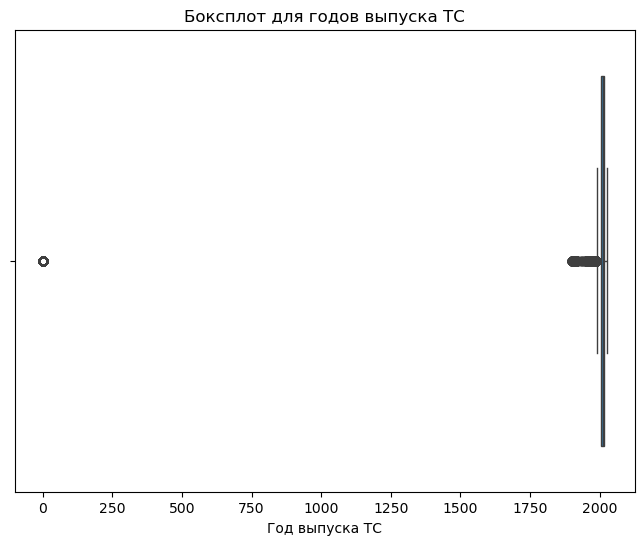

In [285]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='year', data = vehicles_df)
plt.title('Боксплот для годов выпуска ТС')
plt.xlabel('Год выпуска ТС')
plt.show()

Года выпуска до 1990 г определяются как выбросы. Часто за выбросы принимают значения, лежащие ниже 1-го и выше 99-го перцентиля. Найдем 1-й перцентиль:

In [286]:
percentile_1 = np.percentile(vehicles_df['year'], 1)
percentile_1

np.float64(1985.0)

Удалим записи с аномальным годом выпуска транспортного средства (все, что ниже 1-го перцентиля):

In [287]:
vehicles_df = vehicles_df.query('year>=@percentile_1').copy()

#### 2.2.7. Обработка дубликатов датасета `participants_df`

Проверим наличие дубликатов:

In [289]:
print(f'Обнаружено {participants_df.duplicated().sum()} дубликатов')

Обнаружено 148520 дубликатов


Проверим найденные дубликаты:

In [90]:
participants_df[participants_df.duplicated(keep=False)].sort_values(by='id').head(20)

,id,role,gender,violations,health_status,years_of_driving_experience
1846661,3,Водитель,Мужской,,Не пострадал,33.00
1846659,3,Водитель,Мужской,,Не пострадал,33.00
1846677,9,Пассажир,Женский,,"Раненый, находящийся (находившийся) на амбулаторном лечении, либо в условиях дневного стационара",NaN
1846678,9,Пассажир,Женский,,"Раненый, находящийся (находившийся) на амбулаторном лечении, либо в условиях дневного стационара",NaN
1846684,12,Пассажир,Женский,,"Раненый, находящийся (находившийся) на амбулаторном лечении, либо в условиях дневного стационара",NaN
1846686,12,Пассажир,Женский,,"Раненый, находящийся (находившийся) на амбулаторном лечении, либо в условиях дневного стационара",NaN
1846769,54,Пассажир,Мужской,,"Раненый, находящийся (находившийся) на амбулаторном лечении, либо в условиях дневного стационара",NaN
1846770,54,Пассажир,Мужской,,"Раненый, находящийся (находившийся) на амбулаторном лечении, либо в условиях дневного стационара",NaN
1846786,63,Пешеход,Женский,,"Раненый, находящийся (находившийся) на амбулаторном лечении, либо в условиях дневного стационара",NaN
1846787,63,Пешеход,Женский,,"Раненый, находящийся (находившийся) на амбулаторном лечении, либо в условиях дневного стационара",NaN


Видим, что действительно данные дублируются. Удалим дубликаты:

In [91]:
participants_df = participants_df.drop_duplicates()

Проверим уникальные значения по полю `role`:

In [92]:
participants_df['role'].unique().tolist()

['Водитель',
 'Пассажир',
 'Пешеход',
 'Велосипедист',
 'Иной участник',
 'Пешеход, перед ДТП находившийся в (на) ТС в качестве водителя или пешеход, перед ДТП находившийся в (на) ТС в качестве пассажира',
 'Сотрудник ДПС (ГИБДД), выполняющий служебные обязанности на проезжей части (обочине и т.д.)',
 'Сотрудник полиции (кроме ГИБДД), сотрудник (военнослужащий) Росгвардии, Минобороны, ФСБ, ФСО, МЧС и т.д., выполняющий служебные обязанности на проезжей части (обочине и т.д.)',
 'Работник дорожной организации, осуществляющий работы на проезжей части (обочине и т.д.)',
 'Всадник',
 'Лицо, осуществляющее торговлю (иную деятельность) на проезжей части (обочине и т.д.)',
 'Работник иных организаций (коммунальных служб, электросетей, водоканала и т.д.), осуществляющий работы на проезжей части (обочине и т.д.)',
 'Погонщик скота',
 'Лицо, осуществляющее умышленное перекрытие проезжей части']

Проверим уникальные значения по полю `gender`:

In [93]:
participants_df['gender'].unique().tolist()

['Женский', 'Мужской']

#### 2.2.8. Дообогащение данных датасета `vehicles_df`

Добавим информацию о регионе и дате ДТП:

In [94]:
vehicles_df = pd.merge(vehicles_df, general_df[['id', 'region', 'parent_region', 'datetime']], on='id', how='left')

Удалим записи с пропусками после объединеия:

In [95]:
vehicles_df = vehicles_df.dropna(subset=['region','parent_region','datetime'])

Добавим возраст транспортного средства:

In [96]:
vehicles_df['age'] = vehicles_df['datetime'].dt.year - vehicles_df['year']

#### 2.2.9. Дообогащение данных датасета `participants_df`

Добавим информацию о регионе и дате ДТП:

In [98]:
participants_df = pd.merge(participants_df, general_df[['id', 'region', 'parent_region', 'datetime']], on='id', how='left')

Удалим записи с пропусками после объединеия:

In [99]:
participants_df = participants_df.dropna(subset=['region','parent_region','datetime'])

Проверим уникальные значения по полю `violations`:

In [100]:
participants_df['violations'].unique().tolist()

['Выезд на полосу встречного движения',
 '',
 'Управление ТС лицом, не имеющим права на управление ТС',
 'Оставление места ДТП, Несоответствие скорости конкретным условиям движения',
 'Непредоставление преимущества в движении пешеходу, Другие нарушения ПДД водителем',
 'Несоответствие скорости конкретным условиям движения, Эксплуатация ТС с техническими неисправностями, при которых запрещается их эксплуатация',
 'Нарушение правил расположения ТС на проезжей части, Несоблюдение требований ОСАГО, Управление ТС лицом, не имеющим права на управление ТС, Неповиновение или сопротивление находящемуся при исполнении служебных обязанностей сотруднику правоохранительных органов или военнослужащему при остановке или задержании ТС, Отказ водителя, не имеющего права управления ТС либо лишенного права управления ТС от прохождении медицинского освидетельствования на состояние опьянения',
 'Несоответствие скорости конкретным условиям движения',
 'Другие нарушения ПДД водителем',
 'Несоответствие скоро

Заменим пустые строки на "unknown":

In [101]:
participants_df['violations'] = participants_df['violations'].apply(lambda x: 'unknown' if x=="" else x)

Найдем наиболее распространенные виды нарушений и выделим их в отдельные категории.

Напишем функцию для разделения категорий на подкатегории нарушений:

In [102]:
def split_violations(violation):
    # Разделяем строку по запятой, но только если за запятой следует заглавная буква
    parts = re.split(r', (?=[А-Я])', violation)
    return parts

Разобъем описание нарушений на подкатегории:

In [103]:
participants_df['split_violations'] = participants_df['violations'].apply(split_violations)

Преобразуем полученные списки категорий в отдельные строки и получим отдельный датасет с нарушениями:

In [104]:
participants_df = participants_df.explode('split_violations')

Удалим дублирующие столбцы:

In [105]:
participants_df.drop(columns=['violations'], inplace=True)

In [106]:
participants_df.rename(columns={'split_violations':'violations'}, inplace=True)

In [107]:
participants_df.head()

,id,role,gender,health_status,years_of_driving_experience,region,parent_region,datetime,violations
0,1504730,Водитель,Женский,Не пострадал,4.00,Шимский район,Новгородская область,2025-05-01 12:55:00,Выезд на полосу встречного движения
1,1504730,Пассажир,Женский,Не пострадал,NaN,Шимский район,Новгородская область,2025-05-01 12:55:00,unknown
2,1504730,Водитель,Мужской,Скончался на месте ДТП до приезда скорой медицинской помощи,NaN,Шимский район,Новгородская область,2025-05-01 12:55:00,"Управление ТС лицом, не имеющим права на управление ТС"
4,156274,Водитель,Мужской,Не пострадал,13.00,Шимский район,Новгородская область,2022-10-07 20:30:00,Оставление места ДТП
4,156274,Водитель,Мужской,Не пострадал,13.00,Шимский район,Новгородская область,2022-10-07 20:30:00,Несоответствие скорости конкретным условиям движения


Проверим уникальные значения по полю `health_status`:

In [108]:
participants_df['health_status'].unique()

array(['Не пострадал',
       'Скончался на месте ДТП до приезда скорой медицинской помощи',
       'Раненый, находящийся (находившийся) на стационарном лечении',
       'Раненый, находящийся (находившийся) на амбулаторном лечении, либо в условиях дневного стационара',
       'Получил травмы с оказанием разовой медицинской помощи, к категории раненый не относится',
       'Раненый, находящийся (находившийся)  на амбулаторном лечении, либо которому по характеру полученных травм обозначена необходимость амбулаторного лечения (вне зависимости от его фактического прохождения)',
       'Получил телесные повреждения с показанием к лечению в медицинских организациях (кроме разовой медицинской помощи)',
       'Скончался на месте ДТП по прибытию скорой медицинской помощи, но до транспортировки в мед. организацию',
       'Скончался в течение 5 суток', 'Скончался в течение 20 суток',
       'Скончался в течение 3 суток', 'Скончался в течение 11 суток',
       'Скончался на месте ДТП по прибытию

Из данного поля выделим следующие категории:
* скончался
* не пострадал
* получил травмы

In [109]:
def get_health_status(row):
    long_health_status = row['health_status'].lower()
    if 'скончался' in long_health_status:
        return 'Cкончался'
    elif ('раненый' in long_health_status) or ('получил травмы' in long_health_status) or 'телесные повреждения' in long_health_status:
        return 'Получил травмы'
    else:
        return 'Не пострадал'

Создадим столбец с коротким статусом здоровья.

In [110]:
participants_df['health_status_short'] = participants_df.apply(get_health_status, axis=1)

Удалим столбец `health_status`:

In [111]:
participants_df.drop(columns=['health_status'], inplace=True)
participants_df.rename(columns={'health_status_short':'health_status'}, inplace=True)

Проверим уникальные значения по полю `role`:

In [112]:
participants_df['role'].unique().tolist()

['Водитель',
 'Пассажир',
 'Пешеход',
 'Велосипедист',
 'Пешеход, перед ДТП находившийся в (на) ТС в качестве водителя или пешеход, перед ДТП находившийся в (на) ТС в качестве пассажира',
 'Сотрудник ДПС (ГИБДД), выполняющий служебные обязанности на проезжей части (обочине и т.д.)',
 'Иной участник',
 'Сотрудник полиции (кроме ГИБДД), сотрудник (военнослужащий) Росгвардии, Минобороны, ФСБ, ФСО, МЧС и т.д., выполняющий служебные обязанности на проезжей части (обочине и т.д.)',
 'Работник дорожной организации, осуществляющий работы на проезжей части (обочине и т.д.)',
 'Всадник',
 'Лицо, осуществляющее торговлю (иную деятельность) на проезжей части (обочине и т.д.)',
 'Работник иных организаций (коммунальных служб, электросетей, водоканала и т.д.), осуществляющий работы на проезжей части (обочине и т.д.)',
 'Погонщик скота',
 'Лицо, осуществляющее умышленное перекрытие проезжей части']

На основе данного поля создадим поле с короткой ролью участника:
* Водитель
* Пассажир
* Велосипедист
* Пешеход
* Сотрудник ДПС
* Сотрудник полиции или иных органов
* Дорожный рабочий
* Всадник
* Работник иных организаций
* Погонщик скота
* Иной участник

In [113]:
def get_role(row):
    long_role = row['role']
    
    if 'Пешеход' in long_role:
        return 'Пешеход'
    
    elif 'Сотрудник ДПС' in long_role:
        return 'Сотрудник ДПС'
    
    elif 'Сотрудник полиции' in long_role:
        return 'Сотрудник полиции или иных органов'
    
    elif 'Работник дорожной организации' in long_role:
        return 'Дорожный рабочий'

    elif 'Работник иных организаций' in long_role:
        return 'Работник иных организаций'

    elif ('Иной участник' in long_role) or ('Лицо, осуществляющее умышленное перекрытие' in long_role) or ('Лицо, осуществляющее торговлю' in long_role):
        return 'Иной участник'
    
    else:
        return long_role

Создадим столбец с коротой ролью участника:

In [114]:
participants_df['role_short'] = participants_df.apply(get_role, axis=1)

Удалим столбец `role`:

In [115]:
participants_df.drop(columns=['role'], inplace=True)
participants_df.rename(columns={'role_short':'role'}, inplace=True)

### 2.3. Выводы по предобработке данных

В результате предобработки из датасета полученного на предыдущем этапе (с информацией об участниках ДТП) выделены два датасета - с информацией о транспортных средствах и с информацией об участниках - людях.


* **Датасет с общей информацией о ДТП (`general_df`)**
    * Списки в полях `tags`, `nearby`, `weather`, `road_conditions`, `participant_categories` преобразованы в строки
    * удален столбец `tags` (не нес смысловой нагрузки)
    * Поле `point` с координатами места ДТП распарсено в два столбца с широтой и долготой
    * Поле `geometry` удалено, так содержит дублирование информации с координатами места ДТП
    * Поле `address` удалено, так как точный адрес в контесте анализа не представляет интереса, а также есть информация с координатами
    * Пропуски по полю `scheme` заполнены заглушкой "unknown"
    * Пропуски по полям `lat` и `long` удалены
    * Поля `region`, `scheme`, `weather`, `category`, `severity`, `parent_region` приведены к типу category для оптимизации памяти
    * Поля `dead_count`, `injured_count` приведены к типу int8 для оптимизации памяти
    * Поле `datetime` приведено к типу даты-времени
    * Добавлены поля с днем, годом, месяцем и часом возникновения ДТП
    * Добавлены бинарные категориальные признаки освещения в момент ДТП:
        * Светлое время - `light_day`
        * Темное время суток, освещение включено - `dark_light_on`
        * В темное время суток, освещение отсутствует - `dark_no_light`
        * В темное время суток, освещение не включено - `dark_light_off`
        * Сумерки - `twilight`
    * По полю `nearby` унифицировано написание некоторых категорий, также выделены следующие признаки:
        * Признак перекрестка `crossroads`
        * Признак пешеходного перехода `pedestrian_crossing`
        * Признак ЖД переезда `railway_crossing`
        * Признак кругового движения `circular_motion`
        * Признак регулируемости `regulated`
    * На основе поля `weather` добавлены следующие категории:
        * Признак ясной погоды `is_clear`
        * Признак пасмурной погоды `is_cloudy`
        * Признак снегопада `is_snowfall`
        * Признак метели `is_snowstorm`
        * Признак дождя `is_rain`
        * Признак тумана `is_fog`
        * Признак ураганного ветра `is_hurricane`
    * На основе признака `category` добавлены следующие признаки:
        * Признак наезда / столкновения с человеком `is_collision_with_human`
        * Признак наезда / столкновения с велосипедистом `is_collision_with_cyclist`
        * Признак наезда / столкновения с животным `is_collision_with_animal`
        * Признак возгорания `is_fire`
    * На основе признака `road_conditions` добавлены следующие признаки:
        * Признак проблем связанных со снегом и обледенением `ice_troubles`
        * Признак проблем связанных с освещением `light_troubles`
        * Признак проблем связанных с исправностью дорожного покрытия `road_coating_troubles`
        * Признак проблем связанных со светофорами `traffic_lights_troubles`
    * На основе признака `participant_categories` добавлены следующие категории:
        * Признак мотоциклиста `participant_biker`
        * Признак пешехода `participant_pedestrian`
        * Признак велосипедиста `participant_cyclist`
        * Признак общественного транспорта `participant_public_transport`


* **Датасет с информацией о ТС (`vehicles_df`)**

    * Данные с пропусками по году выпуска (`year`) удалили
    * Пропуски марки автомобиля (`brand`) заполним заглушкой "unknown"
    * Пропуски цвета ТС (`color`) заполнили заглушкой "unknown"
    * Пропуски модели ТС (`model`) заполнили заглушкой "unknown"
    * Пропуски категории ТС (`category`) заполним заглушкой "unknown"
    * Привели поле `year` к  типу int16
    * Поля `brand`, `color`, `model`, `category` привели к категориальному типу
    * Удалено 10.6 тыс. дубликатов
    * Записи в поле `color` содержащие "не заполнено" заменены на "unknown"
    * Удалены лишние пробелы в начале или конце строк поля `brand`
    * Удалены записи с аномальным годом выпуска транспортного средства (`year`) - все, что ниже 1-го перцентиля
    * Добалена информация о регионе и дате ДТП
    * Добавлен признак возраста транспортного средства
    * 

* **Датасет с информацией об участниках ДТП (`participants_df`)**

    * Списки в поле `violations` преобразованы в строки
    * Пропуски в поле участника ДТП (`gender`) и статуса здоровья (`health_status`) удалили
    * Пропуски по полю водительского стажа (`years_of_driving_experience`) не заполняли, т.к. не ко всем категориям участников данное поле применимо, а также заполнение его может исказить данные.
    * Поле `years_of_driving_experience` привели к типу float16
    * Поля `role`, `gender` приведены к категориальному типу
    * Обнаружено и удалено 148.5 тыс. дубликатов
    * Добалена информация о регионе и дате ДТП
    * Пустые строки в `violations` заменены на "unknown"
    * Поле `violations` содержало информацию о перечне зафиксированных нарушений для каждого участника - разбили данное поле на отдельные нарушения по каждому участнику - датасет увеличился "в длину", так чтобы для каждой записи в датасете в поле violations содержалась информация только об одном уникальном нарушении
    * Категории поля `health_status` унифицированы до следующих категорий:
        * скончался
        * не пострадал
        * получил травмы
    * Категории поля `role` унифицированы до следующего перечня ролей участников ДТП:
        * Водитель
        * Пассажир
        * Велосипедист
        * Пешеход
        * Сотрудник ДПС
        * Сотрудник полиции или иных органов
        * Дорожный рабочий
        * Всадник
        * Работник иных организаций
        * Погонщик скота
        * Иной участник

## 3. Исследовательский анализ данных

### 3.1 Общие данные о ДТП

Напишем функцию для описания признаков и визуализации распределений:

In [116]:
def get_bins_number(data, feature):
    '''
    Возвращает оптимальное количество корзин для построения гистограмм
    Параметры:
    data (DataFrame): датасет с данными
    feature (str): имя признака
    '''
    # Определение корзин для данных с большой размерностью
    if (data[feature].max() - data[feature].min()) > np.sqrt(len(data[feature])):
        bin_num = int(np.sqrt(len(data[feature])))
                      
    else:
        bin_num = int(data[feature].max() - data[feature].min() + 1)
    
    return min(bin_num, 50)


def describe_feature(data, kind, feature, hue=None, level=None):
    '''
    Функция для автоматизации описания признаков датасета и визуализации распределений.
    Параметры:
    data (DataFrame): датасет с данными
    kind (str): вид признака - 'categorical_or_discrete' (категориальный/дискретный), 'continuous' (непрерывный)
    feature (str): имя признака
    hue (str): признак для разбивки
    level (Series): парамметр для подсчета среднего уровня
    '''        
    
    # Описание непрерывных данных
    if kind == 'continuous':
        num_bins = get_bins_number(data, feature)
        print(f'Min: {data[feature].min()}')
        print(f'Max: {data[feature].max()}')
        print(f'Среднее: {data[feature].mean():.2f}')
        print(f'Медиана: {data[feature].median():.2f}')
        print(f'Ст. откл-е: {data[feature].std():.2f}')
        
        plt.figure(figsize=(10, 6))
        sns.histplot(data=data, x=feature, hue=hue, bins=num_bins, stat='density', common_norm=False, kde=True, binwidth=1)
        
        for artist in plt.gca().patches:
            artist.set_alpha(0.5)
        
        plt.title(f'Распределение для {feature}')
        plt.xlabel(feature)
        plt.ylabel('Плотность')
        plt.show();
        
    # Визуализация категориальных данных и их связь с оттоком
    if kind == 'categorical_or_discrete':
        
        feature_count = data.groupby(feature).size().reset_index(name='count')
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        # Барплот
        sns.barplot(x=feature,
                    y='count',
                    data=feature_count,
                    ax=axes[0],
                    order=feature_count.sort_values(feature)[feature],
                    palette='muted')
        
        
        axes[0].set_title(f'Распределение {feature}')
        axes[0].set_xlabel(f'{feature}')
        axes[0].set_ylabel('Кол-во')
        axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
        
        # Круговая диаграмма
        axes[1].pie(feature_count['count'], 
                    labels=feature_count[feature], 
                    autopct='%1.1f%%', 
                    startangle=90, 
                    colors=sns.color_palette("muted"))
        
        axes[1].set_title(f'Доли категорий {feature}')
        axes[1].axis('equal')
        
        plt.tight_layout()
        plt.show();

#### 3.1.1. Описательная статистика признаков

В нашем датасете содержатся только дискретные числовые и категориальные признаки.

Отберем интересующие поля для описания:

In [117]:
features_to_describe = ['dead_count','injured_count','participants_count',
                        'month', 'day', 'hour',
                        'light_day', 'dark_light_off', 'dark_no_light',
                        'crossroads', 'pedestrian_crossing', 'railway_crossing',
                        'is_rain', 'is_clear',
                        'circular_motion', 'regulated', 'is_snowfall',
                        'is_snowstorm', 'is_fog', 'is_hurricane',
                        'is_cloudy', 'is_collision_with_human', 'is_collision_with_cyclist',
                        'is_collision_with_animal', 'is_fire', 'ice_troubles',
                        'light_troubles', 'road_coating_troubles', 'traffic_lights_troubles',
                        'participant_biker', 'participant_pedestrian', 'participant_cyclist',
                        'participant_public_transport'
                       ]

Выведем описание данных:

In [118]:
general_df[features_to_describe].describe()

,dead_count,injured_count,participants_count,month,day,hour,light_day,dark_light_off,dark_no_light,crossroads,pedestrian_crossing,railway_crossing,is_rain,is_clear,circular_motion,regulated,is_snowfall,is_snowstorm,is_fog,is_hurricane,is_cloudy,is_collision_with_human,is_collision_with_cyclist,is_collision_with_animal,is_fire,ice_troubles,light_troubles,road_coating_troubles,traffic_lights_troubles,participant_biker,participant_pedestrian,participant_cyclist,participant_public_transport
count,1456071.00,1456071.00,1456071.00,1456071.00,1456071.00,1456071.00,1456071.00,1456071.00,1456071.00,1456071.00,1456071.00,1456071.00,1456071.00,1456071.00,1456071.00,1456071.00,1456071.00,1456071.00,1456071.00,1456071.00,1456071.00,1456071.00,1456071.00,1456071.00,1456071.00,1456071.00,1456071.00,1456071.00,1456071.00,1456071.00,1456071.00,1456071.00,1456071.00
mean,0.11,1.27,2.47,6.84,15.88,13.81,0.63,0.01,0.11,0.35,0.28,0.01,0.05,0.60,0.01,0.16,0.04,0.00,0.00,0.00,0.32,0.28,0.03,0.00,0.00,0.15,0.03,0.02,0.00,0.08,0.29,0.04,0.01
std,0.39,0.90,1.20,3.32,8.78,5.78,0.48,0.09,0.31,0.48,0.45,0.07,0.22,0.49,0.09,0.37,0.20,0.06,0.07,0.01,0.46,0.45,0.18,0.06,0.01,0.36,0.17,0.15,0.05,0.27,0.45,0.19,0.09
min,0.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,1.00,2.00,4.00,8.00,10.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,1.00,2.00,7.00,16.00,15.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.00,1.00,3.00,10.00,23.00,18.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
max,20.00,106.00,168.00,12.00,31.00,23.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


Из данной таблицы видим, что часть созданных признаков в основном состоит из нулей, то есть не несет никакой ценности, удалим их:

In [119]:
general_df = general_df.drop(columns=['railway_crossing', 'circular_motion', 'dark_light_off',
                                     'is_snowstorm', 'is_fog', 'is_hurricane',
                                     'is_collision_with_animal', 'is_fire', 'traffic_lights_troubles',
                                     'light_troubles', 'road_coating_troubles', 'participant_public_transport'])

**Признак `dead_count` (число погибших)**

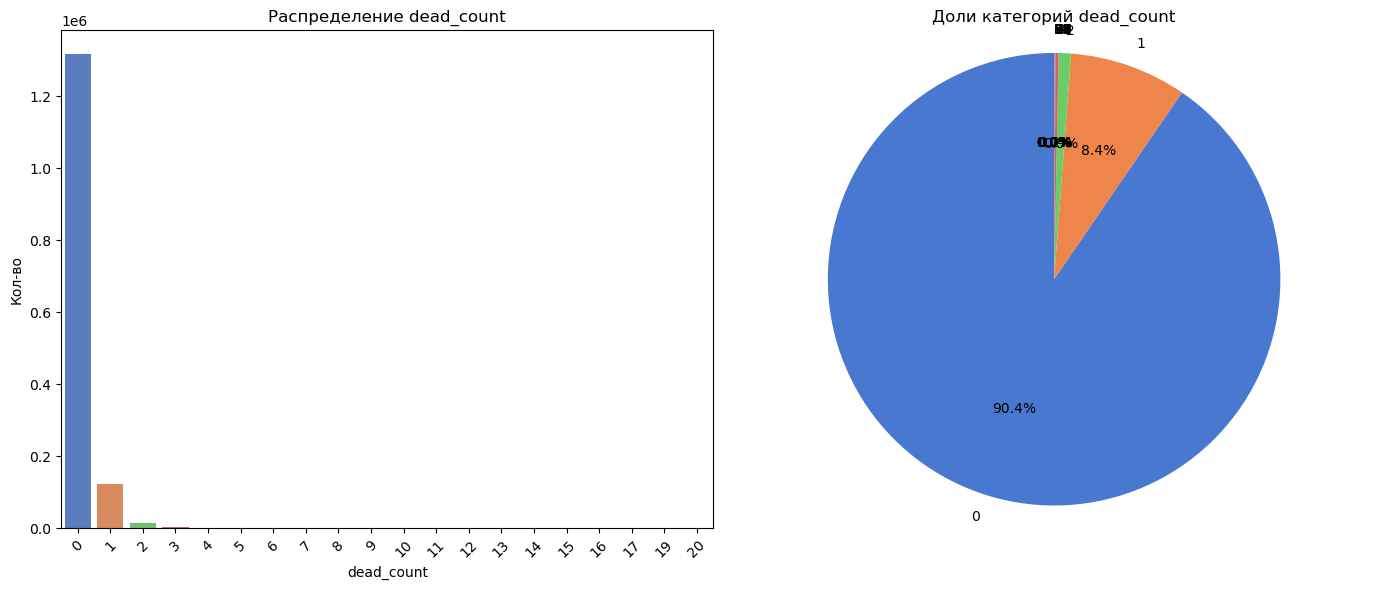

In [120]:
describe_feature(data=general_df, 
                 kind='categorical_or_discrete', 
                 feature='dead_count')

В датасете есть данные о ДТП с количеством погибших от 0 до 20 человек.

* В 90% ДТП нет погибших
* В 8.4% ДТП - 1 погибший

**Признак `injured_count` (число пострадавших)**

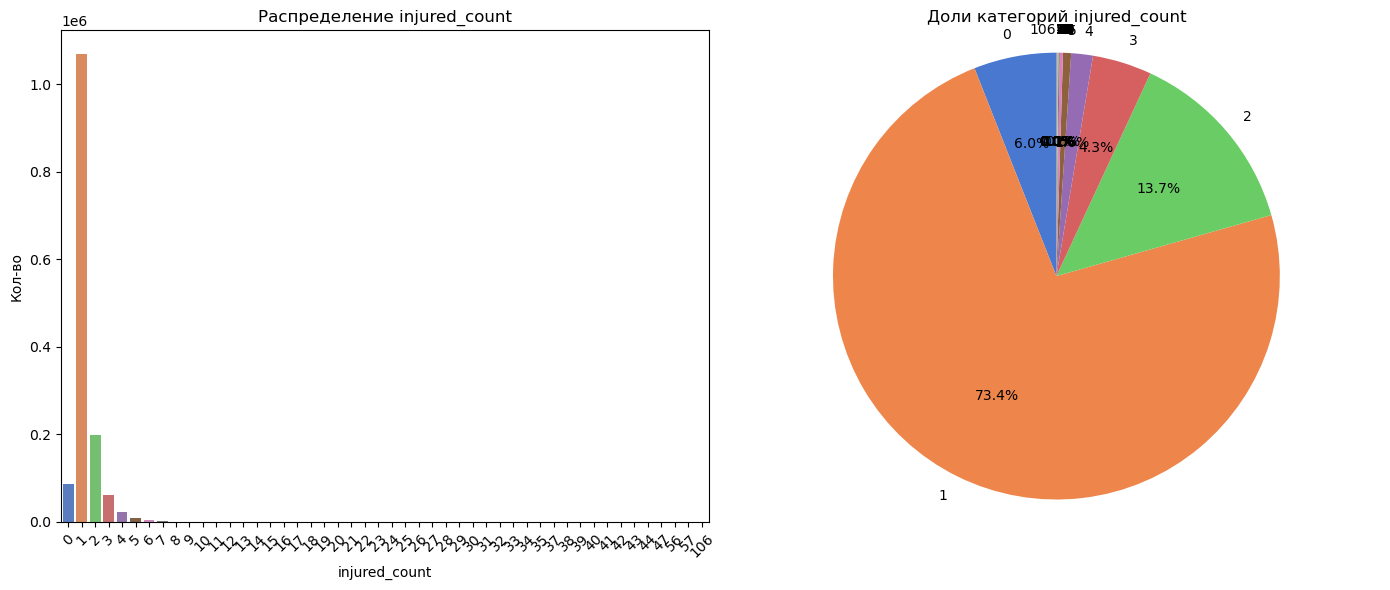

In [121]:
describe_feature(data=general_df, 
                 kind='categorical_or_discrete', 
                 feature='injured_count')

* Количество пострадавших в ДТП варьируется от 0 до 106 человек. Основная часть случаев находится в диапозоне от 0 до 5 человек.
* Чаще всего в результате ДТП оказывается пострадавшим 1 человек - 73% случаев. На втором месте по доли случаев - 2 пострадавших (около 14%)
* в 6% случаев в результате ДТП не оказывается пострадавших

**Признак `participants_count` (число участников)**

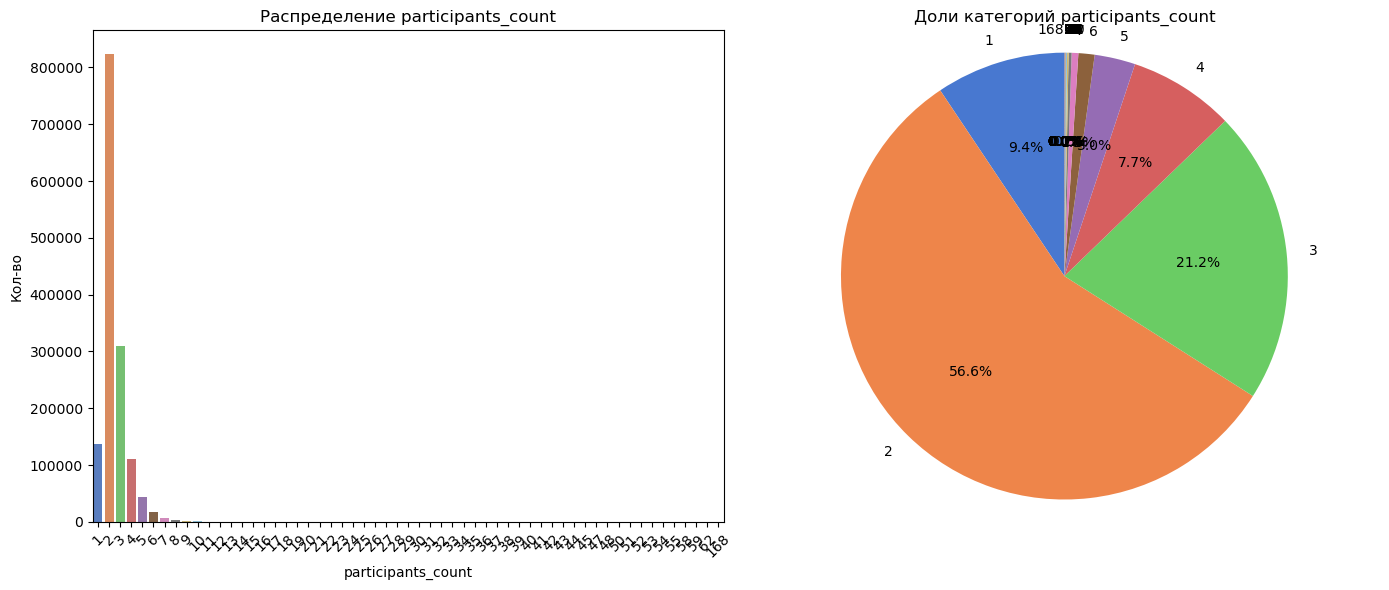

In [122]:
describe_feature(data=general_df, 
                 kind='categorical_or_discrete', 
                 feature='participants_count')

* Количество участников ДТП варьируется от 1 до 168 человек. Основная часть случаев находится в диапозоне от 1 до 6 человек.
* Чаще всего в ДТП 2 участника - 57% случаев. На втором месте по доли случаев - 3 участника (21%)
* в 9% случаев в ДТП 1 участник

**Признак `year` (год ДТП)**

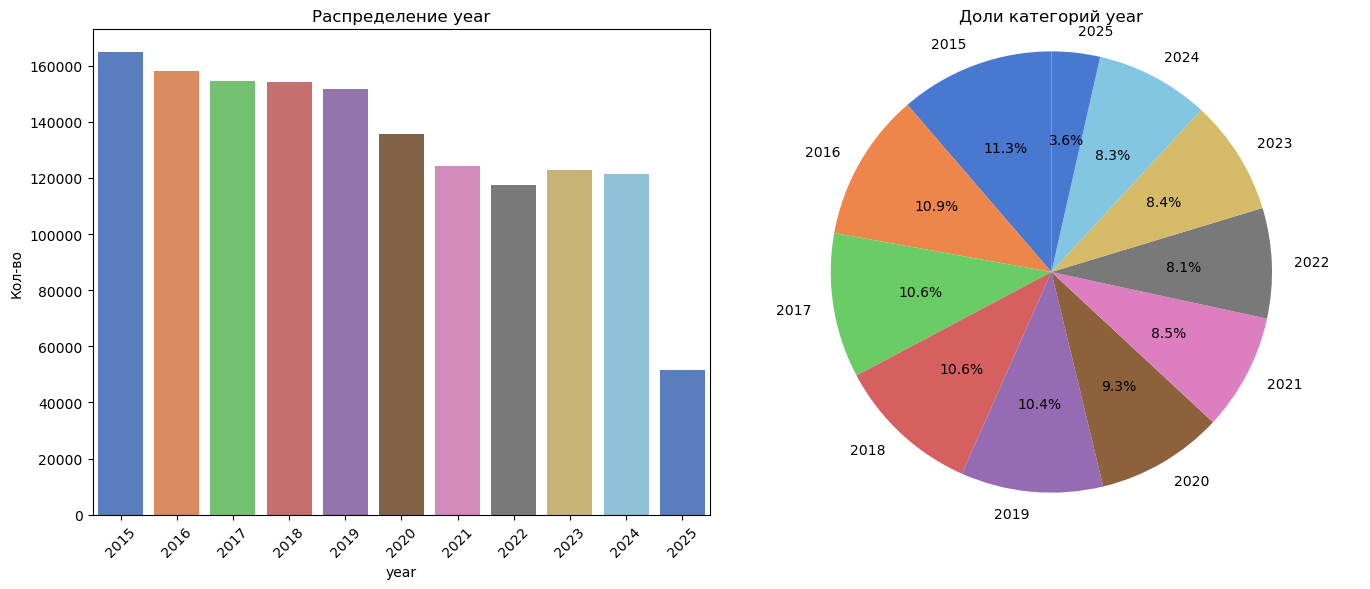

In [123]:
describe_feature(data=general_df, 
                 kind='categorical_or_discrete', 
                 feature='year')

* В датасете представлены данные с 2015 по 2025 г. 2025 - неполный.
* Видна динамика снижения абсолютного количества ДТП, если брать статистику за полные года, то минимальное количество ДТП было в 2022 г.

**Признак `month` (месяц ДТП)**

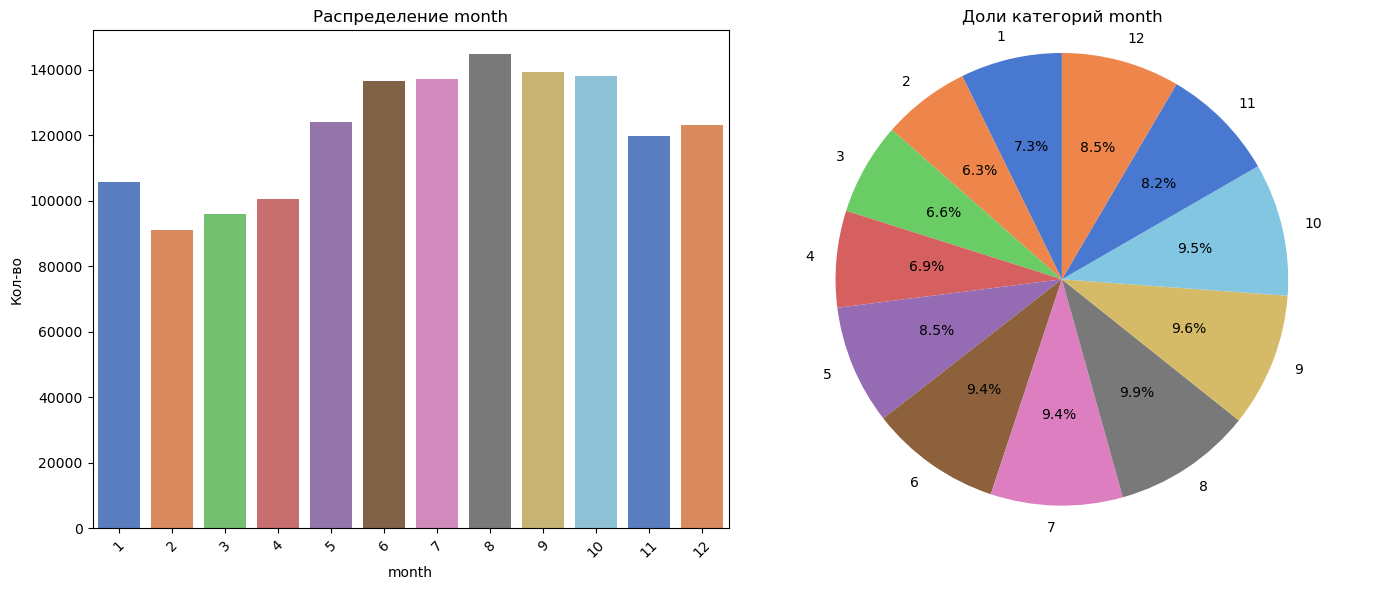

In [124]:
describe_feature(data=general_df, 
                 kind='categorical_or_discrete', 
                 feature='month')

* С мая по октябрь количество ДТП выше чем в другие месяца
* В августе происходит больше всего ДТП.
* Самые "спокойные" месяца - февраль, март, апрель

**Признак `day` (день месяца фиксации ДТП)**

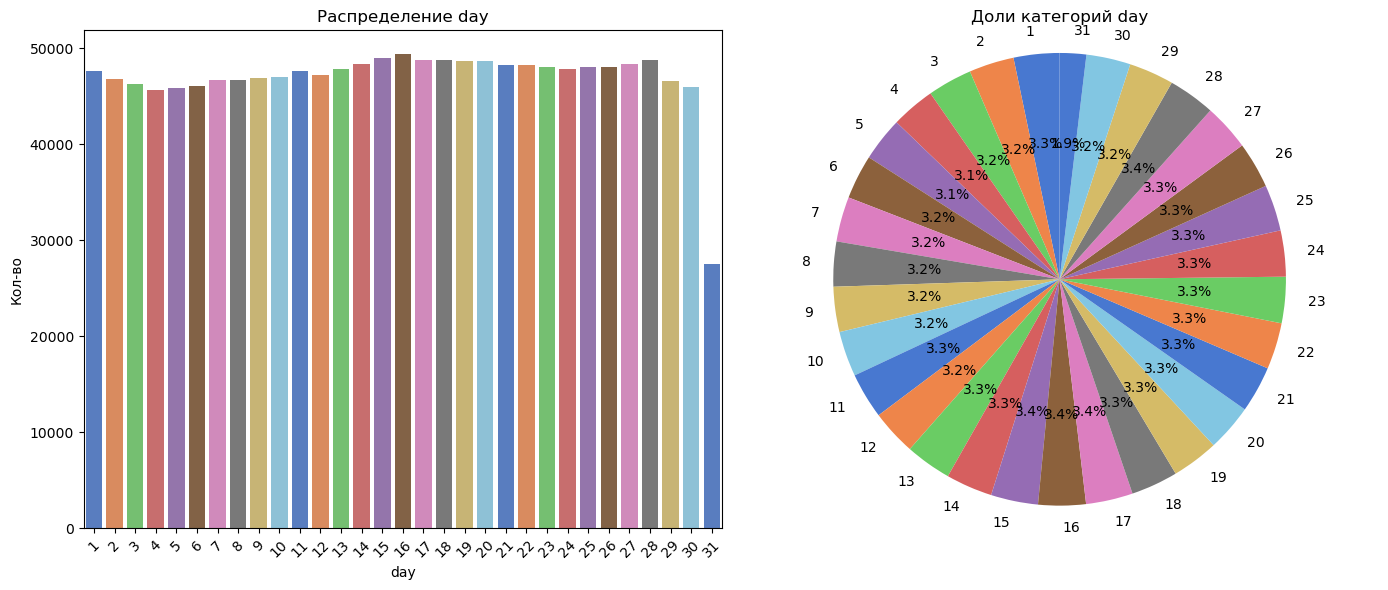

In [125]:
describe_feature(data=general_df, 
                 kind='categorical_or_discrete', 
                 feature='day')

* По количеству ДТП в разбивке по дням месяца каких то значимых закономерностей не наблюдается, количество ДТП по дням распределено достаточно равномерно, за исключением 31-го числа (так как не в каждом месяце есть этот день)

**Признак `hour` (час суток фиксации ДТП)**

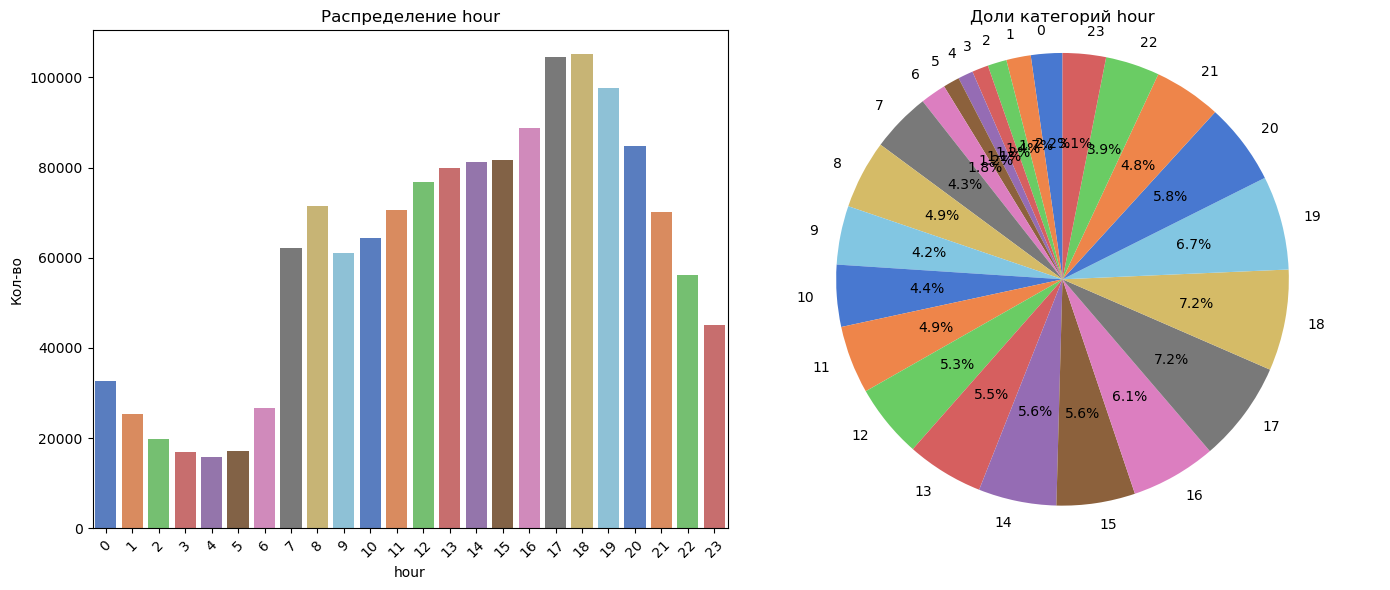

In [126]:
describe_feature(data=general_df, 
                 kind='categorical_or_discrete', 
                 feature='hour')

* В течение дня можно выделить следующие периоды по количеству фиксируемых ДТП:
    * 0-4 часа - Количество ДТП снижается
    * 5-6 часов - начинается рост кол-ва ДТП, видимо за счет того, что люди начинают выезжать на работу (например у кого рабочая смена начинается в 7)
    * 7-8 часов - резкий рост количества ДТП - время когда в основом все люди выезжают на работу / учебу
    * 9-16 часов - после локального пика количества ДТП в 8 часов происходит небольшое снижение количества фиксируемых случаев, и начиная с 9 до 16 часов плавно растет.
    * 17-18 часов - резкий рост относительно 16 часов, пиковое время по количеству фиксируемых ДТП в течение дня. В это время в основном заканчивается работа / учеба - люди выезжают домой или по другим делам. К вечеру накапливается усталость, притупляется внимание, возможно этим можно объяснить пиковые значения количества фиксируемых ДТП.
    * 19-23 часа - количество фиксируемых ДТП быстро снижается, люди добираются до дома, машин становится меньше.
    * Наименьшее количество случаев ДТП - в 4 часа утра.

**Признак `dark_light_on` (ДТП в темное время суток, освещение включено)**

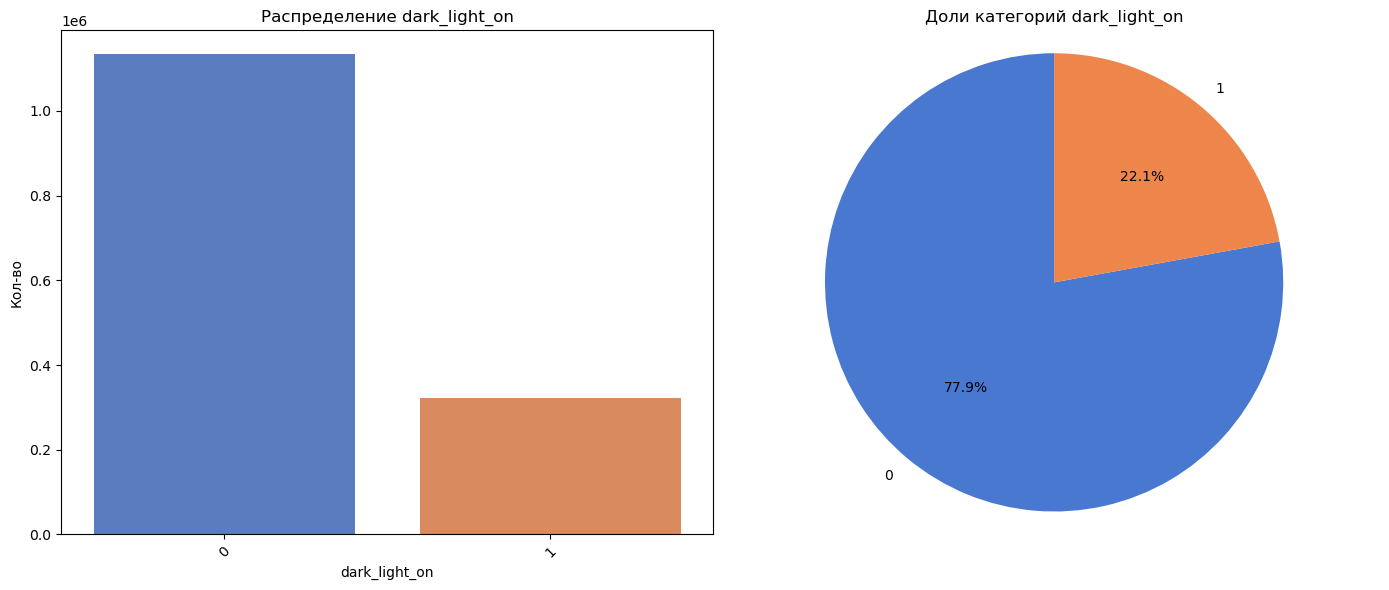

In [127]:
describe_feature(data=general_df, 
                 kind='categorical_or_discrete', 
                 feature='dark_light_on')

* 22% ДТП происходит в темное время суток с включенным освещением

**Признак `light_day` (ДТП в светлое время суток)**

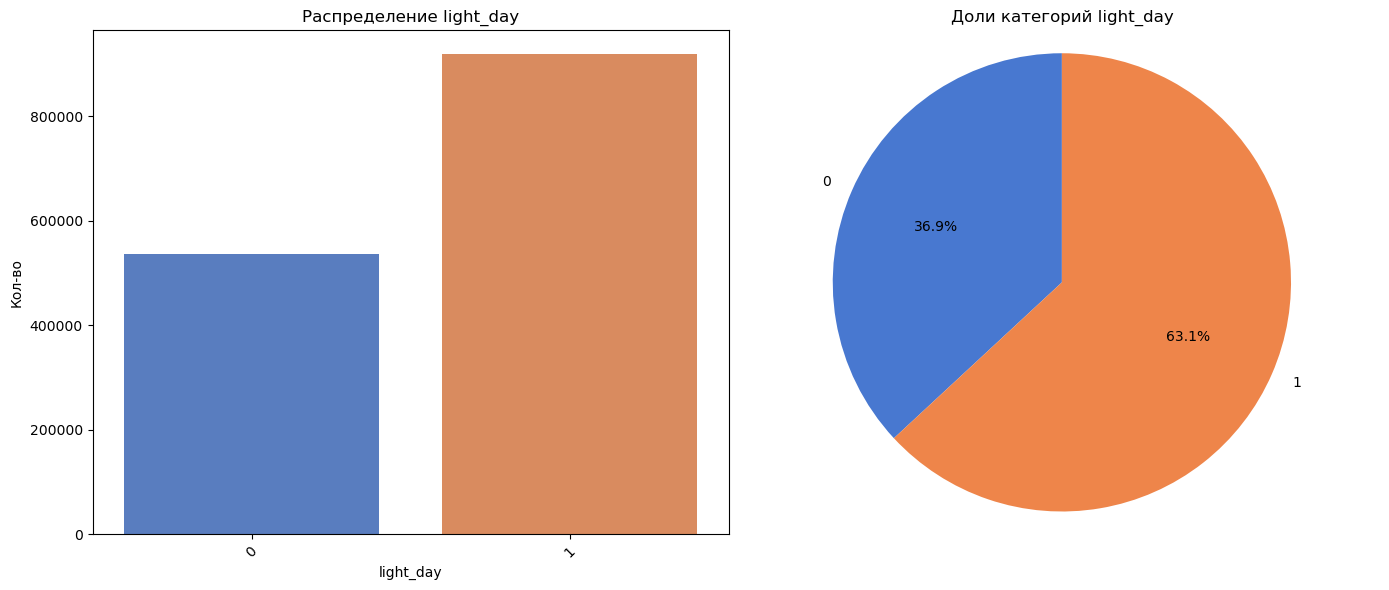

In [128]:
describe_feature(data=general_df, 
                 kind='categorical_or_discrete', 
                 feature='light_day')

* Данный признак частично коррелирует с разбивкой ДТП по часам. 63% ДТП происходят в светлое время суток

**Признак `dark_no_light` (В темное время суток, освещение отсутствует)**

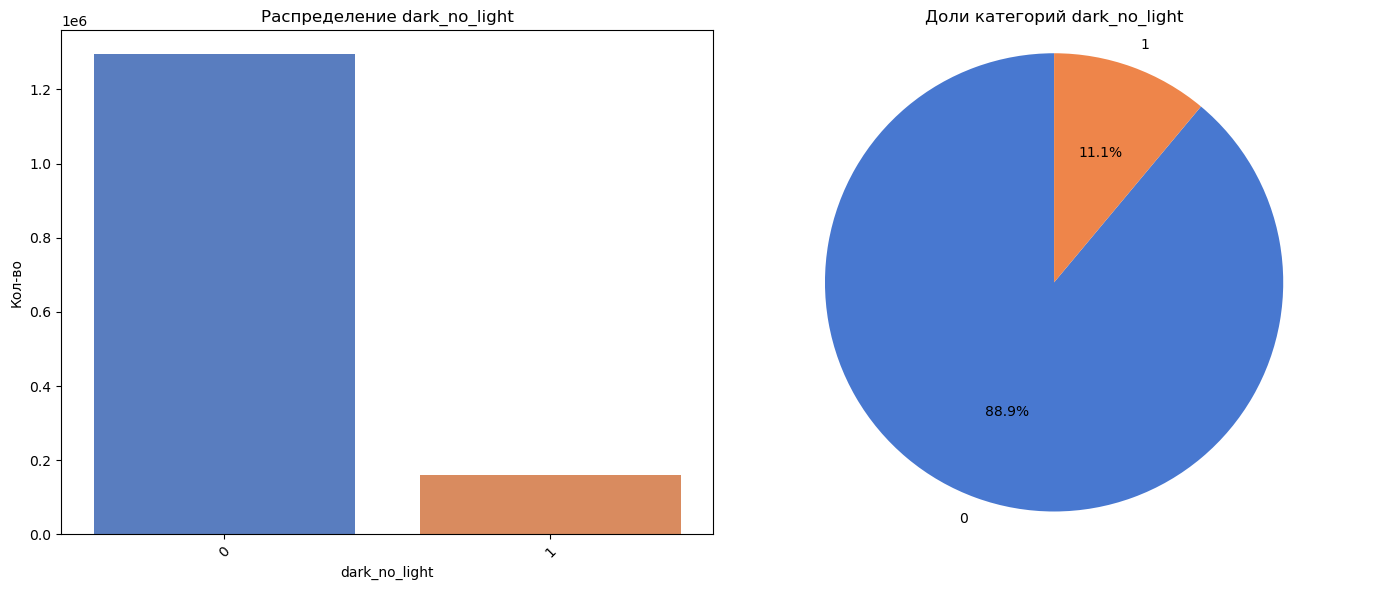

In [129]:
describe_feature(data=general_df, 
                 kind='categorical_or_discrete', 
                 feature='dark_no_light')

* 11% ДТП связано с темным временем суток и отсутствующим освещением.

**Признак `crossroads` (перекресток)**

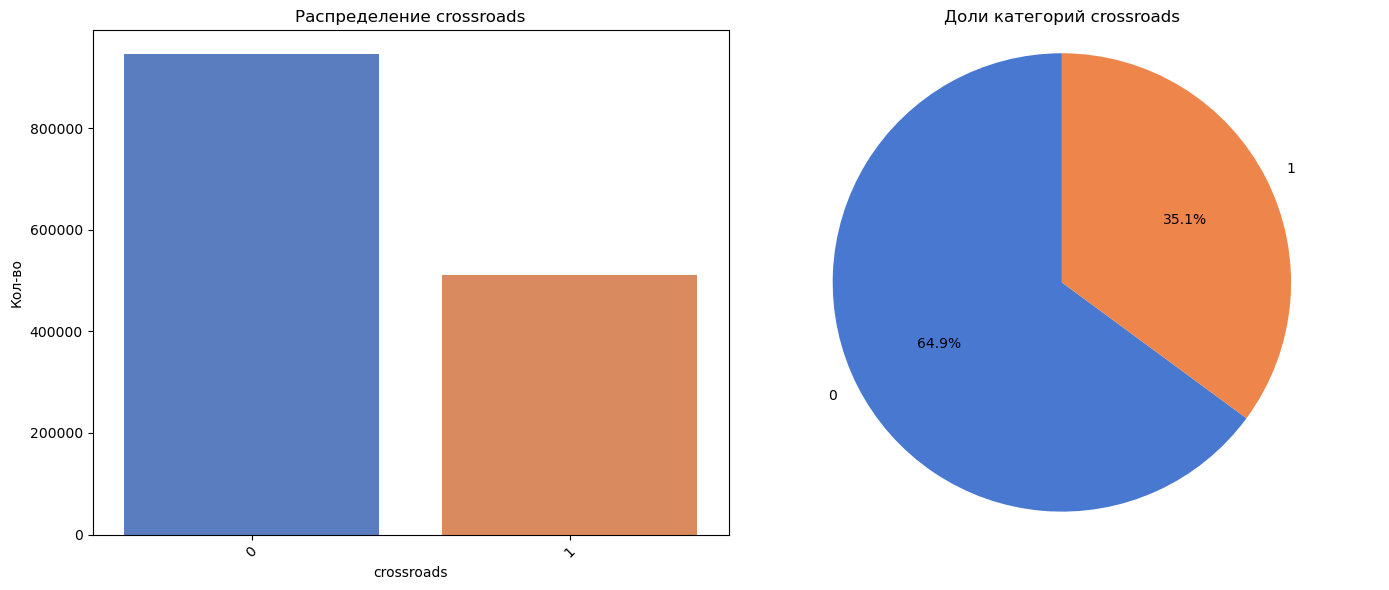

In [130]:
describe_feature(data=general_df, 
                 kind='categorical_or_discrete', 
                 feature='crossroads')

* Перекресток - место повышенной опасности, 35% ДТП происходит на перекрестке или рядом с ним.

**Признак `pedestrian_crossing` (пешеходный переход)**

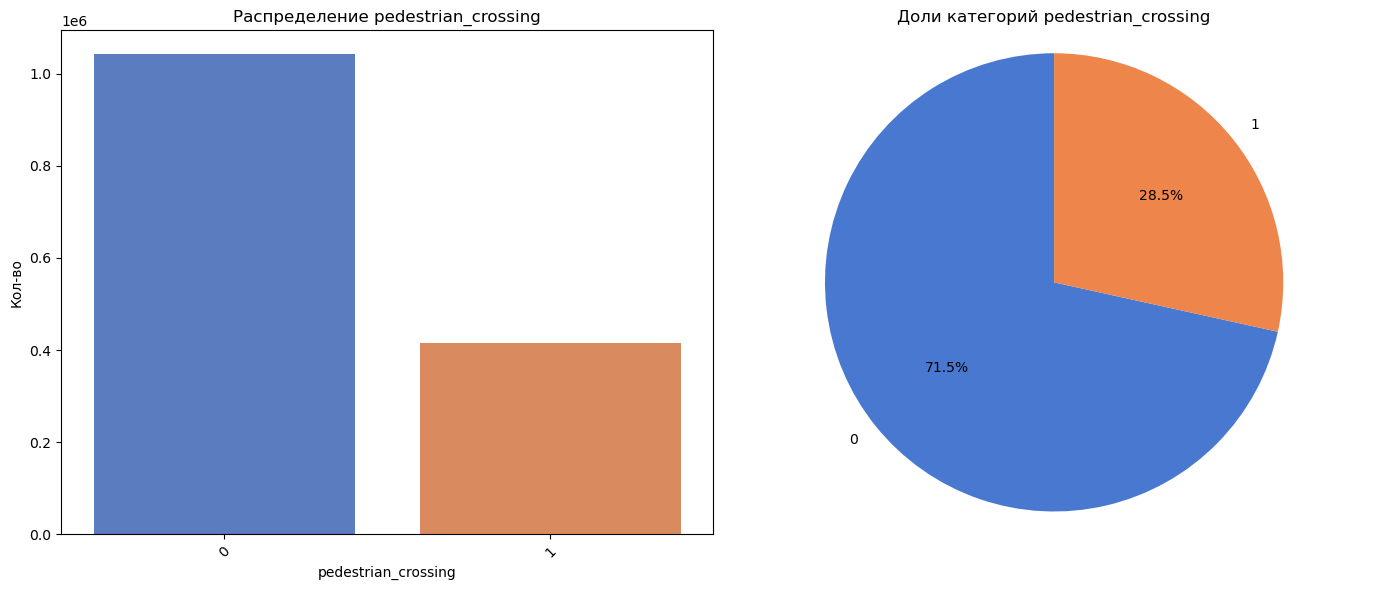

In [131]:
describe_feature(data=general_df, 
                 kind='categorical_or_discrete', 
                 feature='pedestrian_crossing')

* 28% ДТП связано с пешеходными переходами.

**Признак `regulated` (наличие регулирования)**

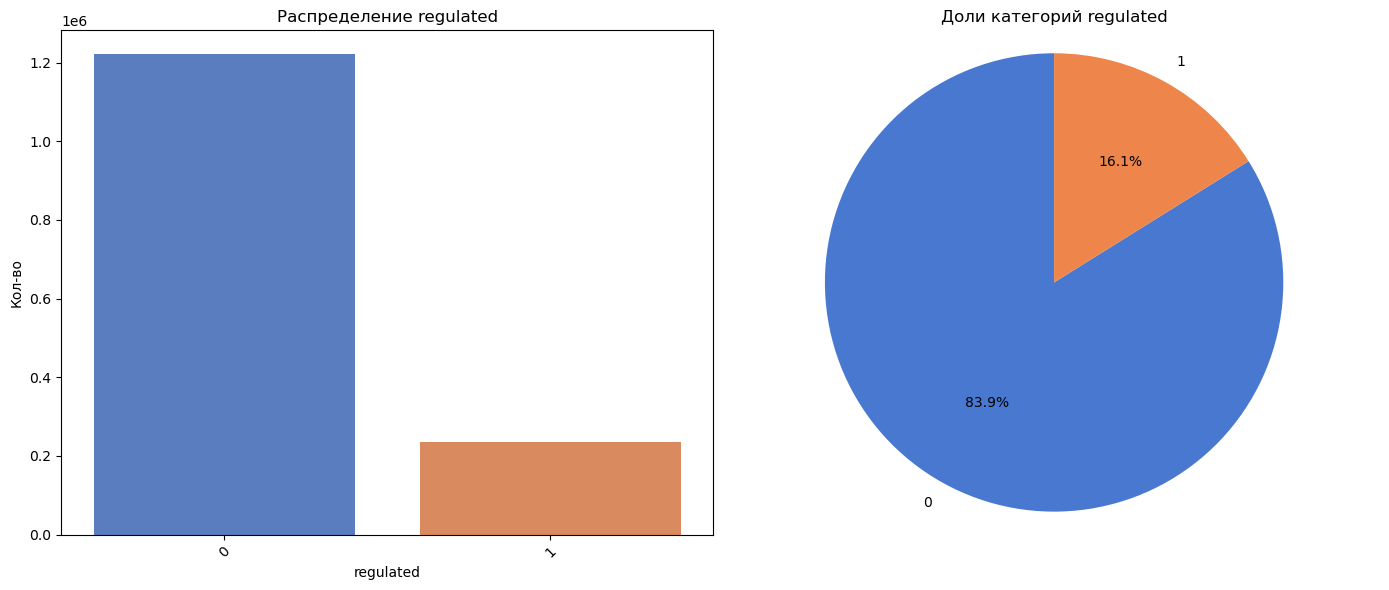

In [132]:
describe_feature(data=general_df, 
                 kind='categorical_or_discrete', 
                 feature='regulated')

* 84% ДТП происходит на нерегулируемых участках дорог, и только 16% - на регулируемых

**Признак `is_clear` (ясная погода)**

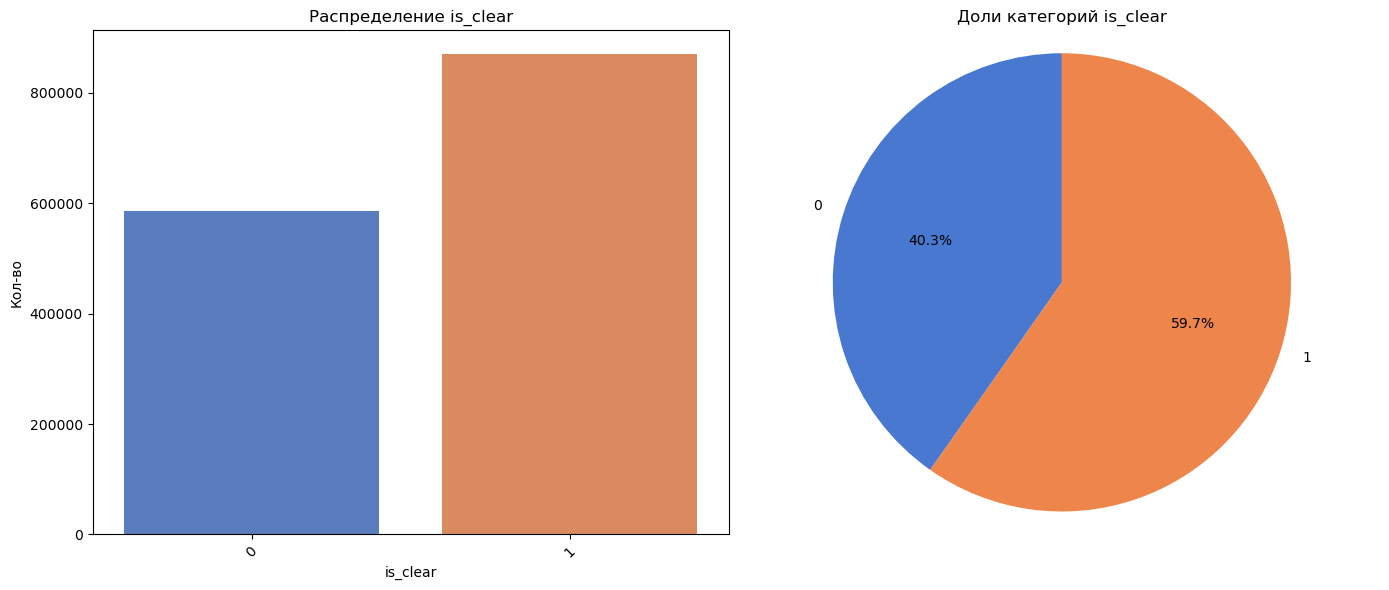

In [133]:
describe_feature(data=general_df, 
                 kind='categorical_or_discrete', 
                 feature='is_clear')

* Почти 60% ДТП происходит в ясную погоду

**Признак `is_rain` (дождь)**

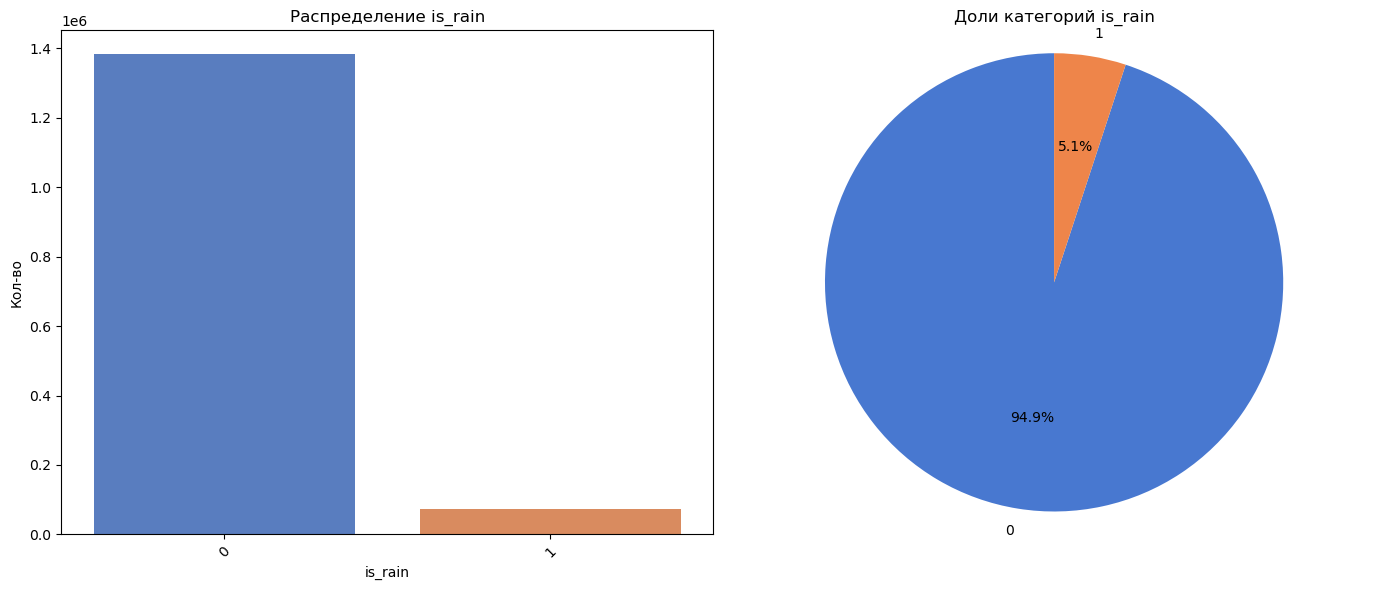

In [134]:
describe_feature(data=general_df, 
                 kind='categorical_or_discrete', 
                 feature='is_rain')

* Только 5% ДТП связано с дождивой погодой

**Признак `is_snowfall` (снегопад)**

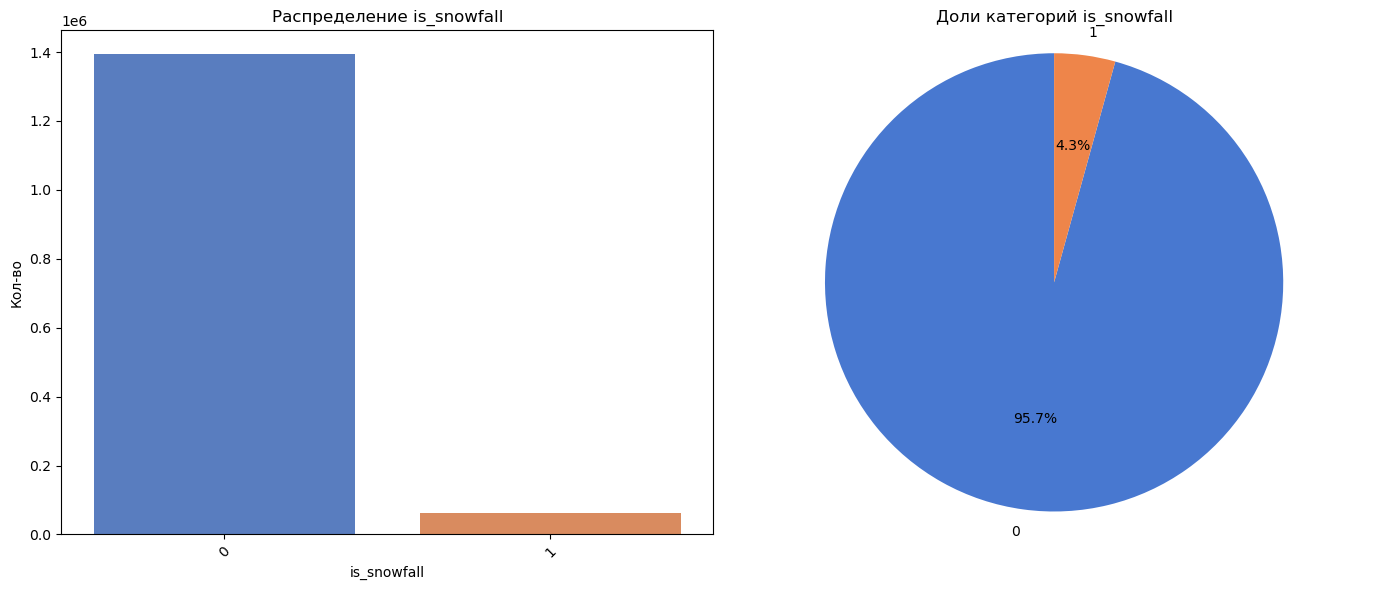

In [135]:
describe_feature(data=general_df, 
                 kind='categorical_or_discrete', 
                 feature='is_snowfall')

* Менее 5% ДТП связано со снегопадом, можно считать данный признак несущественным.

**Признак `is_cloudy` (пасмурная погода)**

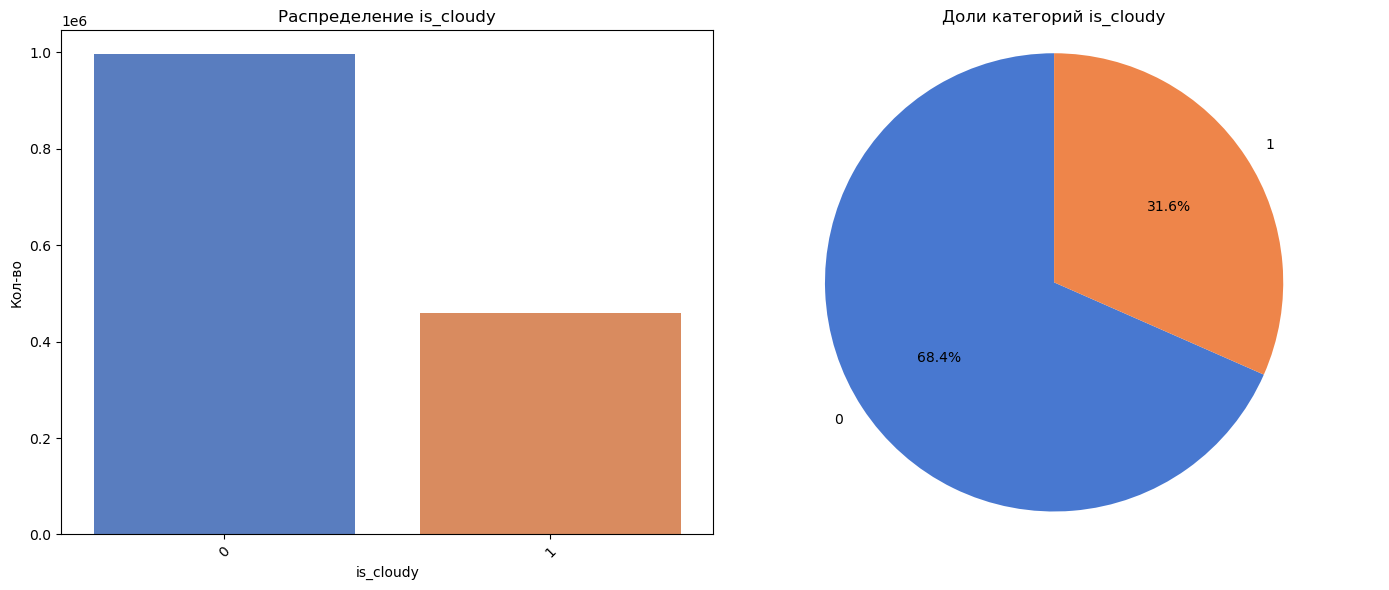

In [136]:
describe_feature(data=general_df, 
                 kind='categorical_or_discrete', 
                 feature='is_cloudy')

* Около 32% ДТП происходит в пасмурную погоду

**Признак `is_collision_with_human` (столкновение с человеком)**

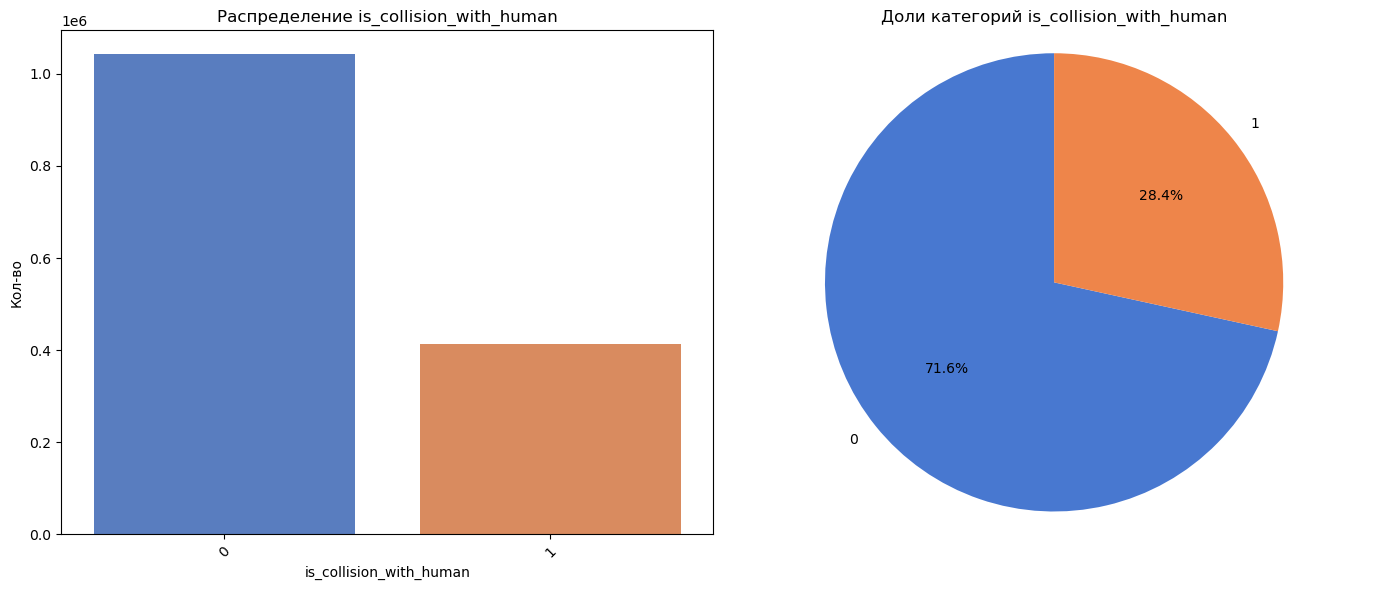

In [137]:
describe_feature(data=general_df, 
                 kind='categorical_or_discrete', 
                 feature='is_collision_with_human')

* 28% ДТП связано со столкновением с человеком

**Признак `is_collision_with_cyclist` (столкновение с велосипедистом)**

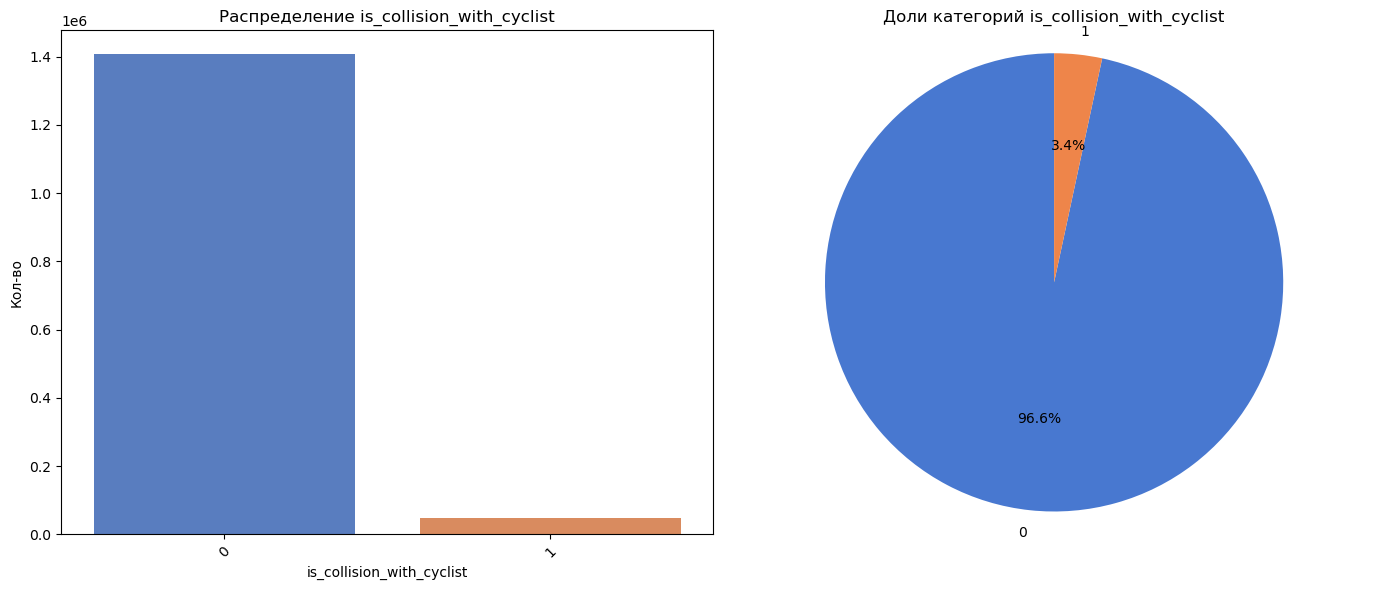

In [138]:
describe_feature(data=general_df, 
                 kind='categorical_or_discrete', 
                 feature='is_collision_with_cyclist')

* Менее 4% ДТП связано со столкновением с велосипедистом

**Признак `ice_troubles` (обледение дорожного покрытия)**

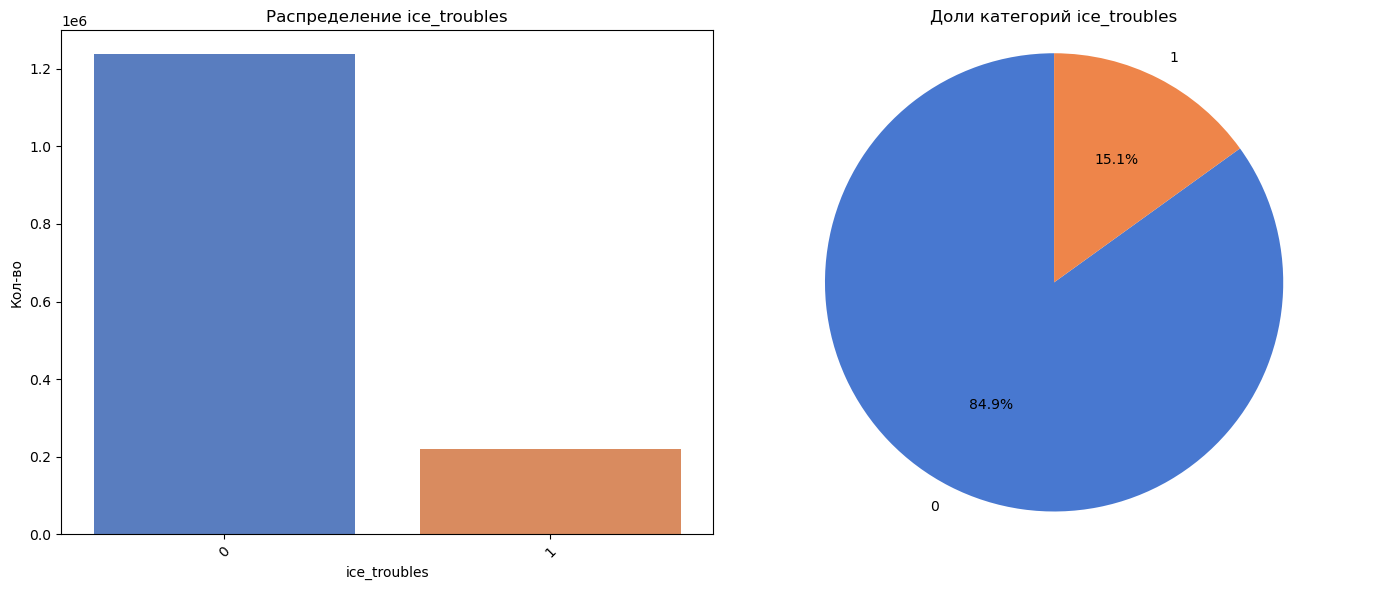

In [139]:
describe_feature(data=general_df, 
                 kind='categorical_or_discrete', 
                 feature='ice_troubles')

* Почти 15% ДТП связано с проблемами обледенения дорожного покрытия (гололед или снежный накат)

**Признак `participant_biker` (участник ДТП - мотоциклист)**

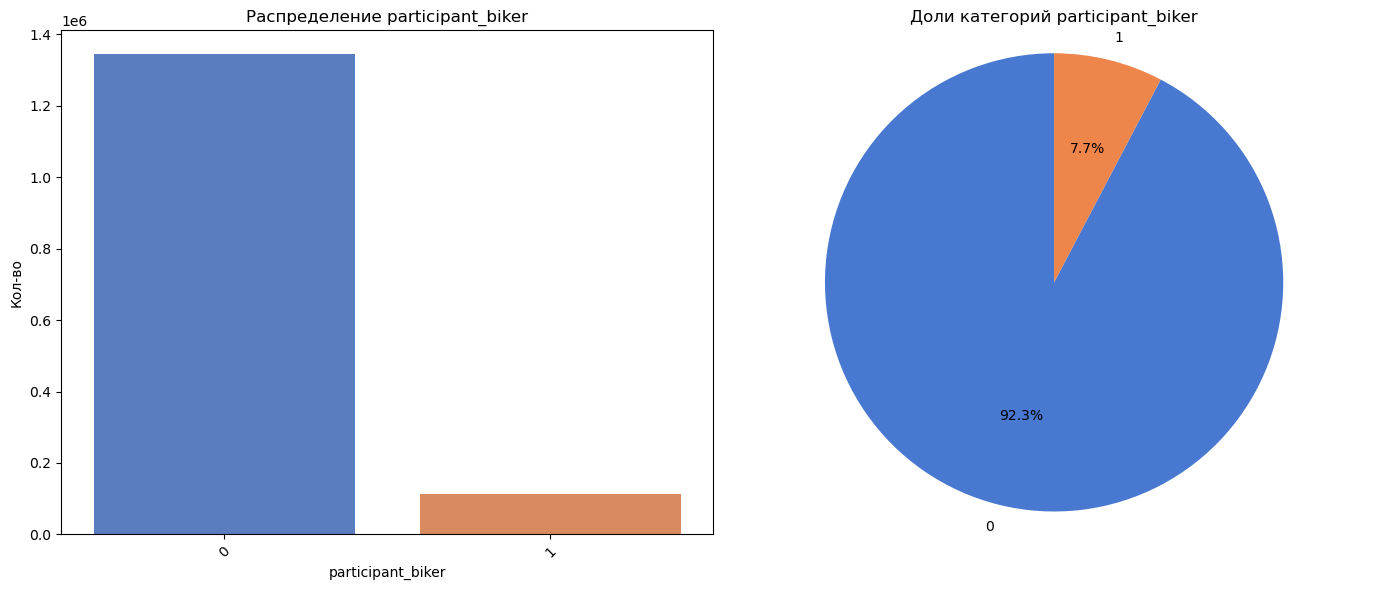

In [140]:
describe_feature(data=general_df, 
                 kind='categorical_or_discrete', 
                 feature='participant_biker')

* В почти 8% ДТП учавствуют мотоциклисты

**Признак `participant_pedestrian` (участник ДТП - пешеход)**

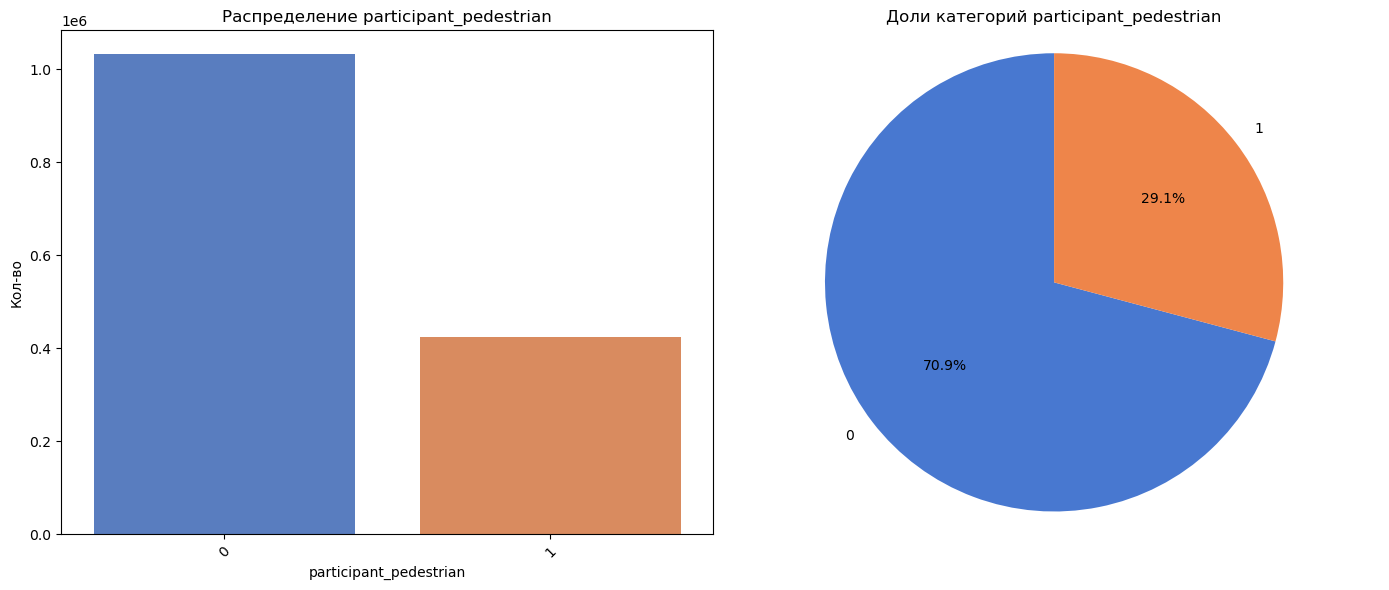

In [141]:
describe_feature(data=general_df, 
                 kind='categorical_or_discrete', 
                 feature='participant_pedestrian')

* В 29% ДТП учавствуют пешеходы

**Признак `participant_cyclist` (участник ДТП - велосипедист)**

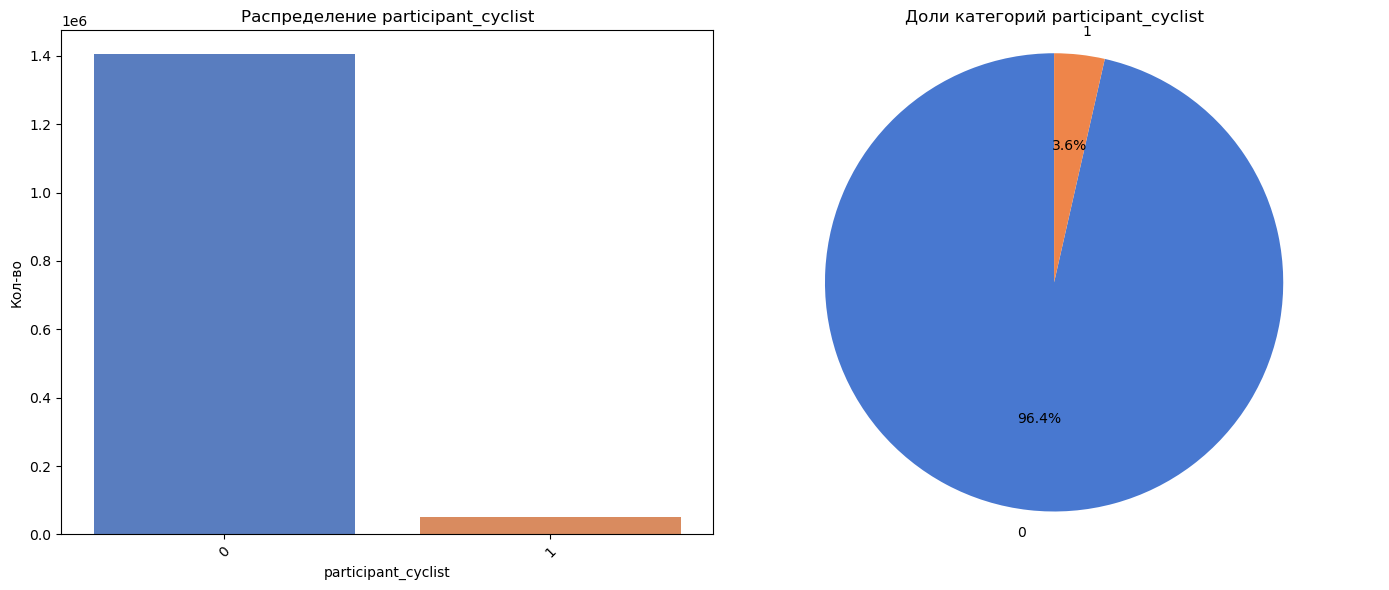

In [142]:
describe_feature(data=general_df, 
                 kind='categorical_or_discrete', 
                 feature='participant_cyclist')

* Менее чем в 4% ДТП участвуют велосипедисты

**Признак `severity` (тяжесть последствий)**

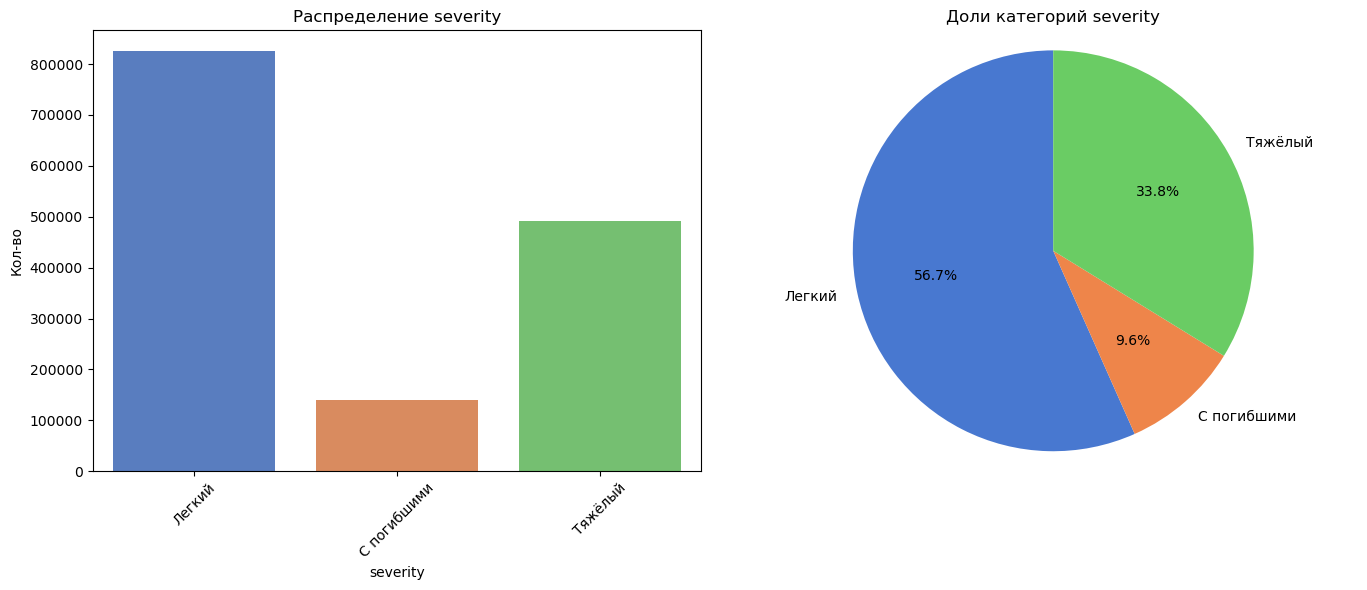

In [143]:
describe_feature(data=general_df, 
                 kind='categorical_or_discrete', 
                 feature='severity')

* 57% ДТП имеют лёгкую тяжесть / последствия для здоровья, около 34% - тяжелые случаи, а чуть менее 10% ДТП заканчиваются летальным исходом.

Выгрузим получившийся датасет для дальнейшей загрузки в базу данных PostgreSQL:

In [144]:
#general_df.to_csv('dtp_general_dataset.csv', index=False)

#### 3.1.2. Выводы по исследовательскому анализу обобщенных данных о ДТП

**Описательная статистика данных**

* **Количество погибших (`dead_count`)**
    * В датасете есть данные о ДТП с количеством погибших от 0 до 20 человек.
    * В 90% ДТП нет погибших
    * В 8.4% ДТП - 1 погибший


* **Количество пострадавших (`injured_count`)**
    * Количество пострадавших в ДТП варьируется от 0 до 106 человек. Основная часть случаев находится в диапозоне от 0 до 5 человек.
    * Чаще всего в результате ДТП оказывается пострадавшим 1 человек - 73% случаев. На втором месте по доли случаев - 2 пострадавших (около 14%)
    * в 6% случаев в результате ДТП не оказывается пострадавших


* **Количество участников (`participants_count`)**
    * Количество участников ДТП варьируется от 1 до 168 человек. Основная часть случаев находится в диапозоне от 1 до 6 человек.
    * Чаще всего в ДТП 2 участника - 57% случаев. На втором месте по доли случаев - 3 участника (21%)
    * в 9% случаев в ДТП 1 участник


* **Год ДТП (`year`)**
    * В датасете представлены данные с 2015 по 2025 г. 2025 - неполный.
    * Видна динамика снижения абсолютного количества ДТП, если брать статистику за полные года, то минимальное количество ДТП было в 2022 г.

* **Месяц ДТП (`month`)**
    * С мая по октябрь количество ДТП выше чем в другие месяца
    * В августе происходит больше всего ДТП.
    * Самые "спокойные" месяца - февраль, март, апрель


* **День ДТП (`day`)**
    * По количеству ДТП в разбивке по дням месяца каких то значимых закономерностей не наблюдается, количество ДТП по дням распределено достаточно равномерно, за исключением 31-го числа (так как не в каждом месяце есть этот день)


* **Час ДТП (`hour`)**
    * В течение дня можно выделить следующие периоды по количеству фиксируемых ДТП:
        * 0-4 часа - Количество ДТП снижается
        * 5-6 часов - начинается рост кол-ва ДТП, видимо за счет того, что люди начинают выезжать на работу (например у кого рабочая смена начинается в 7)
        * 7-8 часов - резкий рост количества ДТП - время когда в основом все люди выезжают на работу / учебу
        * 9-16 часов - после локального пика количества ДТП в 8 часов происходит небольшое снижение количества фиксируемых случаев, и начиная с 9 до 16 часов плавно растет.
        * 17-18 часов - резкий рост относительно 16 часов, пиковое время по количеству фиксируемых ДТП в течение дня. В это время в основном заканчивается работа / учеба - люди выезжают домой или по другим делам. К вечеру накапливается усталость, притупляется внимание, возможно этим можно объяснить пиковые значения количества фиксируемых ДТП.
        * 19-23 часа - количество фиксируемых ДТП быстро снижается, люди добираются до дома, машин становится меньше.
        * Наименьшее количество случаев ДТП - в 4 часа утра.


* **ДТП в светлое время суток (`light_day`)**
    * Данный признак частично коррелирует с разбивкой ДТП по часам. 63% ДТП происходят в светлое время суток

 
* **ДТП В темное время суток, освещение включено (`dark_light_on`)**
    * 22% ДТП происходит в темное время суток с включенным освещением

 
* **ДТП в темное время суток, освещение отсутствует (`dark_no_light`)**
    * 11% ДТП связано с темным временем суток и отсутствующим освещением.
 
* **Перекресток (`crossroads`)**
    * Перекресток - место повышенной опасности, 35% ДТП происходит на перекрестке или рядом с ним.

 
* **Пешеходный переход (`pedestrian_crossing`)**
    * 28% ДТП связано с пешеходными переходами.


* **Регулируемый участок (`regulated`)**
    * 84% ДТП происходит на нерегулируемых участках дорог, и только 16% - на регулируемых.


* **Ясная погода (`is_clear`)**
    * Почти 60% ДТП происходит в ясную погоду

* **Дождь (`is_rain`)**
    * Только 5% ДТП связано с дождивой погодой

* **Снегопад (`is_snowfall`)**
    * Менее 5% ДТП связано со снегопадом, можно считать данный признак несущественным.


* **Пасмурная погода (`is_cloudy`)**
    * Около 32% ДТП происходит в пасмурную погоду.


* **Столкновение с человеком (`is_collision_with_human`)**
    * 28% ДТП связано со столкновением с человеком

 
* **Столкновение с велосипедистом (`is_collision_with_cyclist`)**
    * Менее 4% ДТП связано со столкновением с велосипедистом


* **Обледение дорожного покрытия (`ice_troubles`)**
    * Почти 15% ДТП связано с проблемами обледенения дорожного покрытия (гололед или снежный накат)


* **Участник ДТП - мотоциклист (`participant_biker`)** 
    * В почти 8% ДТП учавствуют мотоциклисты

 
* **Участник ДТП - пешеход (`participant_pedestrian`)** 
    * В 29% ДТП учавствуют пешеходы

 
* **Участник ДТП - велосипедист (`participant_cyclist`)**
    * Менее чем в 4% ДТП участвуют велосипедисты

* **Степень тяжести (`participant_cyclist`)**
    * 57% ДТП имеют лёгкую тяжесть / последствия для здоровья, около 34% - тяжелые случаи, а чуть менее 10% ДТП заканчиваются летальным исходом.

### 3.2 Данные о транспортных средствах

#### 3.2.1. Описательная статистика

Посмотрим описательную статистику для числовых полей:

In [145]:
vehicles_df[['year', 'age']].describe()

,year,age
count,2190926.00,2190926.00
mean,2008.74,10.71
std,7.55,7.31
min,1985.00,0.00
25%,2005.00,5.00
50%,2010.00,10.00
75%,2014.00,15.00
max,2025.00,40.00


**Год выпуска ТС (`year`)**

Для масштаба - отфильтруем ТС с годом выпуска не ранее 1980 г.

Min: 1985
Max: 2025
Среднее: 2008.74
Медиана: 2010.00
Ст. откл-е: 7.55


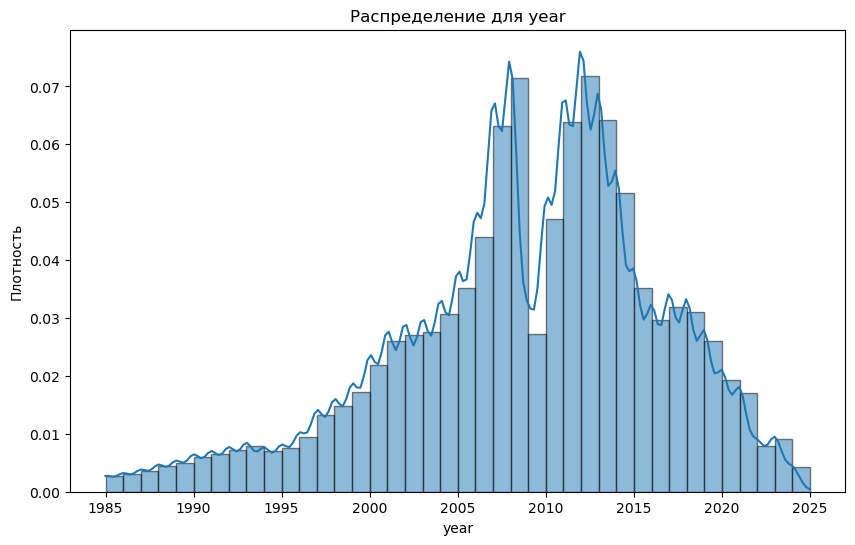

In [146]:
describe_feature(data=vehicles_df.query('year>1980'), 
                 kind='continuous', 
                 feature='year')

* Большая част автомобилей была выпущена в период с 1999 по 2021 г. Также видим два пика - в районе 2008 и в районе 2012 г.

**Возраст ТС на момент ДТП (`age`)**

Для масштаба - отфильтруем ТС с годом выпуска не ранее 1980 г.

Min: 0
Max: 40
Среднее: 10.71
Медиана: 10.00
Ст. откл-е: 7.31


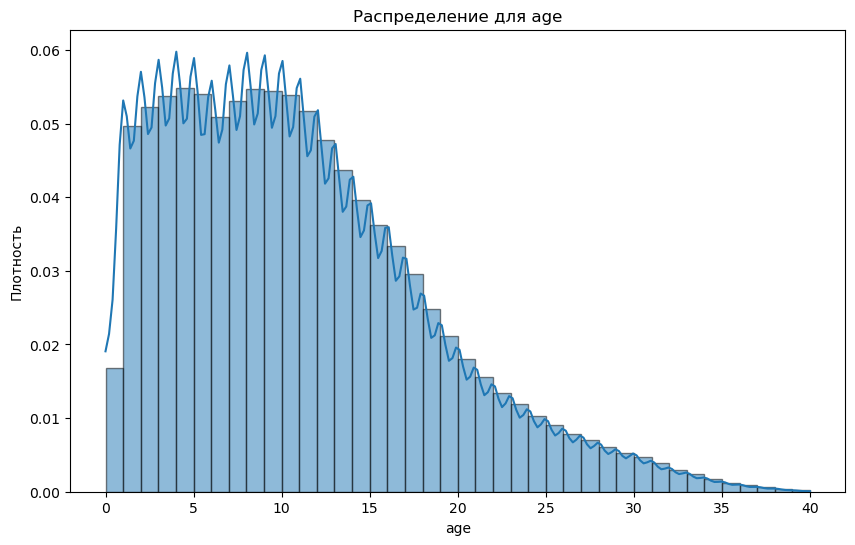

In [147]:
describe_feature(data=vehicles_df.query('year>1980'), 
                 kind='continuous', 
                 feature='age')

* Самый частый возраст ТС на момент ДТП - до 15 лет.

**Цвет ТС (`color`)**

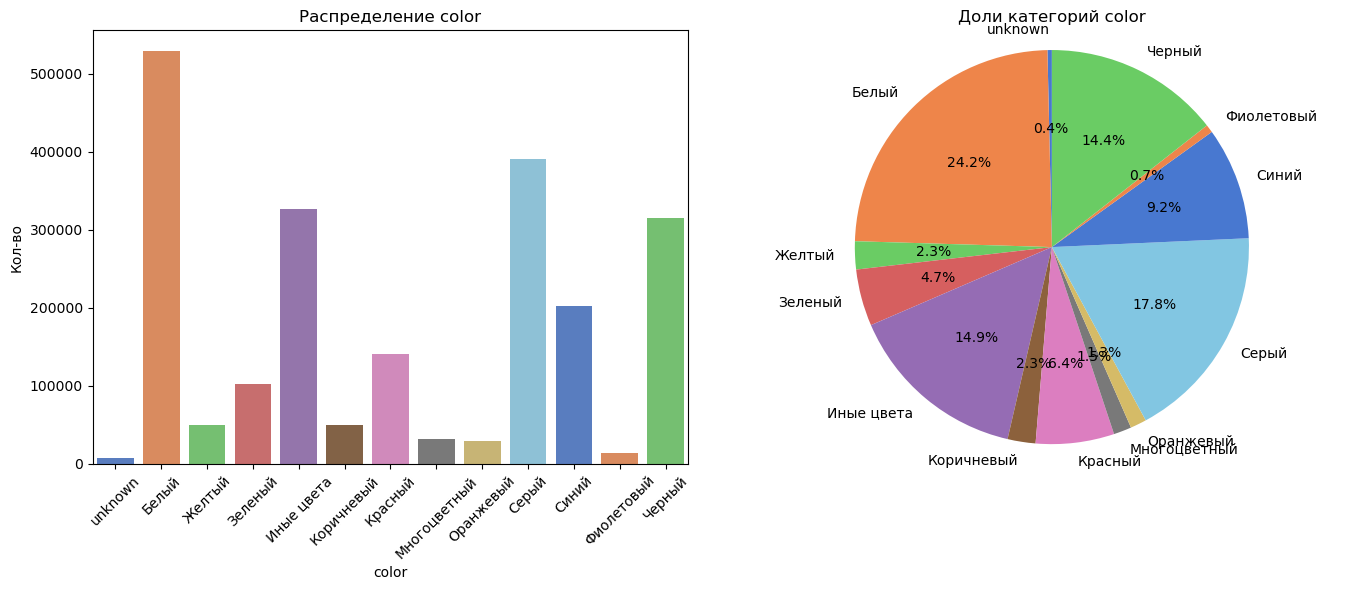

In [148]:
describe_feature(data=vehicles_df, 
                 kind='categorical_or_discrete', 
                 feature='color')

ТОП-3 цвета автомобилей попадающих в ДТП:
* Белый (24%)
* Серый (17.7%)
* Черный (14.4%)

**Бренд и модель ТС (`brand`, `model`)**

Посмотрим топ 10 брэндов ТС попадающих в ДТП:

In [149]:
vehicles_df.groupby(['brand', 'model'])[['id']].agg('count').sort_values(by='id', ascending=False).head(10)

id
brand           model                                    
ВАЗ             Granta (Гранта)                     56204
Прочие марки ТС Прочие марки и модели ТС            55666
ВАЗ             Priora                              49108
HYUNDAI         Solaris                             43144
KIA             Rio                                 42543
ВАЗ             ВАЗ 2114 и модификации              41511
                Жигули  ВАЗ-2108, 09 и модификации  41219
RENAULT         Logan                               39307
ВАЗ             Kalina                              39281
                Жигули  ВАЗ-2107 модификации        38658

* Из топ-10 автомобилей чаще всего попадающих в ДТП - 6 - автомобили марки ВАЗ (Гранта, Приора, 2114, 2108(09), Калина, 2107). Также в топ-10 попали марки наиболее часто встречающиеся в сервисах такси - Хёндэ Солярис, КИА Рио, Рено Логан.

**Категория ТС (`category`)**

In [150]:
vehicles_df.groupby(['category'])[['id']].agg('count').sort_values(by='id', ascending=False)

,id
category,
"В-класс (малый) до 3,9 м",822596
"С-класс (малый средний, компактный) до 4,3 м",390271
Прочие легковые автомобили,171844
"D-класс (средний) до 4,6 м",166121
Мотоциклы,70502
...,...
Полуприцепы-фургоны,3
"Мотонарты, аэросани",3
Прицепы тракторные,3


* Чаще всего в ДТП попадают автомобили B, C, D класса, мотоциклы и прочие легковые автомобили.
* Реже всего в ДТП попадают прицепы и полуприцепы

#### 3.2.1. Выводы по исследовательскому анализу данных о транспортных средствах

* Основная часть автомобилей-участников ДТП была выпущена в период с 1999 по 2021 г.
* Самый частый возраст ТС на момент ДТП - до 15 лет.
* ТОП-3 цвета автомобилей попадающих в ДТП:
    * Белый (24%)
    * Серый (17.7%)
    * Черный (14.4%)
* Из топ-10 автомобилей чаще всего попадающих в ДТП - 6 - автомобили марки ВАЗ (Гранта, Приора, 2114, 2108(09), Калина, 2107). Также в топ-10 попали марки наиболее часто встречающиеся в сервисах такси - Хёндэ Солярис, КИА Рио, Рено Логан.
* Чаще всего в ДТП попадают автомобили B, C, D класса, мотоциклы и прочие легковые автомобили.

Сохраним получившийся датасет для переноса в БД:

In [151]:
#vehicles_df.to_csv('vehicles_data.csv', index=False)

### 3.3 Данные об участниках ДТП

#### 3.3.1. Описатальная статистика

**Роль участника (`role`)**

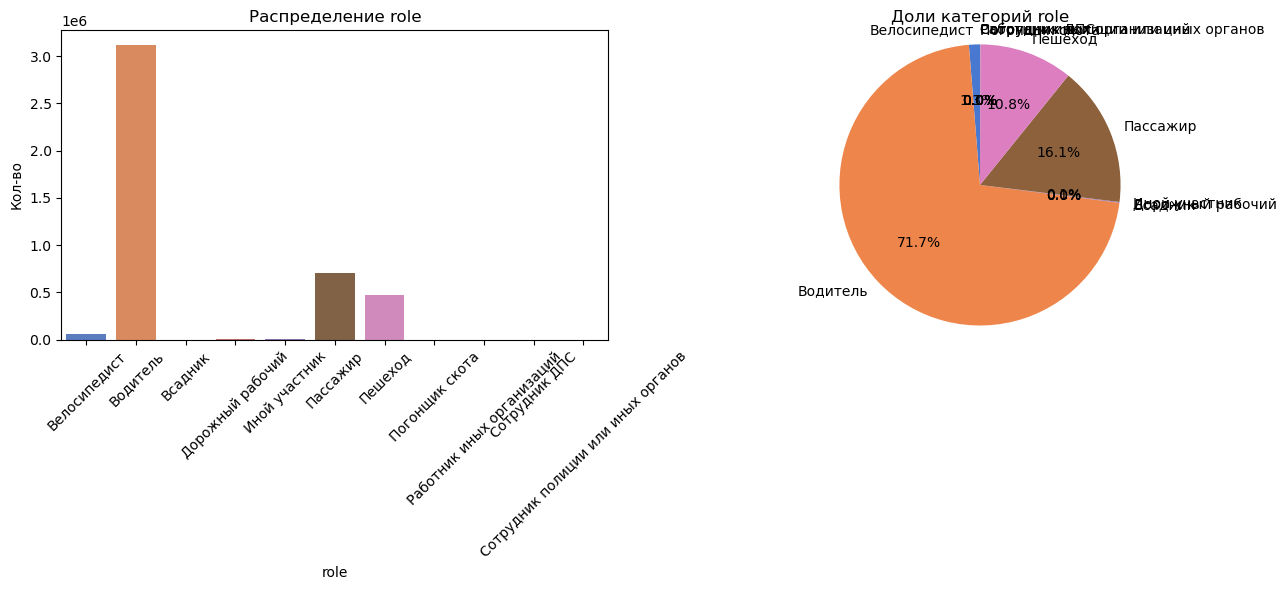

In [152]:
describe_feature(data=participants_df, 
                 kind='categorical_or_discrete', 
                 feature='role')

* Самая частая категория участников ДТП - водитель (72%), на втором месте - пассажир (16%), на третьем - пешеход (около 11%).

**Пол участника ДТП (`gender`)**

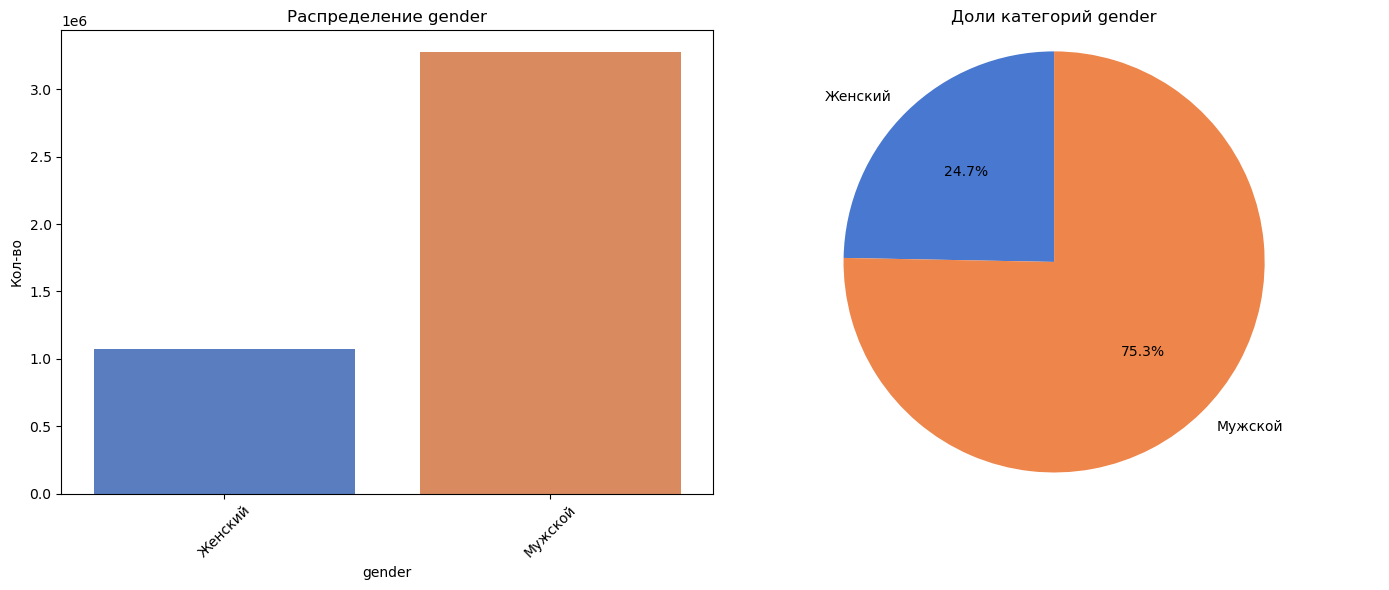

In [153]:
describe_feature(data=participants_df, 
                 kind='categorical_or_discrete', 
                 feature='gender')

* 75% участников ДТП - мужчины

**Водительский стаж участника ДТП (`years_of_driving_experience`)**

Min: 1.0
Max: 74.0
Среднее: nan
Медиана: 12.00
Ст. откл-е: 0.00


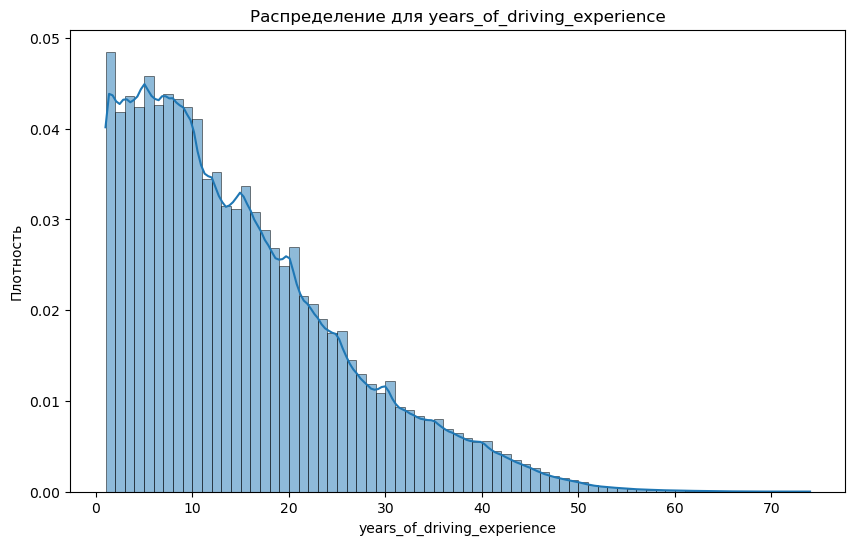

In [154]:
describe_feature(data=participants_df.query('years_of_driving_experience>=0'), 
                 kind='continuous', 
                 feature='years_of_driving_experience')

* Медианный стаж водителя - участника ДТП - 12 лет.

**Категория нарушения ДТП (`violations`)**

Выполним группировку по категориям нарушений и посчитаем их количество, отсортируем по убыванию и добавим столбец с процентом данной категории в общем объеме данных:

In [155]:
violations_df = participants_df.groupby('violations')[['id']].agg('count').sort_values(by='id', ascending=False)

df_size = participants_df.shape[0]
violations_df['share'] = violations_df['id'] / df_size * 100

In [156]:
top20_violations = violations_df.head(20)
top20_violations

,id,share
violations,,
unknown,1675254,38.54
Несоблюдение требований ОСАГО,283997,6.53
Другие нарушения ПДД водителем,222105,5.11
Несоблюдение очередности проезда,198931,4.58
Несоответствие скорости конкретным условиям движения,172400,3.97
Нарушение правил расположения ТС на проезжей части,145885,3.36
Неправильный выбор дистанции,137406,3.16
Нарушение правил проезда пешеходного перехода,124322,2.86
Управление ТС в состоянии алкогольного опьянения,113115,2.60


* У 39% записей в датасете отсутствует отметка о категории нарушения.

Определим перечень неинформативных категорий из ТОП-20:

In [157]:
exclude_list = [
'unknown',
'Другие нарушения ПДД водителем',
'Иные нарушения'
]

Уберем неинформативные категории:

In [158]:
top20_violations = top20_violations.query('violations not in @exclude_list')
top20_violations

,id,share
violations,,
Несоблюдение требований ОСАГО,283997,6.53
Несоблюдение очередности проезда,198931,4.58
Несоответствие скорости конкретным условиям движения,172400,3.97
Нарушение правил расположения ТС на проезжей части,145885,3.36
Неправильный выбор дистанции,137406,3.16
Нарушение правил проезда пешеходного перехода,124322,2.86
Управление ТС в состоянии алкогольного опьянения,113115,2.60
"Управление ТС лицом, не имеющим права на управление ТС",112959,2.60
Выезд на полосу встречного движения,103056,2.37


* Самые популярные категории нарушений:
    * Несоблюдение требований ОСАГО
    * Несоблюдение очередности проезда
    * Несоответствие скорости конкретным условиям движения
    * Нарушение правил расположения ТС на проезжей части
    * Неправильный выбор дистанции

#### 3.3.2. Выводы по исследовательскому анализу данных об участниках ДТП

* Самая частая категория участников ДТП - водитель (72%), на втором месте - пассажир (16%), на третьем - пешеход (около 11%).
* 75% участников ДТП - мужчины
* Медианный стаж водителя - участника ДТП - 12 лет.
* У 39% записей в датасете отсутствует отметка о категории нарушения.
* Самые популярные категории нарушений:
    * Несоблюдение требований ОСАГО
    * Несоблюдение очередности проезда
    * Несоответствие скорости конкретным условиям движения
    * Нарушение правил расположения ТС на проезжей части
    * Неправильный выбор дистанции

Выгрузим датасет с информацией об участниках ДТП для переноса в БД:

In [159]:
#participants_df.to_csv('participants_data.csv', index=False)

## 4. Проверка гипотез

### 4.1. Проверка гипотезы о том, что в ДТП связанных с нарушением скоростного режима в среднем погибает меньше людей, чем в ДТП связанных с употреблением алкоголя или наркотических веществ

К датасету `participants_df` добавим бинарный признак `is_dead` в котором для случаев где погиб участник будем проставлять 1:

In [163]:
participants_df['is_dead'] = participants_df.apply(lambda x: 1 if 'Cкончался' in x['health_status'] else 0, axis=1)

Соберем выборки для определенных случаев. Создадим списки категорий связанных с превышением скорости и с употреблением различных веществ:

In [164]:
speed_violations = ['Несоответствие скорости конкретным условиям движения',
                    'Превышение установленной скорости движения'
                   ]

drugs_violations = ['Отказ водителя, не имеющего права управления ТС либо лишенного права управления ТС от прохождении медицинского освидетельствования на состояние опьянения',
                    'Управление ТС в состоянии алкогольного опьянения',
                    'Управление ТС лицом, находящимся в состоянии алкогольного опьянения и не имеющим права управления ТС либо лишенным права управления ТС (не применяется с 12.2020)',
                    'Отказ водителя от прохождения медицинского освидетельствования на состояние опьянения',
                    'Управление ТС в состоянии наркотического опьянения',
                    'Пешеход в состоянии алкогольного опьянения',
                    'Употребление водителем алкогольных напитков, наркотических, психотропных или иных одурманивающих веществ после дорожно-транспортного происшествия, к которому он причастен, до проведения освидетельствования с целью установления состояния опьянения или до принятия решения об освобождении от проведения такого освидетельствовани',
                    'Управление ТС лицом, находящимся в состоянии алкогольного опьянения и не имеющим права управления ТС либо лишенным права управления ТС',
                    'Передача управления ТС лицу, находящемуся в состоянии опьянения',
                    'Отказ водителя, не имеющего права управления ТС либо лишенного права управления ТС, от прохождения медицинского освидетельствования на состояние опьянения (не применяется с 12.2020)',
                    'Пешеход в состоянии наркотического опьянения',
                    'Управление ТС лицом, находящимся в состоянии наркотического опьянения и не имеющим права управления ТС либо лишенным права управления ТС',
                    'Управление ТС лицом, находящимся в состоянии наркотического опьянения и не имеющим права управления ТС либо лишенным права управления ТС (не применяется с 12.2020)'
                   ]

Отберем `id` ДТП связанных с нарушением скоростного режима:

In [165]:
speed_violations_id_list = participants_df.query('violations in @speed_violations')['id'].unique().tolist()

Добавим признак того, что ДТП связано с нарушением скоростного режима:

In [166]:
general_df['is_speed_violation'] = general_df['id'].isin(speed_violations_id_list).astype(int)

Отберем `id` ДТП связанных с употреблением вещств:

In [167]:
drugs_violations__id_list = participants_df.query('violations in @drugs_violations')['id'].unique().tolist()

Добавим признак того, что ДТП связано с употреблением веществ:

In [168]:
general_df['is_drug_violation'] = general_df['id'].isin(drugs_violations__id_list).astype(int)

Сделаем выборки для теста:

In [169]:
speed_accidents = general_df.query('is_speed_violation==1')['dead_count']
drugs_accidents = general_df.query('is_drug_violation==1')['dead_count']

Напишем функцию проверки выборок на возможность применения t-теста:

In [170]:
def check_samples(sample1, sample2):
    
    print(f'Размер 1-й выборки: {len(sample1)}')
    print(f'Размер 2-й выборки: {len(sample2)}')
    
    if len(sample1) and len(sample2) > 30:
        print('[V] За счет количества данных превышающее 30 наблюдений нормальность выборок не приниципиальна')
    else:
        print('[X] Мало данных - необходимо проверить нормальность')
    
    
    if len(sample1) and len(sample2) > 1000:
        print('[V] Размер выборок достаточно большой')
    else:
        print('[X] Размер выборок недостаточно большой')
    
    
    # Проверка равномерности распределения с помощью теста Колмогорова-Смирнова:
    ks_stat1, p_value1 = stats.kstest(sample1, 'uniform', args=(0, sample1.max()))
    ks_stat2, p_value2 = stats.kstest(sample2, 'uniform', args=(0, sample1.max()))

    if p_value1 > 0.05 and p_value2 > 0.5:
        print('[V] Выборки имеют равномерное распределение')
    else:
        print('[X] Одна или обе выборки распределены неравномерно')
    
    # Проверка однородности дисперсий с помощью теста Левена
    lev_stat, lev_p_value = stats.levene(sample1, sample2)

    if lev_p_value > 0.05:
        print('[V] Дисперсии равны')
    else:
        print('[X] Дисперсии не равны')
    
    plt.figure(figsize=(12, 3))
    plt.subplot(1, 2, 1)
    sns.histplot(sample1, bins=10, kde=True, color='blue', stat='density')
    plt.title('Распределение для выборки 1')

    plt.subplot(1, 2, 2)
    sns.histplot(sample2, bins=10, kde=True, color='orange', stat='density')
    plt.title('Распределение для выборки 2')

    plt.show();

Проверим полученные выборки:

Размер 1-й выборки: 199763
Размер 2-й выборки: 192261
[V] За счет количества данных превышающее 30 наблюдений нормальность выборок не приниципиальна
[V] Размер выборок достаточно большой
[X] Одна или обе выборки распределены неравномерно
[X] Дисперсии не равны


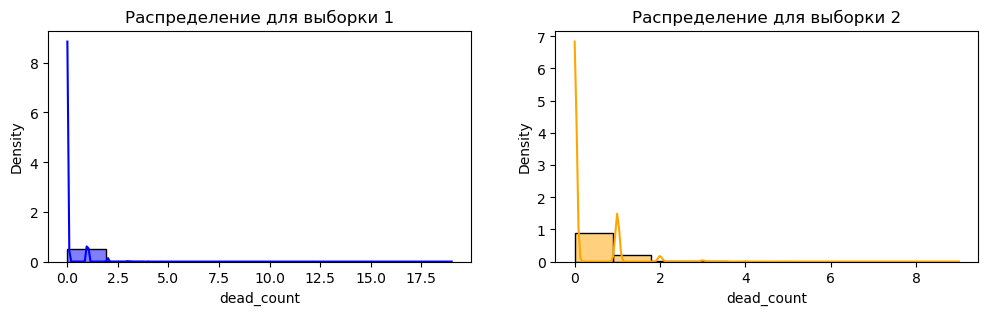

In [171]:
check_samples(speed_accidents, drugs_accidents)

В выборках есть выбросы, также не выполнены два критерия - равномерность и равенство дисперсий. В данном случае t-test не применим.

Для проверки гипотезы будем использовать U-тест Манна-Уитни.

Сформулируем гипотезы:

* **Нулевая гипотеза ($H_0$)**: Среднее количество погибших в ДТП связаннх с нарушением скоростного режима и в ДТП связанных с употреблением алкоголя или наркотических веществ РАВНО.
* **Альтернативная гипотеза ($H_1$)**: Среднее количество погибших в ДТП связаннх с нарушением скоростного режима МЕНЬШЕ чем среднее количество погибших в ДТП связанных с употреблением алкоголя или наркотических веществ.

Зададим пороговое значение alpha:

In [172]:
alpha = 0.05

Проведем тест Манна-Уитни:

In [173]:
stat, p_value = mannwhitneyu(speed_accidents, drugs_accidents, alternative='less')

print(f'Среднее число погибших в ДТП с нарушением скоростного режима: {speed_accidents.mean():.2f}')
print(f'Среднее число погибших в ДТП с употреблением алкоголя или наркотических веществ: {drugs_accidents.mean():.2f}')
print()

print(f'Статистика U-теста: {stat}')
print(f'p-value: {p_value}')
print()

if p_value < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Нет оснований отвергнуть нулевую гипотезу")

Среднее число погибших в ДТП с нарушением скоростного режима: 0.16
Среднее число погибших в ДТП с употреблением алкоголя или наркотических веществ: 0.24

Статистика U-теста: 17914855722.0
p-value: 0.0

Отвергаем нулевую гипотезу


**Гипотеза о том, что в ДТП связанных с нарушением скоростного режима погибает людей меньше, чем в ДТП связанных с употреблением алкоголя или наркотических веществ подтвердилась.**

### 4.2. Проверка гипотезы о том, что в ДТП связанных с употреблением алкоголя или наркотических веществ в среднем погибает людей больше, чем во всех остальных ДТП

Подготовим выборки:

In [174]:
no_drugs_accidents = general_df.query('is_drug_violation==0')['dead_count']

Проверим полученные выборки:

Размер 1-й выборки: 1263810
Размер 2-й выборки: 192261
[V] За счет количества данных превышающее 30 наблюдений нормальность выборок не приниципиальна
[V] Размер выборок достаточно большой
[X] Одна или обе выборки распределены неравномерно
[X] Дисперсии не равны


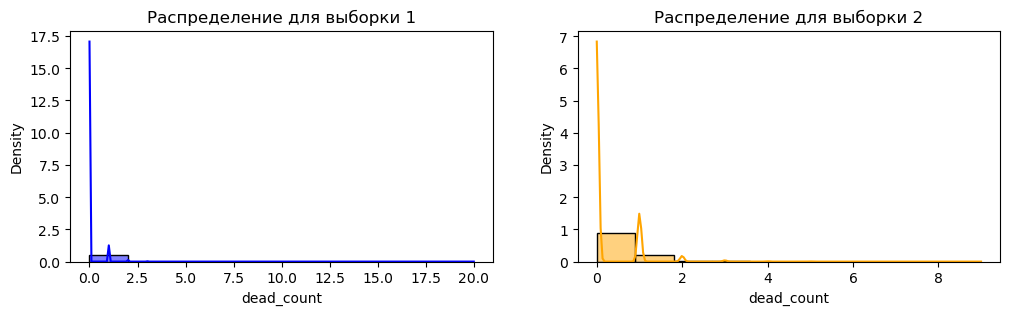

In [175]:
check_samples(no_drugs_accidents, drugs_accidents)

Для проверки гипотезы будем использовать U-тест Манна-Уитни.

Сформулируем гипотезы:

* **Нулевая гипотеза ($H_0$)**: Среднее количество погибших в ДТП связаннх с употреблением алкоголя или наркотических веществ и в ДТП НЕ связанных с употреблением алкоголя или наркотических веществ РАВНО.
* **Альтернативная гипотеза ($H_1$)**: Среднее количество погибших в ДТП ссвязаннх с употреблением алкоголя или наркотических веществ БОЛЬШЕ чем среднее количество погибших в во всех остальных категориях ДТП.

Проведем тест Манна-Уитни:

In [176]:
stat, p_value = mannwhitneyu(drugs_accidents, no_drugs_accidents, alternative='greater')

print(f'Среднее число погибших в ДТП с употреблением алкоголя или наркотических веществ: {drugs_accidents.mean():.2f}')
print(f'Среднее число погибших в ДТП прочих категорий: {no_drugs_accidents.mean():.2f}')
print()

print(f'Статистика U-теста: {stat}')
print(f'p-value: {p_value:}')
print()

if p_value < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Нет оснований отвергнуть нулевую гипотезу")

Среднее число погибших в ДТП с употреблением алкоголя или наркотических веществ: 0.24
Среднее число погибших в ДТП прочих категорий: 0.09

Статистика U-теста: 136355007832.0
p-value: 0.0

Отвергаем нулевую гипотезу


**Подтвердилась гипотеза о том, что в ДТП связанных с употреблением алкоголя и наркотических веществ погибает людей больше, чем в ДТП не связанных с употреблением алкоголя / наркотиков**

### 4.3. Проверка гипотезы о том, что летом в среднем ежедневно происходит большее количество ДТП чем в остальное время года

Подготовим данные с количеством ДТП в разбивке по году, месяцу и дню:

In [177]:
accidents_by_day = general_df.groupby(['year', 'month', 'day'])[['id']].agg('count').reset_index()

Сделаем выборки с ежедневным количеством ДТП для летнего периода и остальной части года:

In [178]:
summer_accidents = accidents_by_day.query('month in (6,7,8)')['id']

other_accidents = accidents_by_day.query('month not in (6,7,8)')['id']

Проверим полученные выборки:

Размер 1-й выборки: 950
Размер 2-й выборки: 2884
[V] За счет количества данных превышающее 30 наблюдений нормальность выборок не приниципиальна
[V] Размер выборок достаточно большой
[X] Одна или обе выборки распределены неравномерно
[X] Дисперсии не равны


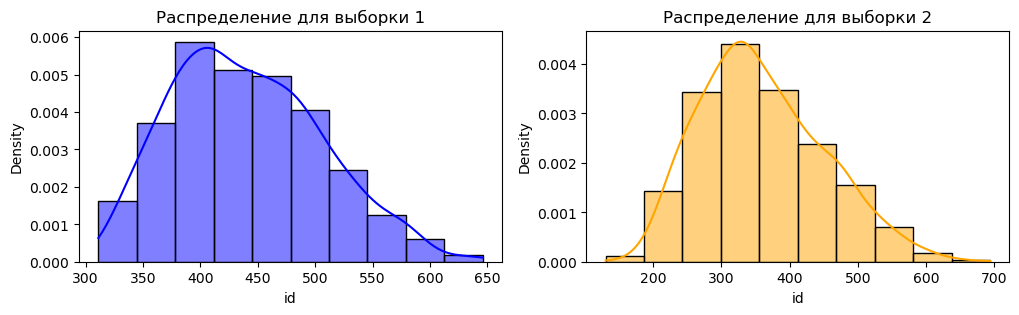

In [179]:
check_samples(summer_accidents, other_accidents)

Требования t-теста по равномерности распределения и равенстве дисперсии не выполняются, будем использовать U-тест Манна-Уитни.

Сформулируем гипотезы:

* **Нулевая гипотеза ($H_0$)**: Среднее ежедневное количество ДТП в летний период и среднее ежедневное количество ДТП в остальную часть года РАВНЫ.
* **Альтернативная гипотеза ($H_1$)**: Среднее ежедневное количество ДТП в летний период БОЛЬШЕ чем среднее ежедневное количество ДТП в остальную часть года.

Проведем тест Манна-Уитни:

In [180]:
stat, p_value = mannwhitneyu(summer_accidents, other_accidents, alternative='greater')

print(f'Среднее ежедневное количество ДТП летом: {summer_accidents.mean():.2f}')
print(f'Среднее ежедневное количество ДТП в остальное время года: {other_accidents.mean():.2f}')
print()

print(f'Статистика U-теста: {stat}')
print(f'p-value: {p_value:}')
print()

if p_value < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Нет оснований отвергнуть нулевую гипотезу")

Среднее ежедневное количество ДТП летом: 440.67
Среднее ежедневное количество ДТП в остальное время года: 359.72

Статистика U-теста: 2100325.5
p-value: 7.819134258672787e-135

Отвергаем нулевую гипотезу


**Подтвердили гипотезу о том, что летом ежедневно происходит ДТП больше, чем в остальное время года.**

### 4.4. Проверка гипотезы о том, что в августе в среднем происходит ДТП больше, чем в другие месяцы года

Сделаем выборки с ежедневным количеством ДТП для августа и остальной части года:

In [181]:
august_accidents = accidents_by_day.query('month==8')['id']
other_month_accidents = accidents_by_day.query('month!=8')['id']

Проверим полученные выборки:

Размер 1-й выборки: 310
Размер 2-й выборки: 3524
[V] За счет количества данных превышающее 30 наблюдений нормальность выборок не приниципиальна
[V] Размер выборок достаточно большой
[X] Одна или обе выборки распределены неравномерно
[X] Дисперсии не равны


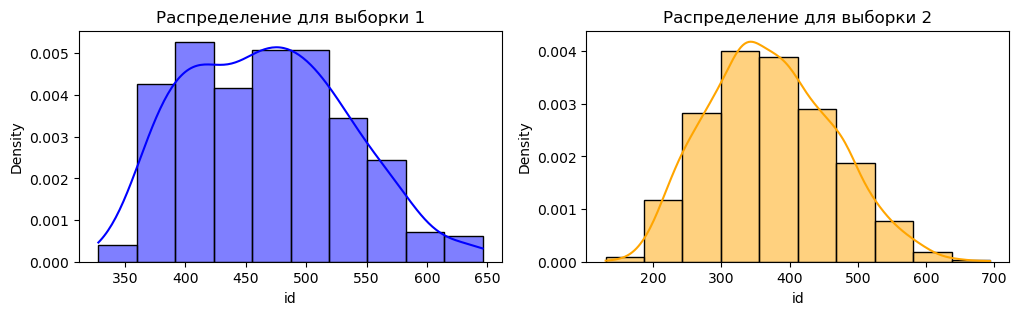

In [182]:
check_samples(august_accidents, other_month_accidents)

Будем использовать U-тест Манна-Уитни.

Сформулируем гипотезы:

* **Нулевая гипотеза ($H_0$)**: Среднее ежедневное количество ДТП в августе и в остальные месяцы года РАВНЫ.
* **Альтернативная гипотеза ($H_1$)**: Среднее ежедневное количество ДТП в августе БОЛЬШЕ чем в остальные месяцы года.

Проведем тест Манна-Уитни:

In [183]:
stat, p_value = mannwhitneyu(august_accidents, other_month_accidents, alternative='greater')

print(f'Среднее ежедневное количество ДТП в августе: {august_accidents.mean():.2f}')
print(f'Среднее ежедневное количество ДТП в остальные месяца года: {other_month_accidents.mean():.2f}')
print()

print(f'Статистика U-теста: {stat}')
print(f'p-value: {p_value:}')
print()

if p_value < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Нет оснований отвергнуть нулевую гипотезу")

Среднее ежедневное количество ДТП в августе: 467.05
Среднее ежедневное количество ДТП в остальные месяца года: 372.10

Статистика U-теста: 870283.5
p-value: 1.100927562091613e-67

Отвергаем нулевую гипотезу


**Подтвердили гипотезу о том, что в августе ДТП происходят чаще, чем в остальные месяцы года.**

### 4.5. Проверка гипотезы о том, что в результате ДТП на перекрестах погибает людей больше, чем на пешеходном переходе

Сделаем выборки ДТП на перекрестках и пешеходных переходах:

In [184]:
crossroads_accidents = general_df.query('crossroads==1')['dead_count']
pedestrian_crossing_accidents = general_df.query('pedestrian_crossing==1')['dead_count']

Проверим полученные выборки:

Размер 1-й выборки: 511046
Размер 2-й выборки: 414354
[V] За счет количества данных превышающее 30 наблюдений нормальность выборок не приниципиальна
[V] Размер выборок достаточно большой
[X] Одна или обе выборки распределены неравномерно
[X] Дисперсии не равны


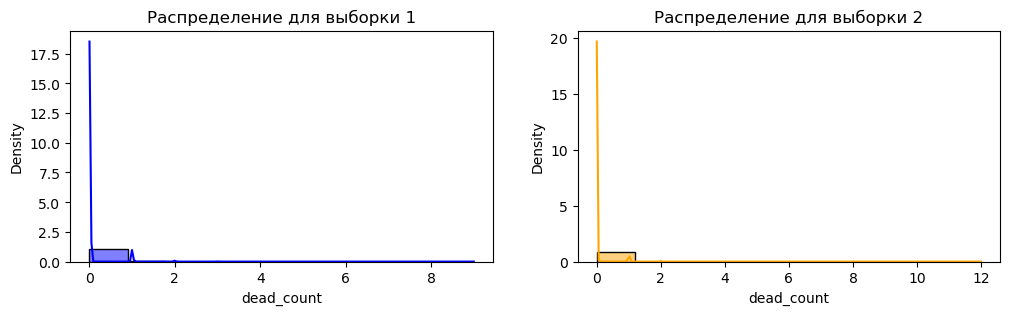

In [185]:
check_samples(crossroads_accidents, pedestrian_crossing_accidents)

Будем использовать U-тест Манна-Уитни.

Сформулируем гипотезы:

* **Нулевая гипотеза ($H_0$)**: Среднее количество погибших в ДТП на перекрестке и в ДТП на пешеходном переходе РАВНЫ.
* **Альтернативная гипотеза ($H_1$)**: Среднее количество погибших в ДТП на перекресткее БОЛЬШЕ чем среднее количество погибших на пешеходном переходе.

Проведем тест Манна-Уитни:

In [186]:
stat, p_value = mannwhitneyu(crossroads_accidents, pedestrian_crossing_accidents, alternative='greater')

print(f'Среднее количество погибших в ДТП на перекрестке: {crossroads_accidents.mean():.5f}')
print(f'Среднее количество погибших в ДТП на пешеходном переходе: {pedestrian_crossing_accidents.mean():.5f}')
print()

print(f'Статистика U-теста: {stat}')
print(f'p-value: {p_value:}')
print()

if p_value < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Нет оснований отвергнуть нулевую гипотезу")

Среднее количество погибших в ДТП на перекрестке: 0.06393
Среднее количество погибших в ДТП на пешеходном переходе: 0.05899

Статистика U-теста: 106029657686.0
p-value: 0.001368740107922424

Отвергаем нулевую гипотезу


Среднее количество погибших для двух рассмотренных случаев оказалось очень близко, но тест показал, что есть статистически значимая разница в среднем количестве погибших в ДТП на перекресте по сравнению со средним количеством погибших на пешеходном переходе.

**Подтвердили гипотезу о том, что в ДТП на перекрестках в среднем погибает людей больше, чем в ДТП на пешеходном переходе.**

### 4.6. Проверка гипотезы о том, что в ДТП с участием автомобилей марки ВАЗ погибает больше людей, чем в ДТП с участием иных марок автомобилей

Отберем `id` ДТП в которых учавствовали автомобили марки ВАЗ:

In [187]:
vaz_accidents_list = vehicles_df.query('brand=="ВАЗ"')['id'].unique().tolist()

К датасету `general_df` добавим признак участия в ДТП автомобиля марки ВАЗ:

In [188]:
general_df['is_vaz'] = general_df['id'].isin(vaz_accidents_list).astype(int)

Подготовим выборки:

In [189]:
vaz_accidents = general_df.query('is_vaz==1')['dead_count']
not_vaz_accidents = general_df.query('is_vaz==0')['dead_count']

Будем использовать U-тест Манна-Уитни.

Сформулируем гипотезы:

* **Нулевая гипотеза ($H_0$)**: Среднее количество погибших в ДТП c участием автомобилей ВАЗ и в ДТП с участием иных марок РАВНЫ.
* **Альтернативная гипотеза ($H_1$)**: Среднее количество погибших в ДТП c участием автомобилей ВАЗ БОЛЬШЕ чем среднее количество погибших в ДТП с участием иных марок.

Проведем тест Манна-Уитни:

In [190]:
stat, p_value = mannwhitneyu(vaz_accidents, not_vaz_accidents, alternative='greater')

print(f'Среднее количество погибших в ДТП с участием а/м ВАЗ: {vaz_accidents.mean():.5f}')
print(f'Среднее количество погибших в ДТП с участием а/м иных марок: {not_vaz_accidents.mean():.5f}')
print()

print(f'Статистика U-теста: {stat}')
print(f'p-value: {p_value:}')
print()

if p_value < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Нет оснований отвергнуть нулевую гипотезу")

Среднее количество погибших в ДТП с участием а/м ВАЗ: 0.12925
Среднее количество погибших в ДТП с участием а/м иных марок: 0.10558

Статистика U-теста: 222590133806.0
p-value: 2.4088032848764433e-149

Отвергаем нулевую гипотезу


**Подтвердили гипотезу о том, что в ДТП с участием а/м ВАЗ погибает людей больше, чем в ДТП с участием иных марок автомобилей.**

### 4.7. Проверка гипотезы о том, что водительский стаж не влияет на смертность в результате ДТП

Подготовим данные по воодителям с указанием водительского стажа:

In [191]:
participants_df['years_of_driving_experience'] = participants_df['years_of_driving_experience'].astype(float)

drivers_experience = participants_df.query('role=="Водитель" and years_of_driving_experience.notna()')

Добавим информацию о количестве погибших в ДТП по `id`:

In [192]:
drivers_experience = pd.merge(drivers_experience, general_df[['id', 'dead_count']], on='id', how='left')

Подготовим выборки:

In [193]:
drivers_with_dead = drivers_experience.query('dead_count>0')['years_of_driving_experience']
drivers_without_dead = drivers_experience.query('dead_count==0')['years_of_driving_experience']

Проверим выборки на предмет возможности использования t-теста:

Размер 1-й выборки: 257511
Размер 2-й выборки: 2279235
[V] За счет количества данных превышающее 30 наблюдений нормальность выборок не приниципиальна
[V] Размер выборок достаточно большой
[X] Одна или обе выборки распределены неравномерно
[X] Дисперсии не равны


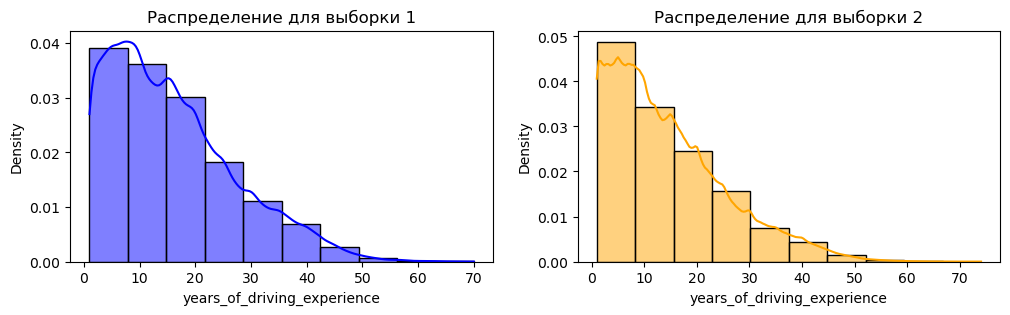

In [194]:
check_samples(drivers_with_dead, drivers_without_dead)

Будем использовать U-тест Манна-Уитни.

Сформулируем гипотезы:

* **Нулевая гипотеза ($H_0$)**: Средний водительский стаж водителей-участников ДТП со смертельным исходом и стаж водителей-участников ДТП без смертельного исхода РАВНЫ.
* **Альтернативная гипотеза ($H_1$)**: Средний водительский стаж водителей-участников ДТП со смертельным исходом и стаж водителей-участников ДТП без смертельного исхода НЕ РАВНЫ.

Проведем тест Манна-Уитни:

In [195]:
stat, p_value = mannwhitneyu(drivers_with_dead, drivers_without_dead)

print(f'Средний стаж водителя в ДТП со смертельным исходом: {drivers_with_dead.mean():.5f}')
print(f'Средний стаж водителя в ДТП без смертельного исхода: {drivers_without_dead.mean():.5f}')
print()

print(f'Статистика U-теста: {stat}')
print(f'p-value: {p_value:}')
print()

if p_value < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Нет оснований отвергнуть нулевую гипотезу")

Средний стаж водителя в ДТП со смертельным исходом: 15.95984
Средний стаж водителя в ДТП без смертельного исхода: 14.67572

Статистика U-теста: 314247672202.0
p-value: 0.0

Отвергаем нулевую гипотезу


**Не удалось подтвердить гипотезу об отсутствии различия в среднем водительском стаже в ДТП со смертельным исходом и без него.** 

Средний стаж водителей в ДТП со смертельным исходом оказался выше, чем в ДТП без смертельного исхода.

### 4.8. Проверка гипотезы о том, что в ДТП с участием мужчин-водителей в среднем погибает больше людей, чем в ДТП с участием женщин-водителей

Отберем участников ДТП - водителей:

In [196]:
drivers_by_gender = participants_df.query('role=="Водитель"')

Добавим информацию о количестве погибших в ДТП по `id`:

In [197]:
drivers_by_gender = pd.merge(drivers_by_gender, general_df[['id', 'dead_count']], on='id', how='left')

Подготовим выборки:

In [198]:
male_drivers = drivers_by_gender.query('gender=="Мужской"')['dead_count']
female_drivers = drivers_by_gender.query('gender=="Женский"')['dead_count']

Будем использовать U-тест Манна-Уитни.

Сформулируем гипотезы:

* **Нулевая гипотеза ($H_0$)**: Среднее количество погибших в ДТП с участием мужчин-водителей и с участем женщин-водителей РАВНЫ.
* **Альтернативная гипотеза ($H_1$)**: Среднее количество погибших в ДТП с участием мужчин-водителей БОЛЬШЕ чем в ДТП с участием женщин-водителей.

Проведем тест Манна-Уитни:

In [199]:
stat, p_value = mannwhitneyu(male_drivers, female_drivers, alternative='greater')

print(f'Ср. кол-во погибших в ДТП с участием мужчин-водителей: {male_drivers.mean():.5f}')
print(f'Ср. кол-во погибших в ДТП с участием женщин-водителей:: {female_drivers.mean():.5f}')
print()

print(f'Статистика U-теста: {stat}')
print(f'p-value: {p_value:}')
print()

if p_value < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Нет оснований отвергнуть нулевую гипотезу")

Ср. кол-во погибших в ДТП с участием мужчин-водителей: 0.14193
Ср. кол-во погибших в ДТП с участием женщин-водителей:: 0.06716

Статистика U-теста: 592520049627.0
p-value: 0.0

Отвергаем нулевую гипотезу


**Подтвердилась гипотеза о том, что в ДТП с участием водителей-мужчин в среднем погибает людей больше, чем в ДТП с участием женщин-водителей**

### 4.9. Выводы по разделу проверки гипотез

1. Подтвердилась гипотеза о том, что в ДТП связанных с нарушением скоростного режима погибает людей меньше, чем в ДТП связанных с употреблением алкоголя или наркотических веществ.
   
2. Подтвердилась гипотеза о том, что в ДТП связанных с употреблением алкоголя и наркотических веществ погибает людей больше, чем в ДТП не связанных с употреблением алкоголя / наркотиков

3. Подтвердилась гипотеза о том, что летом ежедневно происходит ДТП больше, чем в остальное время года.

4. Подтвердилась гипотеза о том, что в августе ДТП происходят чаще, чем в остальные месяцы года.

5. Подтвердилась гипотеза о том, что в ДТП на перекрестках в среднем погибает людей больше, чем в ДТП на пешеходном переходе.

6. Подтвердилась гипотеза о том, что в ДТП с участием а/м ВАЗ погибает людей больше, чем в ДТП с участием иных марок автомобилей.

7. Не удалось подтвердить гипотезу об отсутствии различия в среднем водительском стаже в ДТП со смертельным исходом и без него. Средний стаж водителей в ДТП со смертельным исходом оказался выше, чем в ДТП без смертельного исхода.

8. Подтвердилась гипотеза о том, что в ДТП с участием водителей-мужчин в среднем погибает людей больше, чем в ДТП с участием женщин-водителей

## 5. Общие выводы по исследованию


1. **Загрузка датасета и знакомство с данными**
* Реализована схема скачивания и открытия датасетов:
    * Скачивание архивированных файлов с сайта проекта -> разархивация файлов -> чтение файлов с помощью json.load() и сохранение в список -> объединение списка в единый DataFrame.


* Датасеты содержат информацию:
    * `id`: идентификатор
    * `light`: время суток
    * `point`: координаты (гео)
    * `nearby`: комментарий по месту происшествия (где произошло)
    * `region`: город/район
    * `address`: адрес
    * `weather`: погода
    * `category`: тип ДТП
    * `datetime`: дата и время происшествия
    * `severity`: тяжесть ДТП/вред здоровью
    * `vehicles`: участники – транспортные средства:
        * `year`: год производства транспортного средства
        * `brand`: марка транспортного средства
        * `color`: цвет транспортного средства
        * `model`: модель транспортного средства
        * `category`: категория транспортного средства
        * `role`: роль участника
        * `gender`: пол участника
        * `violations`: нарушения правил участником
        * `health_status`: состояние здоровья участника
        * `years_of_driving_experience`: стаж вождения участника (только у водителей)
    * `dead_count`: кол-во погибших в ДТП
    * `participants`: участники без транспортных средств (описание, как у участников внутри транспортных средств)
    * `injured_count`: кол-во раненых в ДТП
    * `parent_region`: родительский регион
    * `road_conditions`: состояние дорожного покрытия
    * `participants_count`: кол-во участников ДТП
    * `participant_categories`: категории участников


2. **Предобработка датасета**
* В результате предобработки из датасета полученного на предыдущем этапе (с информацией об участниках ДТП) выделены два датасета - с информацией о транспортных средствах и с информацией об участниках - людях.


    * **Датасет с общей информацией о ДТП (`general_df`)**
        * Списки в полях `tags`, `nearby`, `weather`, `road_conditions`, `participant_categories` преобразованы в строки
        * удален столбец `tags` (не нес смысловой нагрузки)
        * Поле `point` с координатами места ДТП распарсено в два столбца с широтой и долготой
        * Поле `geometry` удалено, так содержит дублирование информации с координатами места ДТП
        * Поле `address` удалено, так как точный адрес в контесте анализа не представляет интереса, а также есть информация с координатами
        * Пропуски по полю `scheme` заполнены заглушкой "unknown"
        * Пропуски по полям `lat` и `long` удалены
        * Поля `region`, `scheme`, `weather`, `category`, `severity`, `parent_region` приведены к типу category для оптимизации памяти
        * Поля `dead_count`, `injured_count` приведены к типу int8 для оптимизации памяти
        * Поле `datetime` приведено к типу даты-времени
        * Добавлены поля с днем, годом, месяцем и часом возникновения ДТП
        * Добавлены бинарные категориальные признаки освещения в момент ДТП:
            * Светлое время - `light_day`
            * Темное время суток, освещение включено - `dark_light_on`
            * В темное время суток, освещение отсутствует - `dark_no_light`
            * В темное время суток, освещение не включено - `dark_light_off`
            * Сумерки - `twilight`
        * По полю `nearby` унифицировано написание некоторых категорий, также выделены следующие признаки:
            * Признак перекрестка `crossroads`
            * Признак пешеходного перехода `pedestrian_crossing`
            * Признак ЖД переезда `railway_crossing`
            * Признак кругового движения `circular_motion`
            * Признак регулируемости `regulated`
        * На основе поля `weather` добавлены следующие категории:
            * Признак ясной погоды `is_clear`
            * Признак пасмурной погоды `is_cloudy`
            * Признак снегопада `is_snowfall`
            * Признак метели `is_snowstorm`
            * Признак дождя `is_rain`
            * Признак тумана `is_fog`
            * Признак ураганного ветра `is_hurricane`
        * На основе признака `category` добавлены следующие признаки:
            * Признак наезда / столкновения с человеком `is_collision_with_human`
            * Признак наезда / столкновения с велосипедистом `is_collision_with_cyclist`
            * Признак наезда / столкновения с животным `is_collision_with_animal`
            * Признак возгорания `is_fire`
        * На основе признака `road_conditions` добавлены следующие признаки:
            * Признак проблем связанных со снегом и обледенением `ice_troubles`
            * Признак проблем связанных с освещением `light_troubles`
            * Признак проблем связанных с исправностью дорожного покрытия `road_coating_troubles`
            * Признак проблем связанных со светофорами `traffic_lights_troubles`
        * На основе признака `participant_categories` добавлены следующие категории:
            * Признак мотоциклиста `participant_biker`
            * Признак пешехода `participant_pedestrian`
            * Признак велосипедиста `participant_cyclist`
            * Признак общественного транспорта `participant_public_transport`


    * **Датасет с информацией о ТС (`vehicles_df`)**
    
        * Данные с пропусками по году выпуска (`year`) удалили
        * Пропуски марки автомобиля (`brand`) заполним заглушкой "unknown"
        * Пропуски цвета ТС (`color`) заполнили заглушкой "unknown"
        * Пропуски модели ТС (`model`) заполнили заглушкой "unknown"
        * Пропуски категории ТС (`category`) заполним заглушкой "unknown"
        * Привели поле `year` к  типу int16
        * Поля `brand`, `color`, `model`, `category` привели к категориальному типу
        * Удалено 10.6 тыс. дубликатов
        * Записи в поле `color` содержащие "не заполнено" заменены на "unknown"
        * Удалены лишние пробелы в начале или конце строк поля `brand`
        * Удалены записи с аномальным годом выпуска транспортного средства (`year`) - все, что ниже 1-го перцентиля
        * Добалена информация о регионе и дате ДТП
        * Добавлен признак возраста транспортного средства

    * **Датасет с информацией об участниках ДТП (`participants_df`)**
    
        * Списки в поле `violations` преобразованы в строки
        * Пропуски в поле участника ДТП (`gender`) и статуса здоровья (`health_status`) удалили
        * Пропуски по полю водительского стажа (`years_of_driving_experience`) не заполняли, т.к. не ко всем категориям участников данное поле применимо, а также заполнение его может исказить данные.
        * Поле `years_of_driving_experience` привели к типу float16
        * Поля `role`, `gender` приведены к категориальному типу
        * Обнаружено и удалено 148.5 тыс. дубликатов
        * Добалена информация о регионе и дате ДТП
        * Пустые строки в `violations` заменены на "unknown"
        * Поле `violations` содержало информацию о перечне зафиксированных нарушений для каждого участника - разбили данное поле на отдельные нарушения по каждому участнику - датасет увеличился "в длину", так чтобы для каждой записи в датасете в поле violations содержалась информация только об одном уникальном нарушении
        * Категории поля `health_status` унифицированы до следующих категорий:
            * скончался
            * не пострадал
            * получил травмы
        * Категории поля `role` унифицированы до следующего перечня ролей участников ДТП:
            * Водитель
            * Пассажир
            * Велосипедист
            * Пешеход
            * Сотрудник ДПС
            * Сотрудник полиции или иных органов
            * Дорожный рабочий
            * Всадник
            * Работник иных организаций
            * Погонщик скота
            * Иной участник

4. **Исследовательский анализ данных**
* **Обобщенные данные о ДТП**
  * **Количество погибших (`dead_count`)**
    * В 90% ДТП нет погибших
    * В 8.4% ДТП - 1 погибший

    * **Количество пострадавших (`injured_count`)**
        * Чаще всего в результате ДТП оказывается пострадавшим 1 человек - 73% случаев. На втором месте по доли случаев - 2 пострадавших (около 14%)
        * в 6% случаев в результате ДТП не оказывается пострадавших

    * **Количество участников (`participants_count`)**
        * Чаще всего в ДТП 2 участника - 57% случаев. На втором месте по доли случаев - 3 участника (21%)
        * в 9% случаев в ДТП 1 участник

    * **Год ДТП (`year`)**
        * В датасете представлены данные с 2015 по 2025 г. 2025 - неполный.
        * Видна динамика снижения абсолютного количества ДТП, если брать статистику за полные года, то минимальное количество ДТП было в 2022 г.
    
    * **Месяц ДТП (`month`)**
        * С мая по октябрь количество ДТП выше чем в другие месяца
        * В августе происходит больше всего ДТП.
        * Самые "спокойные" месяца - февраль, март, апрель

    
    * **Час ДТП (`hour`)**
        * В течение дня можно выделить следующие периоды по количеству фиксируемых ДТП:
            * 0-4 часа - Количество ДТП снижается
            * 5-6 часов - начинается рост кол-ва ДТП, видимо за счет того, что люди начинают выезжать на работу (например у кого рабочая смена начинается в 7)
            * 7-8 часов - резкий рост количества ДТП - время когда в основом все люди выезжают на работу / учебу
            * 9-16 часов - после локального пика количества ДТП в 8 часов происходит небольшое снижение количества фиксируемых случаев, и начиная с 9 до 16 часов плавно растет.
            * 17-18 часов - резкий рост относительно 16 часов, пиковое время по количеству фиксируемых ДТП в течение дня. В это время в основном заканчивается работа / учеба - люди выезжают домой или по другим делам. К вечеру накапливается усталость, притупляется внимание, возможно этим можно объяснить пиковые значения количества фиксируемых ДТП.
            * 19-23 часа - количество фиксируемых ДТП быстро снижается, люди добираются до дома, машин становится меньше.
            * Наименьшее количество случаев ДТП - в 4 часа утра.


    * **ДТП в светлое время суток (`light_day`)**
        * Данный признак частично коррелирует с разбивкой ДТП по часам. 63% ДТП происходят в светлое время суток
     
    * **ДТП В темное время суток, освещение включено (`dark_light_on`)**
        * 22% ДТП происходит в темное время суток с включенным освещением
     
    * **ДТП в темное время суток, освещение отсутствует (`dark_no_light`)**
        * 11% ДТП связано с темным временем суток и отсутствующим освещением.
     
    * **Перекресток (`crossroads`)**
        * Перекресток - место повышенной опасности, 35% ДТП происходит на перекрестке или рядом с ним.
     
    * **Пешеходный переход (`pedestrian_crossing`)**
        * 28% ДТП связано с пешеходными переходами.
    
    * **Регулируемый участок (`regulated`)**
        * 84% ДТП происходит на нерегулируемых участках дорог, и только 16% - на регулируемых. 
    
    * **Ясная погода (`is_clear`)**
        * Почти 60% ДТП происходит в ясную погоду
    
    * **Дождь (`is_rain`)**
        * Только 5% ДТП связано с дождивой погодой  
    
    * **Пасмурная погода (`is_cloudy`)**
        * Около 32% ДТП происходит в пасмурную погоду.

    * **Столкновение с человеком (`is_collision_with_human`)**
        * 28% ДТП связано со столкновением с человеком
     
    * **Столкновение с велосипедистом (`is_collision_with_cyclist`)**
        * Менее 4% ДТП связано со столкновением с велосипедистом
    
    * **Обледение дорожного покрытия (`ice_troubles`)**
        * Почти 15% ДТП связано с проблемами обледенения дорожного покрытия (гололед или снежный накат)
    
    * **Участник ДТП - мотоциклист (`participant_biker`)** 
        * В почти 8% ДТП учавствуют мотоциклисты
     
    * **Участник ДТП - пешеход (`participant_pedestrian`)** 
        * В 29% ДТП учавствуют пешеходы
     
    * **Участник ДТП - велосипедист (`participant_cyclist`)**
        * Менее чем в 4% ДТП участвуют велосипедисты
    
    * **Степень тяжести (`participant_cyclist`)**
        * 57% ДТП имеют лёгкую тяжесть / последствия для здоровья, около 34% - тяжелые случаи, а чуть менее 10% ДТП заканчиваются летальным исходом.


     
* **Данные о транспортных средствах**

    * Основная часть автомобилей-участников ДТП была выпущена в период с 1999 по 2021 г.
    * Самый частый возраст ТС на момент ДТП - до 15 лет.
    * ТОП-3 цвета автомобилей попадающих в ДТП:
        * Белый (24%)
        * Серый (17.7%)
        * Черный (14.4%)
    * Из топ-10 автомобилей чаще всего попадающих в ДТП - 6 - автомобили марки ВАЗ (Гранта, Приора, 2114, 2108(09), Калина, 2107). Также в топ-10 попали марки наиболее часто встречающиеся в сервисах такси - Хёндэ Солярис, КИА Рио, Рено Логан.
    * Чаще всего в ДТП попадают автомобили B, C, D класса, мотоциклы и прочие легковые автомобили.



* **Данные об участниках ДТП**

    * Самая частая категория участников ДТП - водитель (72%), на втором месте - пассажир (16%), на третьем - пешеход (около 11%).
    * 75% участников ДТП - мужчины
    * Медианный стаж водителя - участника ДТП - 12 лет.
    * У 39% записей в датасете отсутствует отметка о категории нарушения.
    * Самые популярные категории нарушений:
        * Несоблюдение требований ОСАГО
        * Несоблюдение очередности проезда
        * Несоответствие скорости конкретным условиям движения
        * Нарушение правил расположения ТС на проезжей части
        * Неправильный выбор дистанции


4. **Проверка гипотез**

    * Подтвердилась гипотеза о том, что в ДТП связанных с нарушением скоростного режима погибает людей меньше, чем в ДТП связанных с употреблением алкоголя или наркотических веществ.
       
    * Подтвердилась гипотеза о том, что в ДТП связанных с употреблением алкоголя и наркотических веществ погибает людей больше, чем в ДТП не связанных с употреблением алкоголя / наркотиков
    
    * Подтвердилась гипотеза о том, что летом ежедневно происходит ДТП больше, чем в остальное время года.
    
    * Подтвердилась гипотеза о том, что в августе ДТП происходят чаще, чем в остальные месяцы года.
  
    * Подтвердилась гипотеза о том, что в ДТП на перекрестках в среднем погибает людей больше, чем в ДТП на пешеходном переходе.
  
    * Подтвердилась гипотеза о том, что в ДТП с участием а/м ВАЗ погибает людей больше, чем в ДТП с участием иных марок автомобилей.
  
    * Не удалось подтвердить гипотезу об отсутствии различия в среднем водительском стаже в ДТП со смертельным исходом и без него. Средний стаж водителей в ДТП со смертельным исходом оказался выше, чем в ДТП без смертельного исхода.
  
    * Подтвердилась гипотеза о том, что в ДТП с участием водителей-мужчин в среднем погибает людей больше, чем в ДТП с участием женщин-водителей
  
5. **Дополнительные материалы**
    * На основе изученных данных разработан дашборд на базе DataLens - [ссылка](https://datalens.yandex/xvrr928ale9ci)